# Project 2 - Ames Housing Data and Kaggle Challenge

## Problem Statement

I work for a company specializing in technology for the real estate industry. Our goal is to connect home buyers, sellers and property agents with each other, while making the property selection and transaction proces seamless for all involved. Our company is looking into expanding our business into the city of Ames, and as such has collected data on previous property transactions from the city administration. One of the pain points of home buyers and sellers is not knowing how much a property is worth, which can cause extended negotiations and extra costs of hiring surveyors. Our company wants to build a model to estimate prices that our customers can use as a baseline for their negotiations.  

# Data Preparation

This notebook details the steps taken to acquire the data, perform exploratory data analysis and pre-processing.

## Data Source and Context

The Ames housing data was obtained from [Kaggle](https://www.kaggle.com/c/dsi-us-6-project-2-regression-challenge/data), with the original source from the Ames Assessor’s Office and used for tax assessments. The data contains data of individual residential properties sold from 2005 to 2010. It has 80 features which can be used in the project for predicting sale price and has been split into a training set of 2051 records (70%) and a testing set of 879 records (30%). 

### Contents:
1. [Libraries Used](#Libraries)
2. [Data Acquisition](#Data-Acquisition)
3. [Data Exploration](#Data-Exploration)
4. [Data Cleaning](#Data-Cleaning)
5. [Visualisations](#Visualisations)
    - [Continuous Variables](#Continuous-Variables)
    - [Discrete Variables](#Discrete-Variables)
    - [Ordinal Variables](#Ordinal-Variables)
    - [Nominal Variables](#Nominal-Variables)
    - [Interdependences](#Testing)
6. [Preparation for Modelling](#Final-Preparation-for-Modelling)

## Libraries

In [1]:
#Imports:
import csv
import warnings
import json
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore, chi2_contingency, f_oneway, ttest_ind, pearsonr,spearmanr,kruskal
from IPython.display import display_html
from tabulate import tabulate
from collections import Counter
from itertools import combinations, product
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Data Acquisition

In [2]:
#import data, drop unnecessary key value columns
df = pd.read_csv('../datasets/train.csv').drop(['Id','PID'],axis=1) #Id and PIDs are unique keys
print(df.shape)
df.head()

(2051, 79)


MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley Lot Shape  \
0           60        RL           NaN     13517   Pave   NaN       IR1   
1           60        RL          43.0     11492   Pave   NaN       IR1   
2           20        RL          68.0      7922   Pave   NaN       Reg   
3           60        RL          73.0      9802   Pave   NaN       Reg   
4           50        RL          82.0     14235   Pave   NaN       IR1   

  Land Contour Utilities Lot Config  ... Screen Porch Pool Area Pool QC Fence  \
0          Lvl    AllPub    CulDSac  ...            0         0     NaN   NaN   
1          Lvl    AllPub    CulDSac  ...            0         0     NaN   NaN   
2          Lvl    AllPub     Inside  ...            0         0     NaN   NaN   
3          Lvl    AllPub     Inside  ...            0         0     NaN   NaN   
4          Lvl    AllPub     Inside  ...            0         0     NaN   NaN   

  Misc Feature Misc Val  Mo Sold  Yr Sold  Sale Type  SalePrice  
0          NaN        0        3     2010        WD      130500  
1          NaN        0        4     2009        WD      220000  
2          NaN        0        1     2010        WD      109000  
3          NaN        0        4     2010        WD      174000  
4          NaN        0        3     2010        WD      138500  

[5 rows x 79 columns]

#### Generate Data Dictionary

Documentation text was downloaded and saved as text file for extraction [(2)](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt). 

In [3]:
#import text file with data descriptions
with open('../datasets/documentation.txt','r') as f:
    data_doc = f.read()

In [4]:
#A number of column names are spelled differently, change the ones that cannot be handled with by regular expressions
colnames = list(df.columns)
colname_replace = {"Exterior 1st":"Exterior 1", "Exterior 2nd":"Exterior 2","Bedroom AbvGr":"Bedroom",
                   "Kitchen AbvGr":"Kitchen","3Ssn Porch":"3-Ssn Porch"}
for key,value in colname_replace.items():
    if key in colnames:
        colnames[colnames.index(key)] = value

In [5]:
#write function to get description from list of search terms
def get_description(search_str,txt_to_search):
    description = re.search(search_str.replace(" ", "[ ]?")+'[ \\t][\(\)a-zA-Z0-9,.\: \\t$]+(?=\\n)', txt_to_search)
    string_description = description.group(0).split(": ")
    return string_description[0].split("(")[1].replace(")","").replace("\t",""), string_description[1]

In [6]:
data_dict = pd.DataFrame({"Feature":list(df.columns),
                          "DataType":list(df.dtypes),
                          "TypeDescription":[get_description(col,data_doc)[0] for col in colnames],
                          "Dataset":["Ames" for i in range(len(df.columns))],
                          "Description":[get_description(col,data_doc)[1] for col in colnames]}).set_index("Feature")
data_dict.DataType = data_dict.DataType.astype(str).str.replace('64','')
data_dict.head()

DataType TypeDescription Dataset  \
Feature                                         
MS SubClass       int         Nominal    Ames   
MS Zoning      object         Nominal    Ames   
Lot Frontage    float      Continuous    Ames   
Lot Area          int      Continuous    Ames   
Street         object         Nominal    Ames   

                                                    Description  
Feature                                                          
MS SubClass   Identifies the type of dwelling involved in th...  
MS Zoning     Identifies the general zoning classification o...  
Lot Frontage        Linear feet of street connected to property  
Lot Area                                Lot size in square feet  
Street                          Type of road access to property

## Data Exploration
#### Data Types

An exploration of the given data types and the inferred data type of the dataframe shows that there are a few possible features with imputed data types that could be problematic.

1. MS SubClass is nominal data, having an integer data type is not useful. It should be changed to string objects
2. The presence of missing values causes some of the discrete variables to be recorded as floats.
3. Some discrete values, such as years, may be better expressed as categorical variables.

In [7]:
data_dict.groupby(['TypeDescription','DataType']).count()

Dataset  Description
TypeDescription DataType                      
Continuous      float           7            7
                int            13           13
Discrete        float           4            4
                int            10           10
Nominal         int             1            1
                object         21           21
Ordinal         int             2            2
                object         21           21

In [8]:
data_dict[(data_dict.TypeDescription=='Nominal') & (data_dict.DataType=='int')] #filter feature

DataType TypeDescription Dataset  \
Feature                                        
MS SubClass      int         Nominal    Ames   

                                                   Description  
Feature                                                         
MS SubClass  Identifies the type of dwelling involved in th...

In [9]:
display_html(data_dict[(data_dict.TypeDescription=='Discrete') & (data_dict.DataType=='float')])
print('Bsmt Full Bath:',df['Bsmt Full Bath'].unique(),'\n','Bsmt Half Bath:',df['Bsmt Half Bath'].unique(),'\n',
      'Garage Cars:',df['Garage Cars'].unique(),'\n','Garage Yr Blt:',np.sort(df['Garage Yr Blt'].unique())[-10:])

DataType 
 TypeDescription 
 Dataset 
 Description 
 
 
 Feature 
 
 
 
 
 
 
 
 
 Bsmt Full Bath 
 float 
 Discrete 
 Ames 
 Basement full bathrooms 
 
 
 Bsmt Half Bath 
 float 
 Discrete 
 Ames 
 Basement half bathrooms 
 
 
 Garage Yr Blt 
 float 
 Discrete 
 Ames 
 Year garage was built 
 
 
 Garage Cars 
 float 
 Discrete 
 Ames 
 Size of garage in car capacity

Bsmt Full Bath: [ 0.  1.  2. nan  3.] 
 Bsmt Half Bath: [ 0.  1. nan  2.] 
 Garage Cars: [ 2.  1.  3.  0.  4.  5. nan] 
 Garage Yr Blt: [2003. 2004. 2005. 2006. 2007. 2008. 2009. 2010. 2207.   nan]


#### Missing Values and Statistical Summary

Based on the exploration of features with missing values and their descriptions, missing values generally represent a house without that particular feature. 

In [10]:
#function to call see missing values, type and statistical summaries of the dataframe
def show_data_stats(df):
    totals = df.isnull().sum()
    prop = round(totals/len(df),3)
    data_summary = pd.concat([totals, prop,df.dtypes],axis=1, keys=['TotalNull','%Null','dtype'])
    obj_cols = [col for col in df.columns if (df[col].dtype=='O') or (df[col].dtype=='<M8[ns]')]
    obj_cols = (df[obj_cols].describe().transpose()).merge(data_summary,how='left', left_index=True, right_index=True)
    num_cols = [col for col in df.columns if (df[col].dtype=='int64') or (df[col].dtype=='float64')]
    num_cols = (df[num_cols].describe().transpose()).merge(data_summary,how='left', left_index=True, right_index=True)
    obj_cols_styler = obj_cols.transpose().style.set_caption('Categorical Attributes')
    num_cols_styler = num_cols.transpose().style.set_caption('Numeric Attributes')
    display_html(obj_cols_styler)
    display_html(num_cols_styler)
    return obj_cols, num_cols
    
objs, nums = show_data_stats(df) #call function

Categorical Attributes MS Zoning Street Alley Lot Shape Land Contour Utilities Lot Config Land Slope Neighborhood Condition 1 Condition 2 Bldg Type House Style Roof Style Roof Matl Exterior 1st Exterior 2nd Mas Vnr Type Exter Qual Exter Cond Foundation Bsmt Qual Bsmt Cond Bsmt Exposure BsmtFin Type 1 BsmtFin Type 2 Heating Heating QC Central Air Electrical Kitchen Qual Functional Fireplace Qu Garage Type Garage Finish Garage Qual Garage Cond Paved Drive Pool QC Fence Misc Feature Sale Type 
 
 count 
 2051 
 2051 
 140 
 2051 
 2051 
 2051 
 2051 
 2051 
 2051 
 2051 
 2051 
 2051 
 2051 
 2051 
 2051 
 2051 
 2051 
 2029 
 2051 
 2051 
 2051 
 1996 
 1996 
 1993 
 1996 
 1995 
 2051 
 2051 
 2051 
 2051 
 2051 
 2051 
 1051 
 1938 
 1937 
 1937 
 1937 
 2051 
 9 
 400 
 65 
 2051 
 
 
 unique 
 7 
 2 
 2 
 4 
 4 
 3 
 5 
 3 
 28 
 9 
 8 
 5 
 8 
 6 
 6 
 15 
 15 
 4 
 4 
 5 
 6 
 5 
 5 
 4 
 6 
 6 
 5 
 5 
 2 
 5 
 4 
 8 
 5 
 6 
 3 
 5 
 5 
 3 
 4 
 4 
 5 
 9 
 
 
 top 
 RL 
 Pave 
 Grvl 
 Reg 
 Lvl 
 AllPub 
 Inside 
 Gtl 
 NAmes 
 Norm 
 Norm 
 1Fam 
 1Story 
 Gable 
 CompShg 
 VinylSd 
 VinylSd 
 None 
 TA 
 TA 
 PConc 
 TA 
 TA 
 No 
 GLQ 
 Unf 
 GasA 
 Ex 
 Y 
 SBrkr 
 TA 
 Typ 
 Gd 
 Attchd 
 Unf 
 TA 
 TA 
 Y 
 Gd 
 MnPrv 
 Shed 
 WD 
 
 
 freq 
 1598 
 2044 
 85 
 1295 
 1843 
 2049 
 1503 
 1953 
 310 
 1767 
 2025 
 1700 
 1059 
 1619 
 2025 
 724 
 721 
 1218 
 1247 
 1778 
 926 
 887 
 1834 
 1339 
 615 
 1749 
 2018 
 1065 
 1910 
 1868 
 1047 
 1915 
 523 
 1213 
 849 
 1832 
 1868 
 1861 
 4 
 227 
 56 
 1781 
 
 
 TotalNull 
 0 
 0 
 1911 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 22 
 0 
 0 
 0 
 55 
 55 
 58 
 55 
 56 
 0 
 0 
 0 
 0 
 0 
 0 
 1000 
 113 
 114 
 114 
 114 
 0 
 2042 
 1651 
 1986 
 0 
 
 
 %Null 
 0 
 0 
 0.932 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0.011 
 0 
 0 
 0 
 0.027 
 0.027 
 0.028 
 0.027 
 0.027 
 0 
 0 
 0 
 0 
 0 
 0 
 0.488 
 0.055 
 0.056 
 0.056 
 0.056 
 0 
 0.996 
 0.805 
 0.968 
 0 
 
 
 dtype 
 object 
 object 
 object 
 object 
 object 
 object 
 object 
 object 
 object 
 object 
 object 
 object 
 object 
 object 
 object 
 object 
 object 
 object 
 object 
 object 
 object 
 object 
 object 
 object 
 object 
 object 
 object 
 object 
 object 
 object 
 object 
 object 
 object 
 object 
 object 
 object 
 object 
 object 
 object 
 object 
 object 
 object

Numeric Attributes MS SubClass Lot Frontage Lot Area Overall Qual Overall Cond Year Built Year Remod/Add Mas Vnr Area BsmtFin SF 1 BsmtFin SF 2 Bsmt Unf SF Total Bsmt SF 1st Flr SF 2nd Flr SF Low Qual Fin SF Gr Liv Area Bsmt Full Bath Bsmt Half Bath Full Bath Half Bath Bedroom AbvGr Kitchen AbvGr TotRms AbvGrd Fireplaces Garage Yr Blt Garage Cars Garage Area Wood Deck SF Open Porch SF Enclosed Porch 3Ssn Porch Screen Porch Pool Area Misc Val Mo Sold Yr Sold SalePrice 
 
 count 
 2051 
 1721 
 2051 
 2051 
 2051 
 2051 
 2051 
 2029 
 2050 
 2050 
 2050 
 2050 
 2051 
 2051 
 2051 
 2051 
 2049 
 2049 
 2051 
 2051 
 2051 
 2051 
 2051 
 2051 
 1937 
 2050 
 2050 
 2051 
 2051 
 2051 
 2051 
 2051 
 2051 
 2051 
 2051 
 2051 
 2051 
 
 
 mean 
 57.0088 
 69.0552 
 10065.2 
 6.11214 
 5.56216 
 1971.71 
 1984.19 
 99.6959 
 442.3 
 47.959 
 567.728 
 1057.99 
 1164.49 
 329.329 
 5.51292 
 1499.33 
 0.427526 
 0.0634456 
 1.57728 
 0.371039 
 2.84349 
 1.04291 
 6.43588 
 0.590931 
 1978.71 
 1.77659 
 473.672 
 93.8337 
 47.5568 
 22.5719 
 2.59142 
 16.5115 
 2.39785 
 51.5744 
 6.21989 
 2007.78 
 181470 
 
 
 std 
 42.8242 
 23.2607 
 6742.49 
 1.42627 
 1.1045 
 30.1779 
 21.0363 
 174.963 
 461.204 
 165.001 
 444.955 
 449.411 
 396.447 
 425.671 
 51.0689 
 500.448 
 0.522673 
 0.251705 
 0.549279 
 0.501043 
 0.826618 
 0.20979 
 1.56022 
 0.638516 
 25.4411 
 0.764537 
 215.935 
 128.549 
 66.7472 
 59.8451 
 25.2296 
 57.3742 
 37.7826 
 573.394 
 2.74474 
 1.31201 
 79258.7 
 
 
 min 
 20 
 21 
 1300 
 1 
 1 
 1872 
 1950 
 0 
 0 
 0 
 0 
 0 
 334 
 0 
 0 
 334 
 0 
 0 
 0 
 0 
 0 
 0 
 2 
 0 
 1895 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 1 
 2006 
 12789 
 
 
 25% 
 20 
 58 
 7500 
 5 
 5 
 1953.5 
 1964.5 
 0 
 0 
 0 
 220 
 793 
 879.5 
 0 
 0 
 1129 
 0 
 0 
 1 
 0 
 2 
 1 
 5 
 0 
 1961 
 1 
 319 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 4 
 2007 
 129825 
 
 
 50% 
 50 
 68 
 9430 
 6 
 5 
 1974 
 1993 
 0 
 368 
 0 
 474.5 
 994.5 
 1093 
 0 
 0 
 1444 
 0 
 0 
 2 
 0 
 3 
 1 
 6 
 1 
 1980 
 2 
 480 
 0 
 27 
 0 
 0 
 0 
 0 
 0 
 6 
 2008 
 162500 
 
 
 75% 
 70 
 80 
 11513.5 
 7 
 6 
 2001 
 2004 
 161 
 733.75 
 0 
 811 
 1318.75 
 1405 
 692.5 
 0 
 1728.5 
 1 
 0 
 2 
 1 
 3 
 1 
 7 
 1 
 2002 
 2 
 576 
 168 
 70 
 0 
 0 
 0 
 0 
 0 
 8 
 2009 
 214000 
 
 
 max 
 190 
 313 
 159000 
 10 
 9 
 2010 
 2010 
 1600 
 5644 
 1474 
 2336 
 6110 
 5095 
 1862 
 1064 
 5642 
 3 
 2 
 4 
 2 
 8 
 3 
 15 
 4 
 2207 
 5 
 1418 
 1424 
 547 
 432 
 508 
 490 
 800 
 17000 
 12 
 2010 
 611657 
 
 
 TotalNull 
 0 
 330 
 0 
 0 
 0 
 0 
 0 
 22 
 1 
 1 
 1 
 1 
 0 
 0 
 0 
 0 
 2 
 2 
 0 
 0 
 0 
 0 
 0 
 0 
 114 
 1 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 %Null 
 0 
 0.161 
 0 
 0 
 0 
 0 
 0 
 0.011 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0.001 
 0.001 
 0 
 0 
 0 
 0 
 0 
 0 
 0.056 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 dtype 
 int64 
 float64 
 int64 
 int64 
 int64 
 int64 
 int64 
 float64 
 float64 
 float64 
 float64 
 float64 
 int64 
 int64 
 int64 
 int64 
 float64 
 float64 
 int64 
 int64 
 int64 
 int64 
 int64 
 int64 
 float64 
 float64 
 float64 
 int64 
 int64 
 int64 
 int64 
 int64 
 int64 
 int64 
 int64 
 int64 
 int64

In [11]:
#show columns with missing values
missing = pd.concat([objs[objs['TotalNull']!=0][['TotalNull','dtype']],
           nums[nums['TotalNull']!=0][['TotalNull','dtype']]]).sort_values('TotalNull',ascending=False)
#join with data dict to see the description of features with most missing values
missing = missing.merge(data_dict[['Description']],how='left', left_index=True, right_index=True)
missing

TotalNull    dtype  \
Pool QC              2042   object   
Misc Feature         1986   object   
Alley                1911   object   
Fence                1651   object   
Fireplace Qu         1000   object   
Lot Frontage          330  float64   
Garage Cond           114   object   
Garage Yr Blt         114  float64   
Garage Finish         114   object   
Garage Qual           114   object   
Garage Type           113   object   
Bsmt Exposure          58   object   
BsmtFin Type 2         56   object   
Bsmt Cond              55   object   
Bsmt Qual              55   object   
BsmtFin Type 1         55   object   
Mas Vnr Type           22   object   
Mas Vnr Area           22  float64   
Bsmt Full Bath          2  float64   
Bsmt Half Bath          2  float64   
BsmtFin SF 1            1  float64   
BsmtFin SF 2            1  float64   
Bsmt Unf SF             1  float64   
Total Bsmt SF           1  float64   
Garage Cars             1  float64   
Garage Area             1  float64   

                                                      Description  
Pool QC                                              Pool quality  
Misc Feature    Miscellaneous feature not covered in other cat...  
Alley                            Type of alley access to property  
Fence                                               Fence quality  
Fireplace Qu                                    Fireplace quality  
Lot Frontage          Linear feet of street connected to property  
Garage Cond                                      Garage condition  
Garage Yr Blt                               Year garage was built  
Garage Finish                       Interior finish of the garage  
Garage Qual                                        Garage quality  
Garage Type                                       Garage location  
Bsmt Exposure             Refers to walkout or garden level walls  
BsmtFin Type 2  Rating of basement finished area (if multiple ...  
Bsmt Cond         Evaluates the general condition of the basement  
Bsmt Qual                    Evaluates the height of the basement  
BsmtFin Type 1                   Rating of basement finished area  
Mas Vnr Type                                  Masonry veneer type  
Mas Vnr Area                   Masonry veneer area in square feet  
Bsmt Full Bath                            Basement full bathrooms  
Bsmt Half Bath                            Basement half bathrooms  
BsmtFin SF 1                          Type 1 finished square feet  
BsmtFin SF 2                          Type 2 finished square feet  
Bsmt Unf SF               Unfinished square feet of basement area  
Total Bsmt SF                  Total square feet of basement area  
Garage Cars                        Size of garage in car capacity  
Garage Area                         Size of garage in square feet

#### Data Errors

The feature 'Garage Yr Blt' has a max value of 2207. This field represents the year the garage was built. Since the data is for houses sold between 2005 and 2010, it is not possible for any garages in the data to be built in 2207. Since the property was built in 2006 and sold in 2007, the actual value is probably 2007.

In [12]:
df[df['Garage Yr Blt']==2207][['Sale Type','Yr Sold','Year Built','Garage Yr Blt']]

Sale Type  Yr Sold  Year Built  Garage Yr Blt
1699       New     2007        2006         2207.0

#### Outliers

Outliers are defined as lower than the first quartile by at least 1.5 times the interquartile range or higher than the third quartile by at least 1.5 times the interquartile range. An alternative definition of outliers is having a difference from the mean by at least 3 times the standard deviation. 

Calculations for the variables that are continuous in nature show that many have outliers by the above definition. The impacts of these outliers in the model developed may need to be examined.

In [13]:
#get a dictionary of the features that are continuous
continuous = data_dict[data_dict.TypeDescription=='Continuous'].index
df[continuous].head()

Lot Frontage  Lot Area  Mas Vnr Area  BsmtFin SF 1  BsmtFin SF 2  \
0           NaN     13517         289.0         533.0           0.0   
1          43.0     11492         132.0         637.0           0.0   
2          68.0      7922           0.0         731.0           0.0   
3          73.0      9802           0.0           0.0           0.0   
4          82.0     14235           0.0           0.0           0.0   

   Bsmt Unf SF  Total Bsmt SF  1st Flr SF  2nd Flr SF  Low Qual Fin SF  \
0        192.0          725.0         725         754                0   
1        276.0          913.0         913        1209                0   
2        326.0         1057.0        1057           0                0   
3        384.0          384.0         744         700                0   
4        676.0          676.0         831         614                0   

   Gr Liv Area  Garage Area  Wood Deck SF  Open Porch SF  Enclosed Porch  \
0         1479        475.0             0             44               0   
1         2122        559.0             0             74               0   
2         1057        246.0             0             52               0   
3         1444        400.0           100              0               0   
4         1445        484.0             0             59               0   

   3Ssn Porch  Screen Porch  Pool Area  Misc Val  SalePrice  
0           0             0          0         0     130500  
1           0             0          0         0     220000  
2           0             0          0         0     109000  
3           0             0          0         0     174000  
4           0             0          0         0     138500

In [14]:
#using scipy.stats, get the zscores for each column
z = df[continuous].apply(zscore)
z = np.abs(z)
z_3 = np.where(z > 3)
print("Total no of outliers for",len(df[continuous].columns), "features", "No of values:", len(z_3[0]),
      '\nNo of rows:', len(np.unique(z_3[0])),'; No of columns', len(np.unique(z_3[1])))
#count outliers by columns
counts = Counter(z_3[1])
z_outlier = {df[continuous].columns[key]: val for key, val in counts.items()}
z_outlier

Total no of outliers for 20 features No of values: 387 
No of rows: 316 ; No of columns 13


{'Open Porch SF': 35,
 'Wood Deck SF': 29,
 'Lot Area': 25,
 'Screen Porch': 75,
 'Misc Val': 16,
 '1st Flr SF': 19,
 'SalePrice': 33,
 'Enclosed Porch': 73,
 'Pool Area': 9,
 '3Ssn Porch': 26,
 '2nd Flr SF': 7,
 'Gr Liv Area': 17,
 'Low Qual Fin SF': 23}

In [15]:
#calculate the interquartile range, the lower bound and the upper bound for outliers
nums['IQR'] = nums['75%']-nums['25%']
nums['outlier_low']= nums['25%'] - (1.5*nums['IQR'])
nums['outlier_high']= nums['75%'] + (1.5*nums['IQR'])
nums.head()

count          mean          std     min     25%     50%  \
MS SubClass   2051.0     57.008776    42.824223    20.0    20.0    50.0   
Lot Frontage  1721.0     69.055200    23.260653    21.0    58.0    68.0   
Lot Area      2051.0  10065.208191  6742.488909  1300.0  7500.0  9430.0   
Overall Qual  2051.0      6.112140     1.426271     1.0     5.0     6.0   
Overall Cond  2051.0      5.562165     1.104497     1.0     5.0     5.0   

                  75%       max  TotalNull  %Null    dtype     IQR  \
MS SubClass      70.0     190.0          0  0.000    int64    50.0   
Lot Frontage     80.0     313.0        330  0.161  float64    22.0   
Lot Area      11513.5  159000.0          0  0.000    int64  4013.5   
Overall Qual      7.0      10.0          0  0.000    int64     2.0   
Overall Cond      6.0       9.0          0  0.000    int64     1.0   

              outlier_low  outlier_high  
MS SubClass        -55.00        145.00  
Lot Frontage        25.00        113.00  
Lot Area          1479.75      17533.75  
Overall Qual         2.00         10.00  
Overall Cond         3.50          7.50

In [16]:
#build dictionary of numbers of outliers by columns based on interquartile range
#filter dataframe by outlier bounds, get the index as a list, get the no of elements in each list
q_outlier = {val: len(df[(df[val]<nums.loc[val,'outlier_low'])| 
                                (df[val]>nums.loc[val,'outlier_high'])].index.tolist())
             for val in df[continuous].columns}
q_outlier

{'Lot Frontage': 118,
 'Lot Area': 88,
 'Mas Vnr Area': 133,
 'BsmtFin SF 1': 9,
 'BsmtFin SF 2': 247,
 'Bsmt Unf SF': 36,
 'Total Bsmt SF': 86,
 '1st Flr SF': 29,
 '2nd Flr SF': 3,
 'Low Qual Fin SF': 33,
 'Gr Liv Area': 64,
 'Garage Area': 26,
 'Wood Deck SF': 49,
 'Open Porch SF': 108,
 'Enclosed Porch': 327,
 '3Ssn Porch': 26,
 'Screen Porch': 181,
 'Pool Area': 9,
 'Misc Val': 65,
 'SalePrice': 94}

## Data Cleaning

#### Fix errors, if any

In [17]:
#correct the Garage Yr Blt with wrong year
df.loc[1699,'Garage Yr Blt']=2007

In [18]:
#change MS SubClass to categorical variable
df['MS SubClass'] = df['MS SubClass'].astype(str)
df.head()

MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley Lot Shape  \
0          60        RL           NaN     13517   Pave   NaN       IR1   
1          60        RL          43.0     11492   Pave   NaN       IR1   
2          20        RL          68.0      7922   Pave   NaN       Reg   
3          60        RL          73.0      9802   Pave   NaN       Reg   
4          50        RL          82.0     14235   Pave   NaN       IR1   

  Land Contour Utilities Lot Config  ... Screen Porch Pool Area Pool QC Fence  \
0          Lvl    AllPub    CulDSac  ...            0         0     NaN   NaN   
1          Lvl    AllPub    CulDSac  ...            0         0     NaN   NaN   
2          Lvl    AllPub     Inside  ...            0         0     NaN   NaN   
3          Lvl    AllPub     Inside  ...            0         0     NaN   NaN   
4          Lvl    AllPub     Inside  ...            0         0     NaN   NaN   

  Misc Feature Misc Val  Mo Sold  Yr Sold  Sale Type  SalePrice  
0          NaN        0        3     2010        WD      130500  
1          NaN        0        4     2009        WD      220000  
2          NaN        0        1     2010        WD      109000  
3          NaN        0        4     2010        WD      174000  
4          NaN        0        3     2010        WD      138500  

[5 rows x 79 columns]

#### Impute missing values

Replace missing float variables with 0.

In [19]:
missing_floats = missing[missing.dtype=='float64'].index.to_list() #floats with missing values
def impute_zero(df, cols): #define function
    for col in cols:
        df[col] = [0 if pd.isnull(x) else x for x in df[col]] #df[col].apply(lambda x: 0 if pd.isnull(x) else x)
        try:
            df[col]=df[col].astype('int')
        except:
            pass
    return df
df = impute_zero(df,missing_floats) #run function
df.head()

MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley Lot Shape  \
0          60        RL             0     13517   Pave   NaN       IR1   
1          60        RL            43     11492   Pave   NaN       IR1   
2          20        RL            68      7922   Pave   NaN       Reg   
3          60        RL            73      9802   Pave   NaN       Reg   
4          50        RL            82     14235   Pave   NaN       IR1   

  Land Contour Utilities Lot Config  ... Screen Porch Pool Area Pool QC Fence  \
0          Lvl    AllPub    CulDSac  ...            0         0     NaN   NaN   
1          Lvl    AllPub    CulDSac  ...            0         0     NaN   NaN   
2          Lvl    AllPub     Inside  ...            0         0     NaN   NaN   
3          Lvl    AllPub     Inside  ...            0         0     NaN   NaN   
4          Lvl    AllPub     Inside  ...            0         0     NaN   NaN   

  Misc Feature Misc Val  Mo Sold  Yr Sold  Sale Type  SalePrice  
0          NaN        0        3     2010        WD      130500  
1          NaN        0        4     2009        WD      220000  
2          NaN        0        1     2010        WD      109000  
3          NaN        0        4     2010        WD      174000  
4          NaN        0        3     2010        WD      138500  

[5 rows x 79 columns]

#### Convert Relevant Ordinal to Natural Numbers

According to the data documentation, the ordinal variables have a natural order (e.g. excellent, good, poor). These can be mapped to numbers. This section details the steps taken to convert ordinal values to numbers.

In [20]:
#observe ordinal variables
ordinal = data_dict[data_dict.TypeDescription=='Ordinal'].index
ordinal_vals = {s:list(df[s].unique()) for s in df[ordinal].columns} #get list of unique values for ordinal variables
ordinal_vals

{'Lot Shape': ['IR1', 'Reg', 'IR2', 'IR3'],
 'Utilities': ['AllPub', 'NoSeWa', 'NoSewr'],
 'Land Slope': ['Gtl', 'Sev', 'Mod'],
 'Overall Qual': [6, 7, 5, 8, 10, 4, 9, 3, 2, 1],
 'Overall Cond': [8, 5, 7, 6, 3, 9, 2, 4, 1],
 'Exter Qual': ['Gd', 'TA', 'Ex', 'Fa'],
 'Exter Cond': ['TA', 'Gd', 'Fa', 'Ex', 'Po'],
 'Bsmt Qual': ['TA', 'Gd', 'Fa', nan, 'Ex', 'Po'],
 'Bsmt Cond': ['TA', 'Gd', nan, 'Fa', 'Po', 'Ex'],
 'Bsmt Exposure': ['No', 'Gd', 'Av', nan, 'Mn'],
 'BsmtFin Type 1': ['GLQ', 'Unf', 'ALQ', 'Rec', nan, 'BLQ', 'LwQ'],
 'BsmtFin Type 2': ['Unf', 'Rec', nan, 'BLQ', 'GLQ', 'LwQ', 'ALQ'],
 'Heating QC': ['Ex', 'TA', 'Gd', 'Fa', 'Po'],
 'Electrical': ['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix'],
 'Kitchen Qual': ['Gd', 'TA', 'Fa', 'Ex'],
 'Functional': ['Typ', 'Mod', 'Min2', 'Maj1', 'Min1', 'Sev', 'Sal', 'Maj2'],
 'Fireplace Qu': [nan, 'TA', 'Gd', 'Po', 'Ex', 'Fa'],
 'Garage Finish': ['RFn', 'Unf', 'Fin', nan],
 'Garage Qual': ['TA', 'Fa', nan, 'Gd', 'Ex', 'Po'],
 'Garage Cond': ['TA'

In [21]:
with open('../datasets/ordinalvals.json', 'r') as f:
    ord_val_map = json.load(f) #map the ordinal values to numbers with external json file created
#replace NA with null
ord_val_map = {k: {subk if subk!='NA' else None :subv for subk,subv in v.items()} for k,v in ord_val_map.items()}

In [22]:
#build list of variables with the 'Ex' to 'Po' values
qualities = ['Exter Qual','Exter Cond','Bsmt Qual','Bsmt Cond','Heating QC','Kitchen Qual','Fireplace Qu','Garage Qual','Garage Cond','Pool QC']
df[qualities] = df[qualities].replace(ord_val_map['qualities']).astype('int') #replace
#build list and dictionary to convert basement type variables
bsmt = ['BsmtFin Type 1','BsmtFin Type 2']
df[bsmt] = df[bsmt].replace(ord_val_map['bsmtfintype']).astype('int') #replace

In [23]:
def replace_ords(series, replacement): #function to replace based on json dict
    return series.replace(replacement[series.name]).astype('int')
ord_map_list = [key for key, value in ord_val_map.items() if key not in ['qualities','bsmtfintype']]
df[ord_map_list] = df[ord_map_list].apply(lambda x: replace_ords(x,ord_val_map))

In [24]:
df[ordinal].head()

Lot Shape  Utilities  Land Slope  Overall Qual  Overall Cond  Exter Qual  \
0          2          3           2             6             8           4   
1          2          3           2             7             5           4   
2          3          3           2             5             7           3   
3          3          3           2             5             5           3   
4          2          3           2             6             8           3   

   Exter Cond  Bsmt Qual  Bsmt Cond  Bsmt Exposure  ...  Electrical  \
0           3          3          3              1  ...           4   
1           3          4          3              1  ...           4   
2           4          3          3              1  ...           4   
3           3          4          3              1  ...           4   
4           3          2          4              1  ...           4   

   Kitchen Qual  Functional  Fireplace Qu  Garage Finish  Garage Qual  \
0             4           7             0              2            3   
1             4           7             3              2            3   
2             4           7             0              1            3   
3             3           7             0              3            3   
4             3           7             0              1            3   

   Garage Cond  Paved Drive  Pool QC  Fence  
0            3            2        0      0  
1            3            2        0      0  
2            3            2        0      0  
3            3            2        0      0  
4            3            0        0      0  

[5 rows x 23 columns]

#### Convert Nominal Variables

From the data documentation, there are two binary variables which can be converted to 1 to 0: 
- Street is either gravel or paved.
- Central Air is either Y or N

There are also a number of 'NA' values which represent absence of the feature that should be converted from null values. 

In [25]:
df.Street = df.Street.replace({'Pave':0,'Grvl':1}).astype('int')
df['Central Air'] = df['Central Air'].replace({'N':0,'Y':1}).astype('int')

In [26]:
nominal = data_dict[data_dict.TypeDescription == 'Nominal'].index
#null_map = objs[objs.TotalNull!=0]
#null_map = null_map[null_map.index.isin(df[nominal].columns)]
#null_map.index #get the columns to change

In [27]:
df[nominal] = df[nominal].fillna(value='None',axis=1) #fill the NaN values
df[nominal].head()

MS SubClass MS Zoning  Street Alley Land Contour Lot Config Neighborhood  \
0          60        RL       0  None          Lvl    CulDSac       Sawyer   
1          60        RL       0  None          Lvl    CulDSac      SawyerW   
2          20        RL       0  None          Lvl     Inside        NAmes   
3          60        RL       0  None          Lvl     Inside       Timber   
4          50        RL       0  None          Lvl     Inside      SawyerW   

  Condition 1 Condition 2 Bldg Type  ... Roof Matl Exterior 1st Exterior 2nd  \
0        RRAe        Norm      1Fam  ...   CompShg      HdBoard      Plywood   
1        Norm        Norm      1Fam  ...   CompShg      VinylSd      VinylSd   
2        Norm        Norm      1Fam  ...   CompShg      VinylSd      VinylSd   
3        Norm        Norm      1Fam  ...   CompShg      VinylSd      VinylSd   
4        Norm        Norm      1Fam  ...   CompShg      Wd Sdng      Plywood   

  Mas Vnr Type Foundation Heating Central Air Garage Type  Misc Feature  \
0      BrkFace     CBlock    GasA           1      Attchd          None   
1      BrkFace      PConc    GasA           1      Attchd          None   
2         None     CBlock    GasA           1      Detchd          None   
3         None      PConc    GasA           1     BuiltIn          None   
4         None      PConc    GasA           1      Detchd          None   

  Sale Type  
0       WD   
1       WD   
2       WD   
3       WD   
4       WD   

[5 rows x 22 columns]

In [ ]:
### might want to rename columns so that they do not contain spaces, entirely in lower case.

## Visualisations

As there are a large number of variables, I group them by the type of variable (Continuous, Discrete, Ordinal, Nominal) and run tests of independence and/or correlation on each group, plotting the results for ease of visualising. 

### Continuous Variables

This section explores the correlations between all the continuous variables. The heatmap generated below is indicative of some collinearity.

#### Correlation Heatmap for Continuous Variables

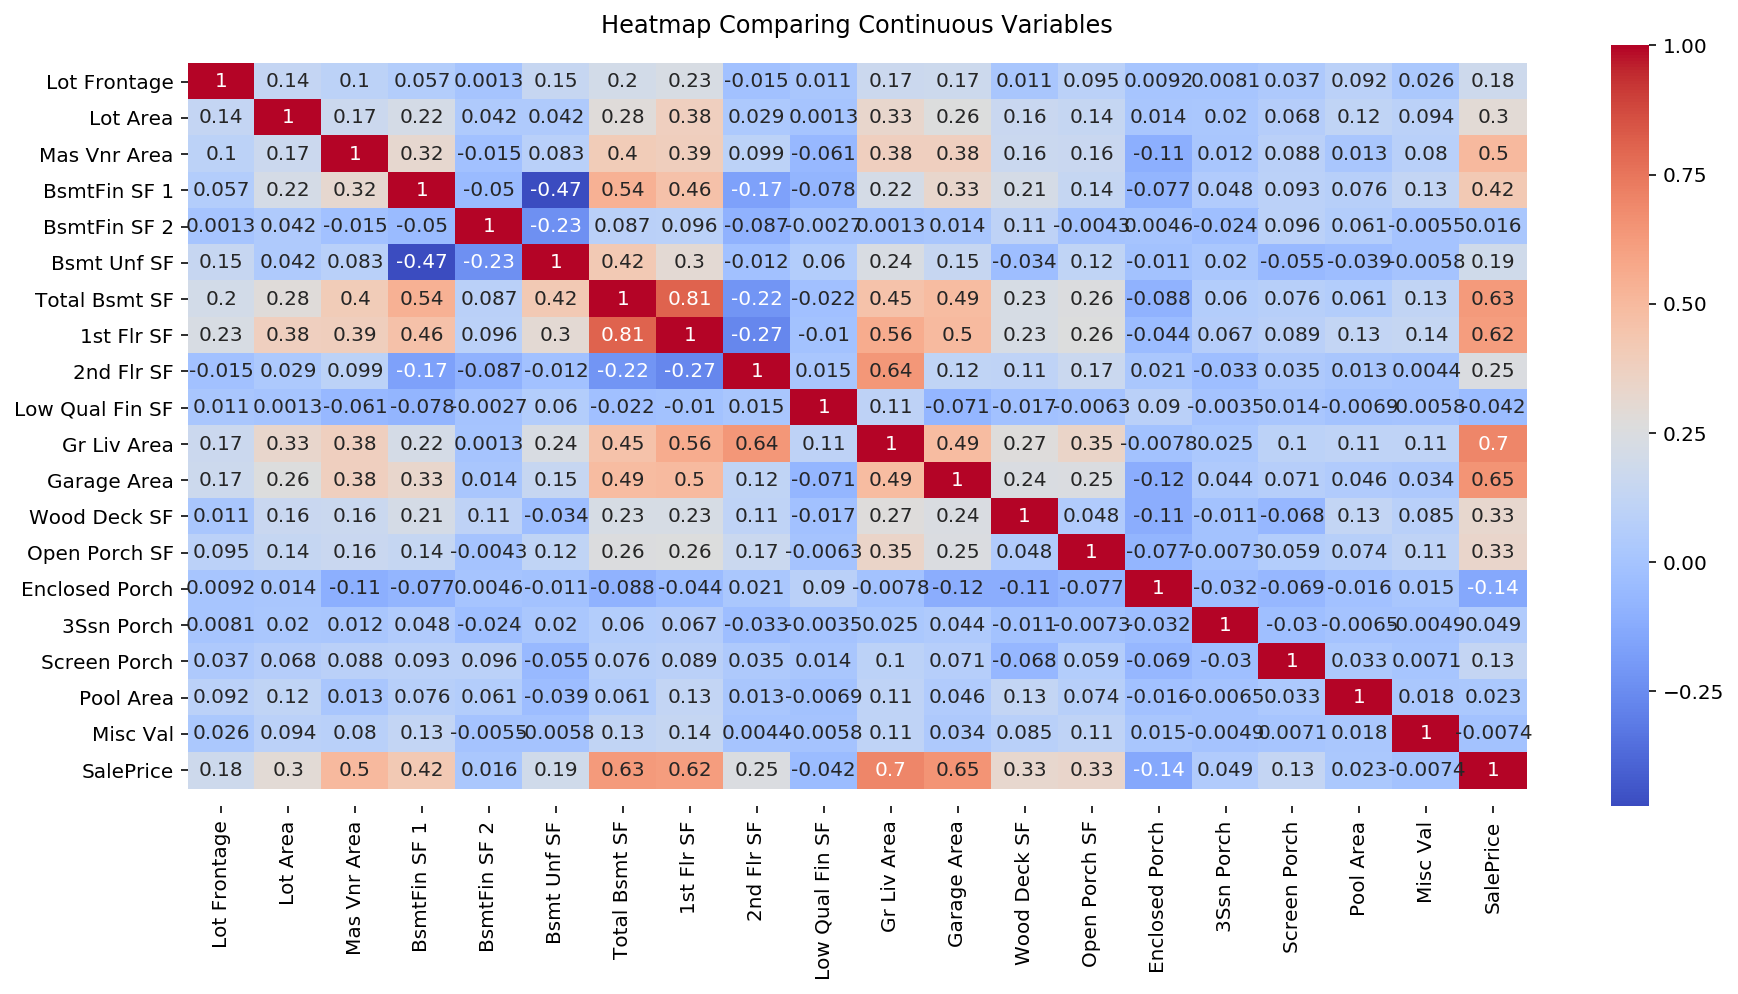

In [28]:
fig, ax = plt.subplots(1,figsize=(15,7));
sns.heatmap(df[continuous].corr(),annot =True,cmap='coolwarm'); #plot heatmap
plt.title('Heatmap Comparing Continuous Variables');
ax.set_ylim(len(df[continuous].corr())+0.5, -0.5);

#### Distributions of Continuous Variables

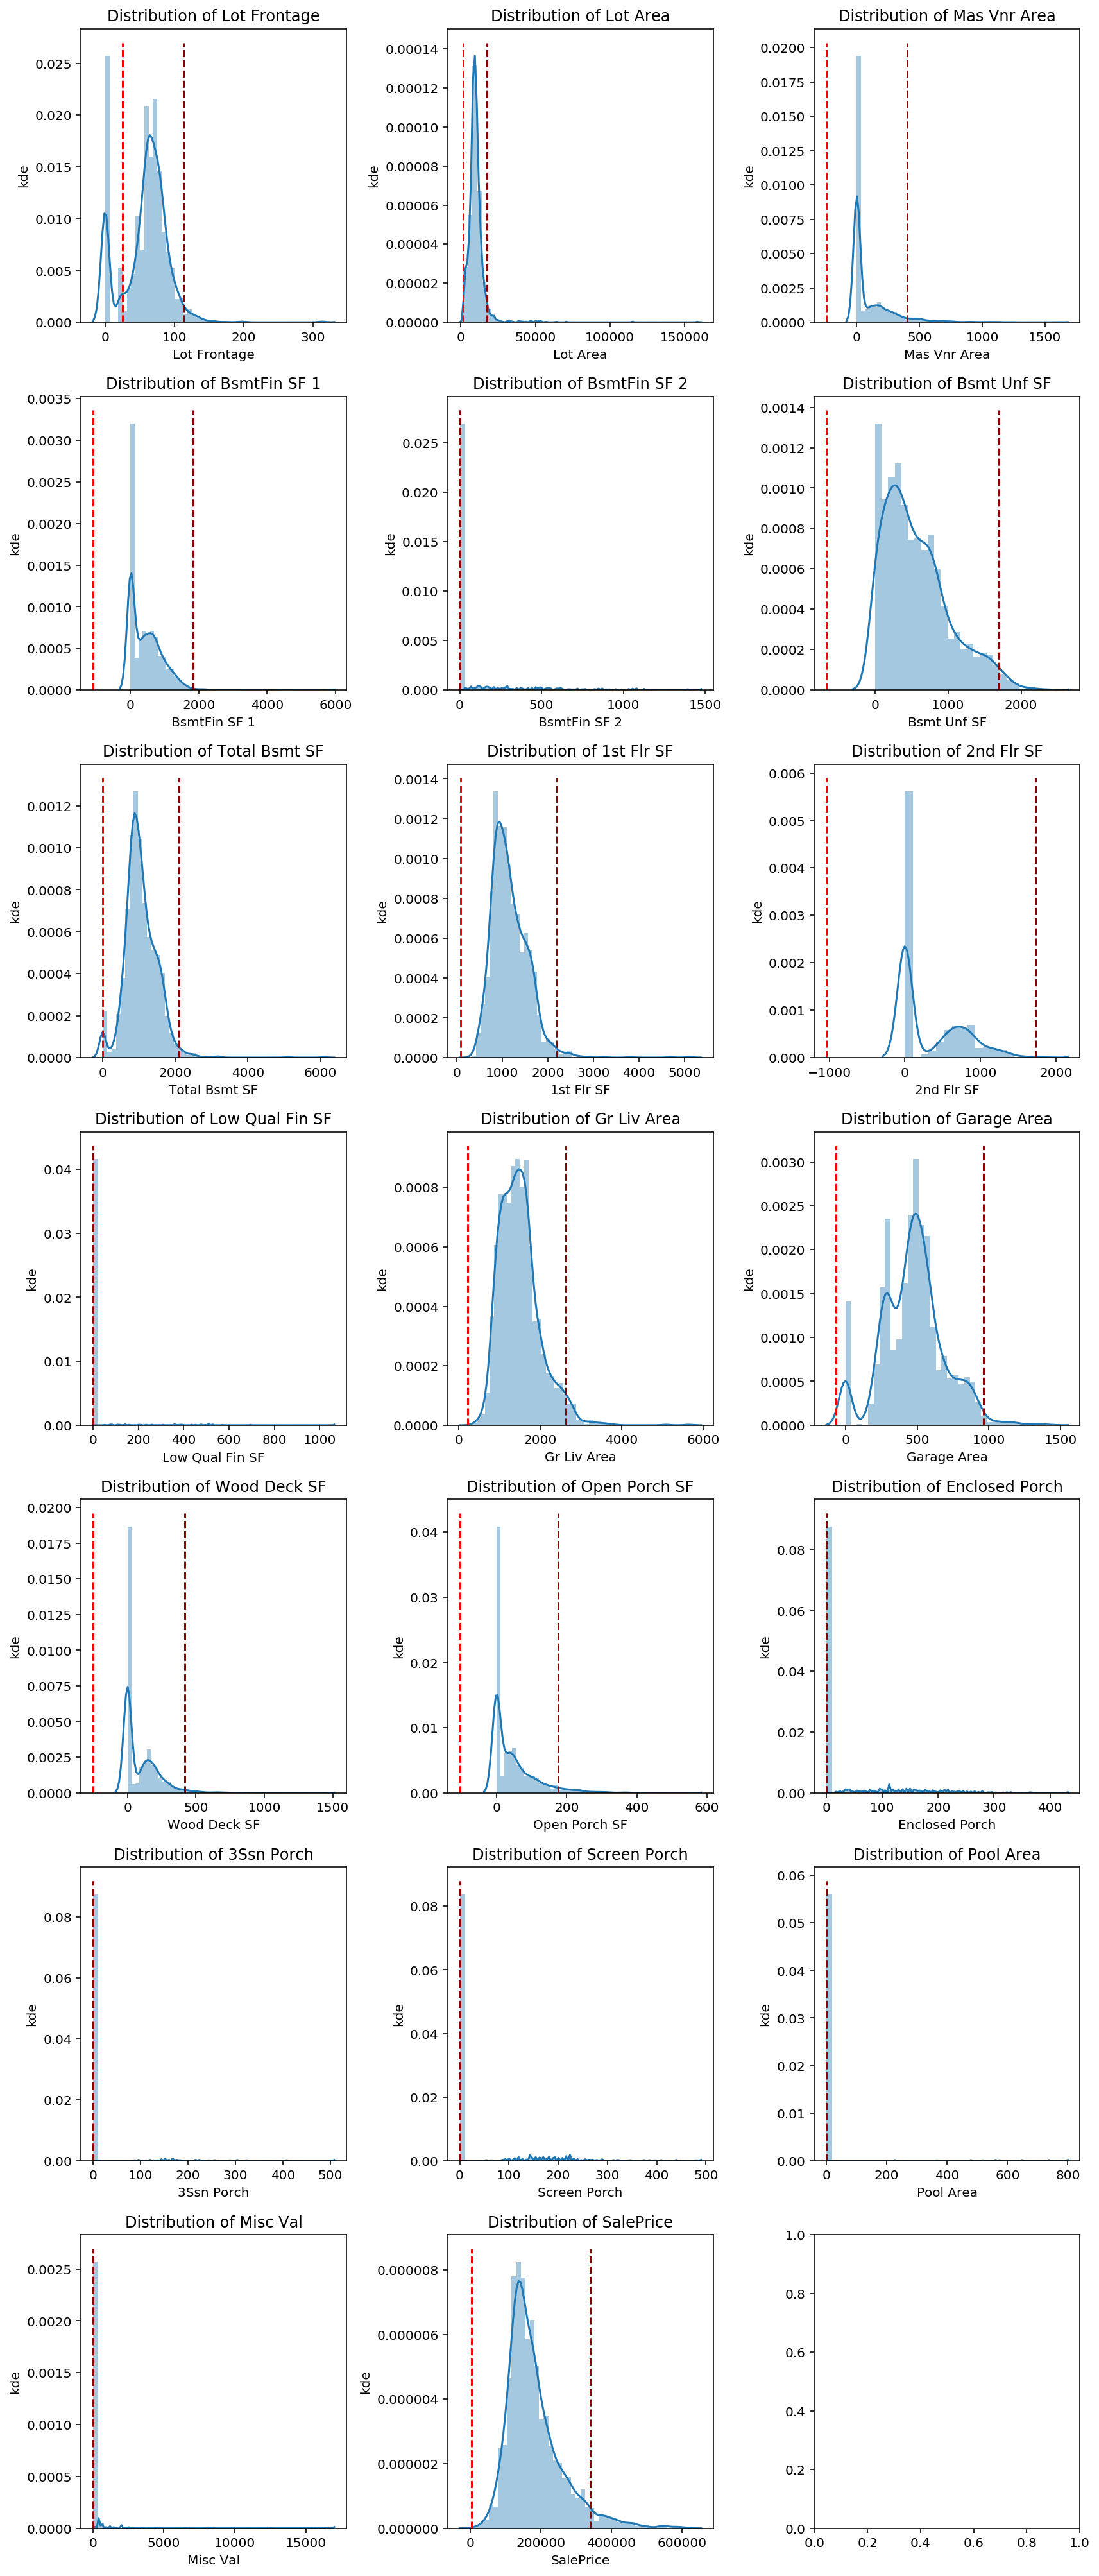

In [29]:
def subplot_distplot(dataframe,columns): #function to plot histograms
    nrows = int(np.ceil(len(columns)/3)) # Makes sure you have enough rows
    fig, ax = plt.subplots(nrows=nrows, ncols=3, figsize=(12,nrows*4))
    ax = ax.ravel()
    for i, column in enumerate(columns):
        sns.distplot(dataframe[column],ax=ax[i])
        #add lines to show outliers
        ylim = ax[i].get_ylim()[1]
        ax[i].plot([nums.loc[column,'outlier_low'],nums.loc[column,'outlier_low']],[0,ylim],c='r',ls='--') 
        ax[i].plot([nums.loc[column,'outlier_high'],nums.loc[column,'outlier_high']],[0,ylim],c='darkred',ls='--')
        ax[i].set_title('Distribution of '+column)
        ax[i].set_ylabel('kde')
    plt.tight_layout()
subplot_distplot(df,continuous) #call function

#### Scatter Plots of Continuous Variables

There are a few possible outliers of large areas with low sale price. These should probably be removed before modelling.

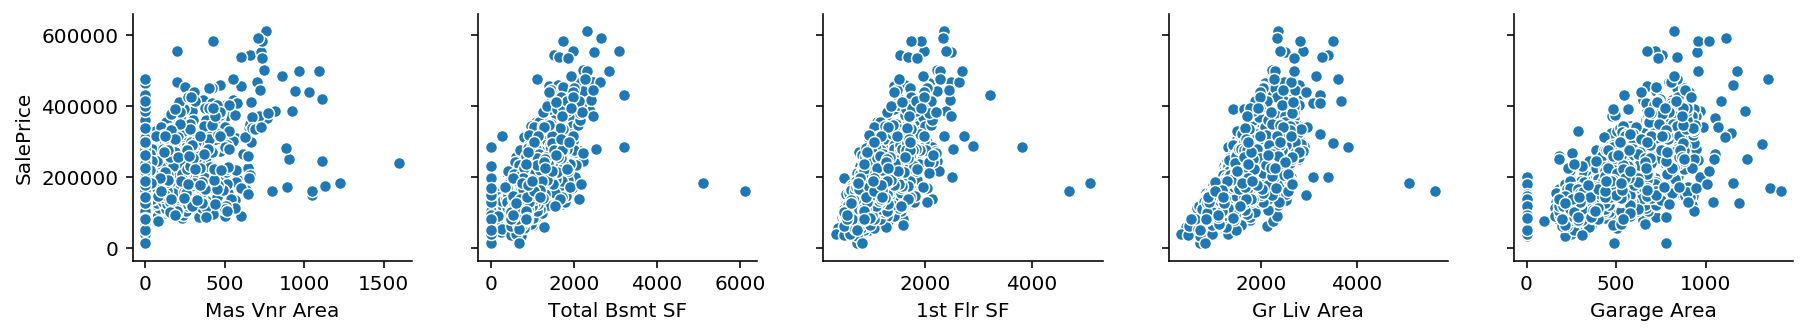

In [30]:
def get_high_corr(df,target,corr,corrmethod='pearson'): #get variables with high correlation to target
    return [i for i in df.corr(method=corrmethod).index 
            if abs(df.corr(method=corrmethod).loc[i,target])>corr and (i!=target)]
xvars_con = get_high_corr(df[continuous],'SalePrice',0.5)
sns.pairplot(data=df[continuous], x_vars = xvars_con,y_vars='SalePrice');

In [31]:
def get_collinearity(df,target,corr,corrmethod='pearson'): #define function to get list of variables with possibly collinearity
    df = df.drop(target,axis=1)
    variables = set([tuple(sorted([i,j])) 
                     for i in df.corr(method=corrmethod).index 
                     for j in df.corr(method=corrmethod).columns 
                     if (abs(df.corr(method=corrmethod).loc[i,j]>corr)) and (i!=j)])
    x_var = [var[0] for var in variables]
    y_var = [var[1] for var in variables]
    return x_var, y_var
x_var,y_var = get_collinearity(df[continuous],'SalePrice',0.5)

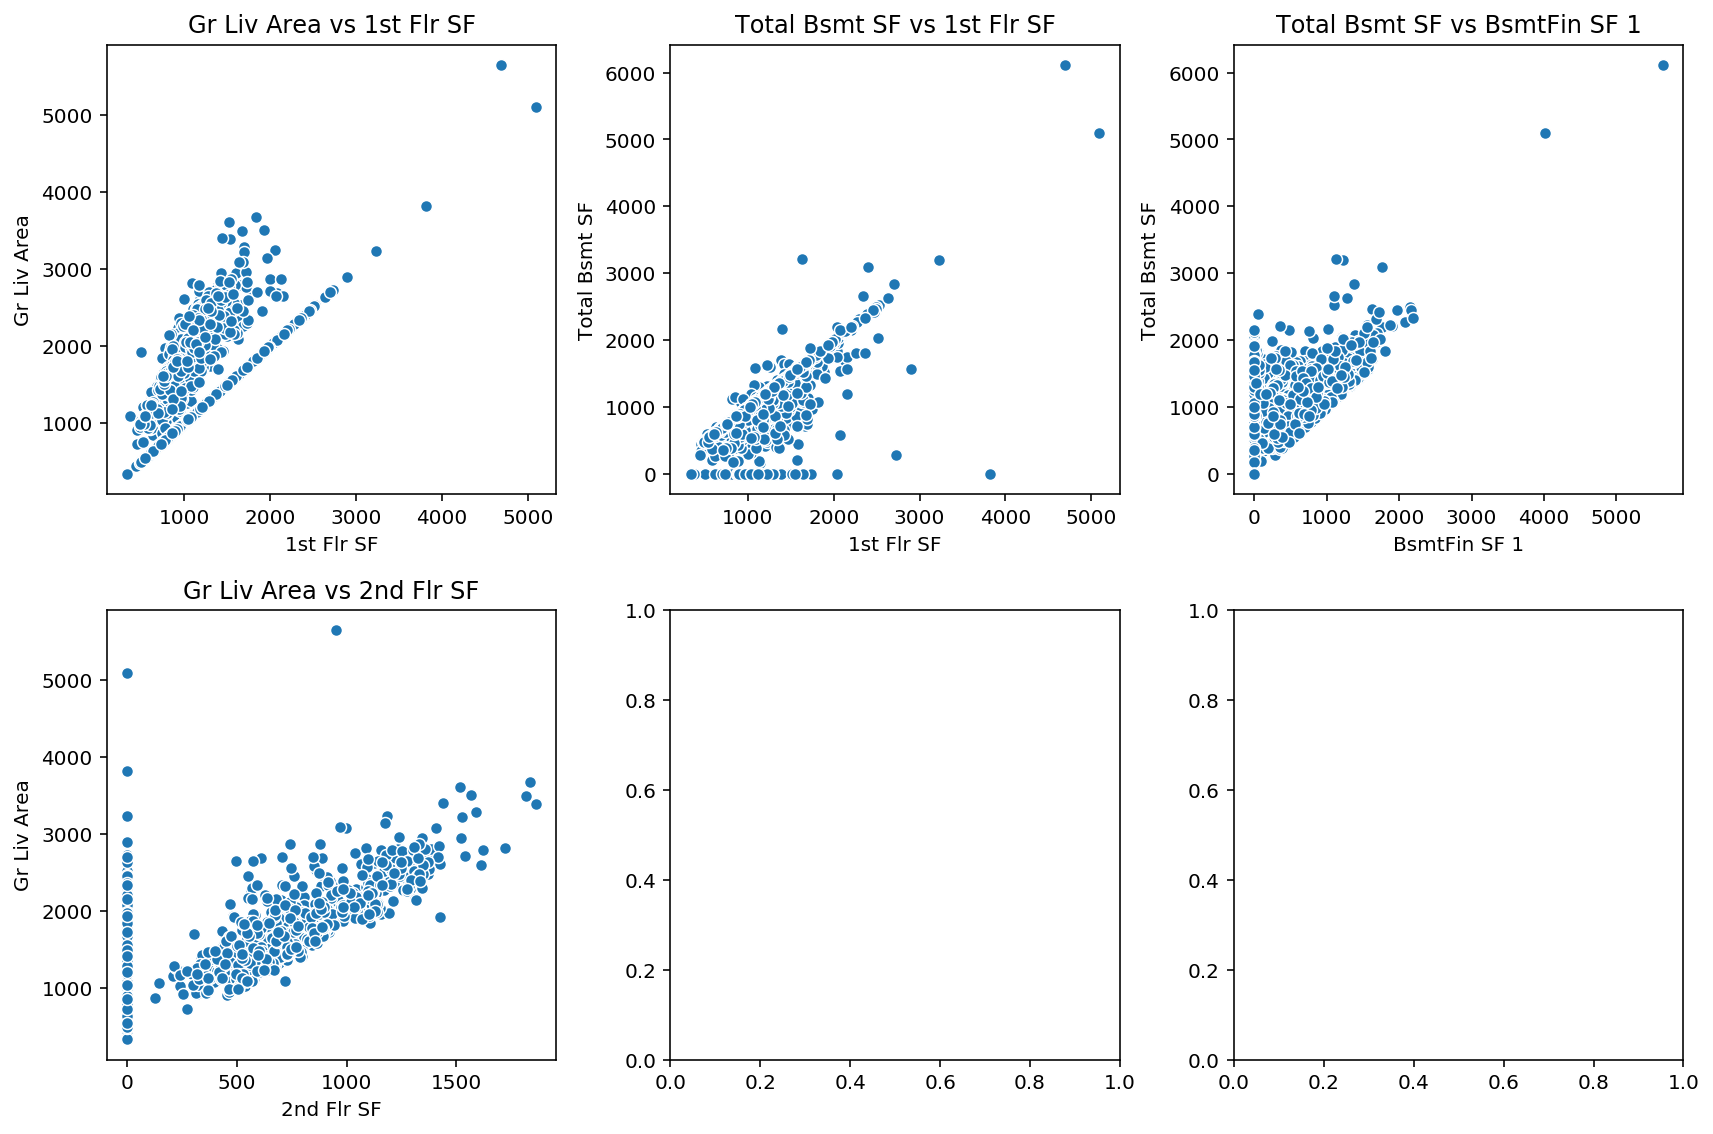

In [32]:
def subplot_scatter(dataframe,cols_x,cols_y): #plot multiple scatter plots
    nrows = int(np.ceil(len(cols_x)/3)) # Makes sure you have enough rows
    fig, ax = plt.subplots(nrows=nrows, ncols=3, figsize=(12,nrows*4))
    ax = ax.ravel()
    for i, column in enumerate(cols_x):
        sns.scatterplot(x=dataframe[column],y=dataframe[cols_y[i]],ax=ax[i])
        ax[i].set_title(cols_y[i]+' vs '+column)
    plt.tight_layout()
subplot_scatter(df[continuous],x_var,y_var)

### Discrete Variables

This section explores the correlations of discrete variables with SalePrice and within themselves.

In [33]:
discrete = data_dict[data_dict.TypeDescription=='Discrete'].index #list of discrete variables
discrete_df = pd.concat([df[discrete],df.SalePrice],axis=1)

#### Correlation Heatmap for Discrete Variables

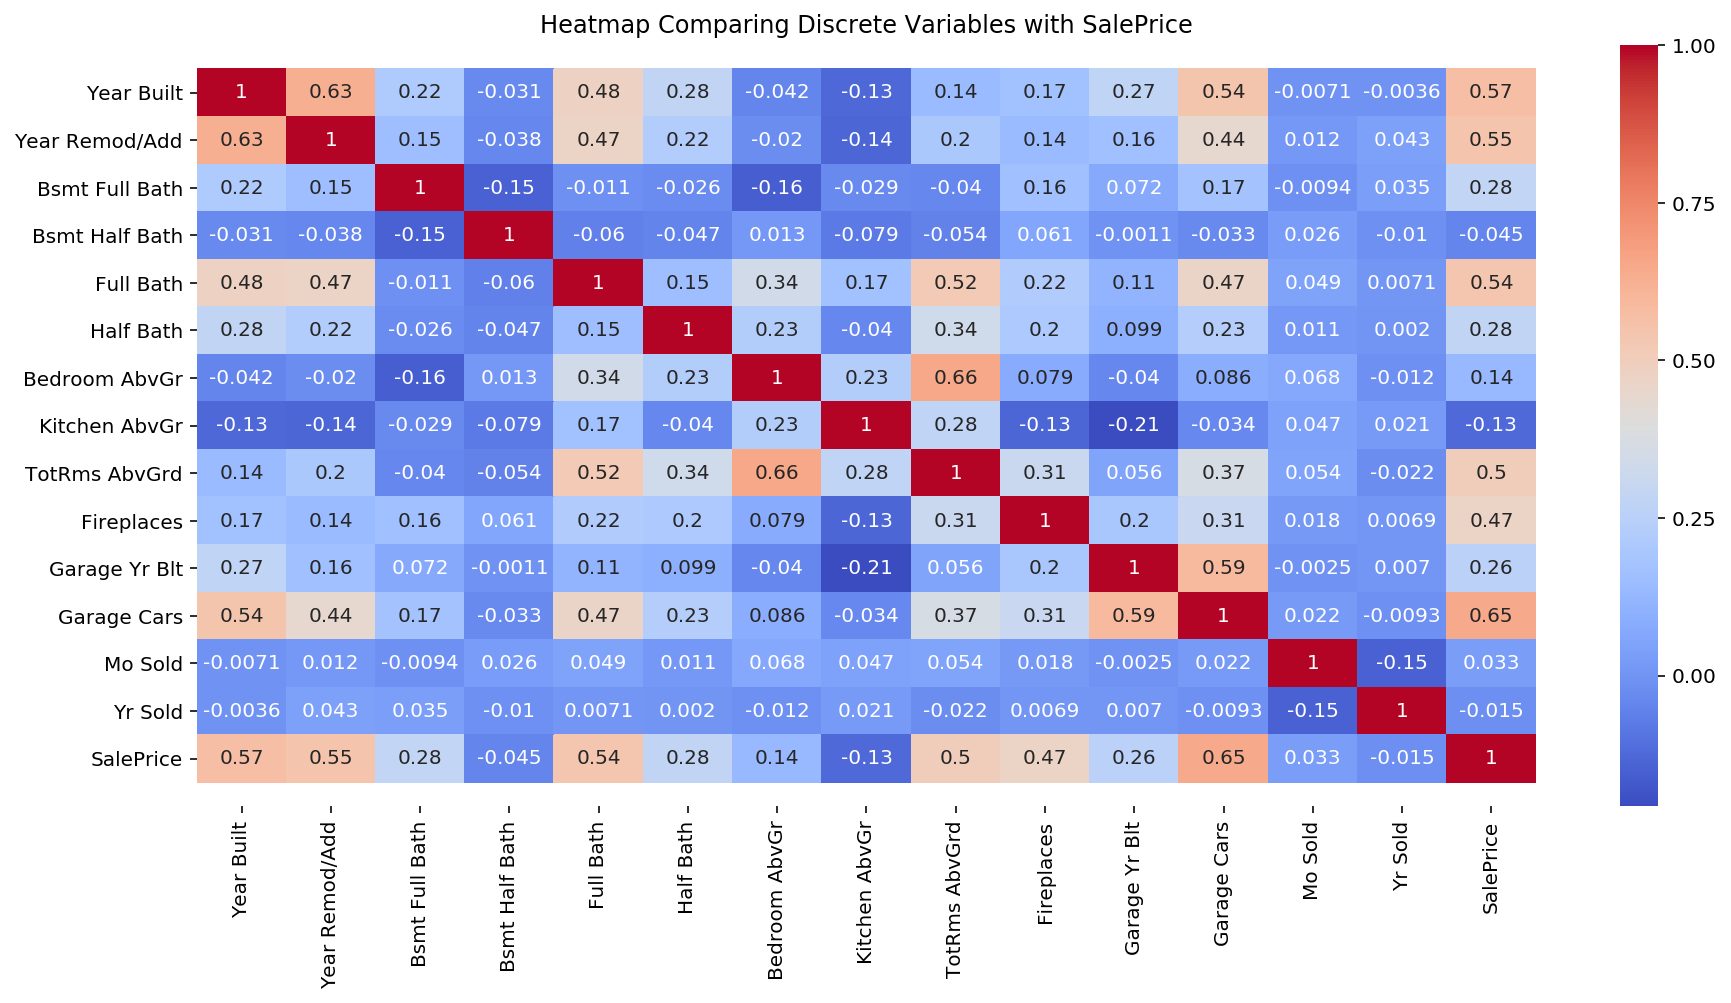

In [34]:
fig, ax = plt.subplots(1,figsize=(15,7));
sns.heatmap(discrete_df.corr(),annot =True,cmap='coolwarm'); #plot heatmap
plt.title('Heatmap Comparing Discrete Variables with SalePrice');
ax.set_ylim(len(discrete_df.corr())+0.5, -0.5);

#### Distributions of Discrete Variables

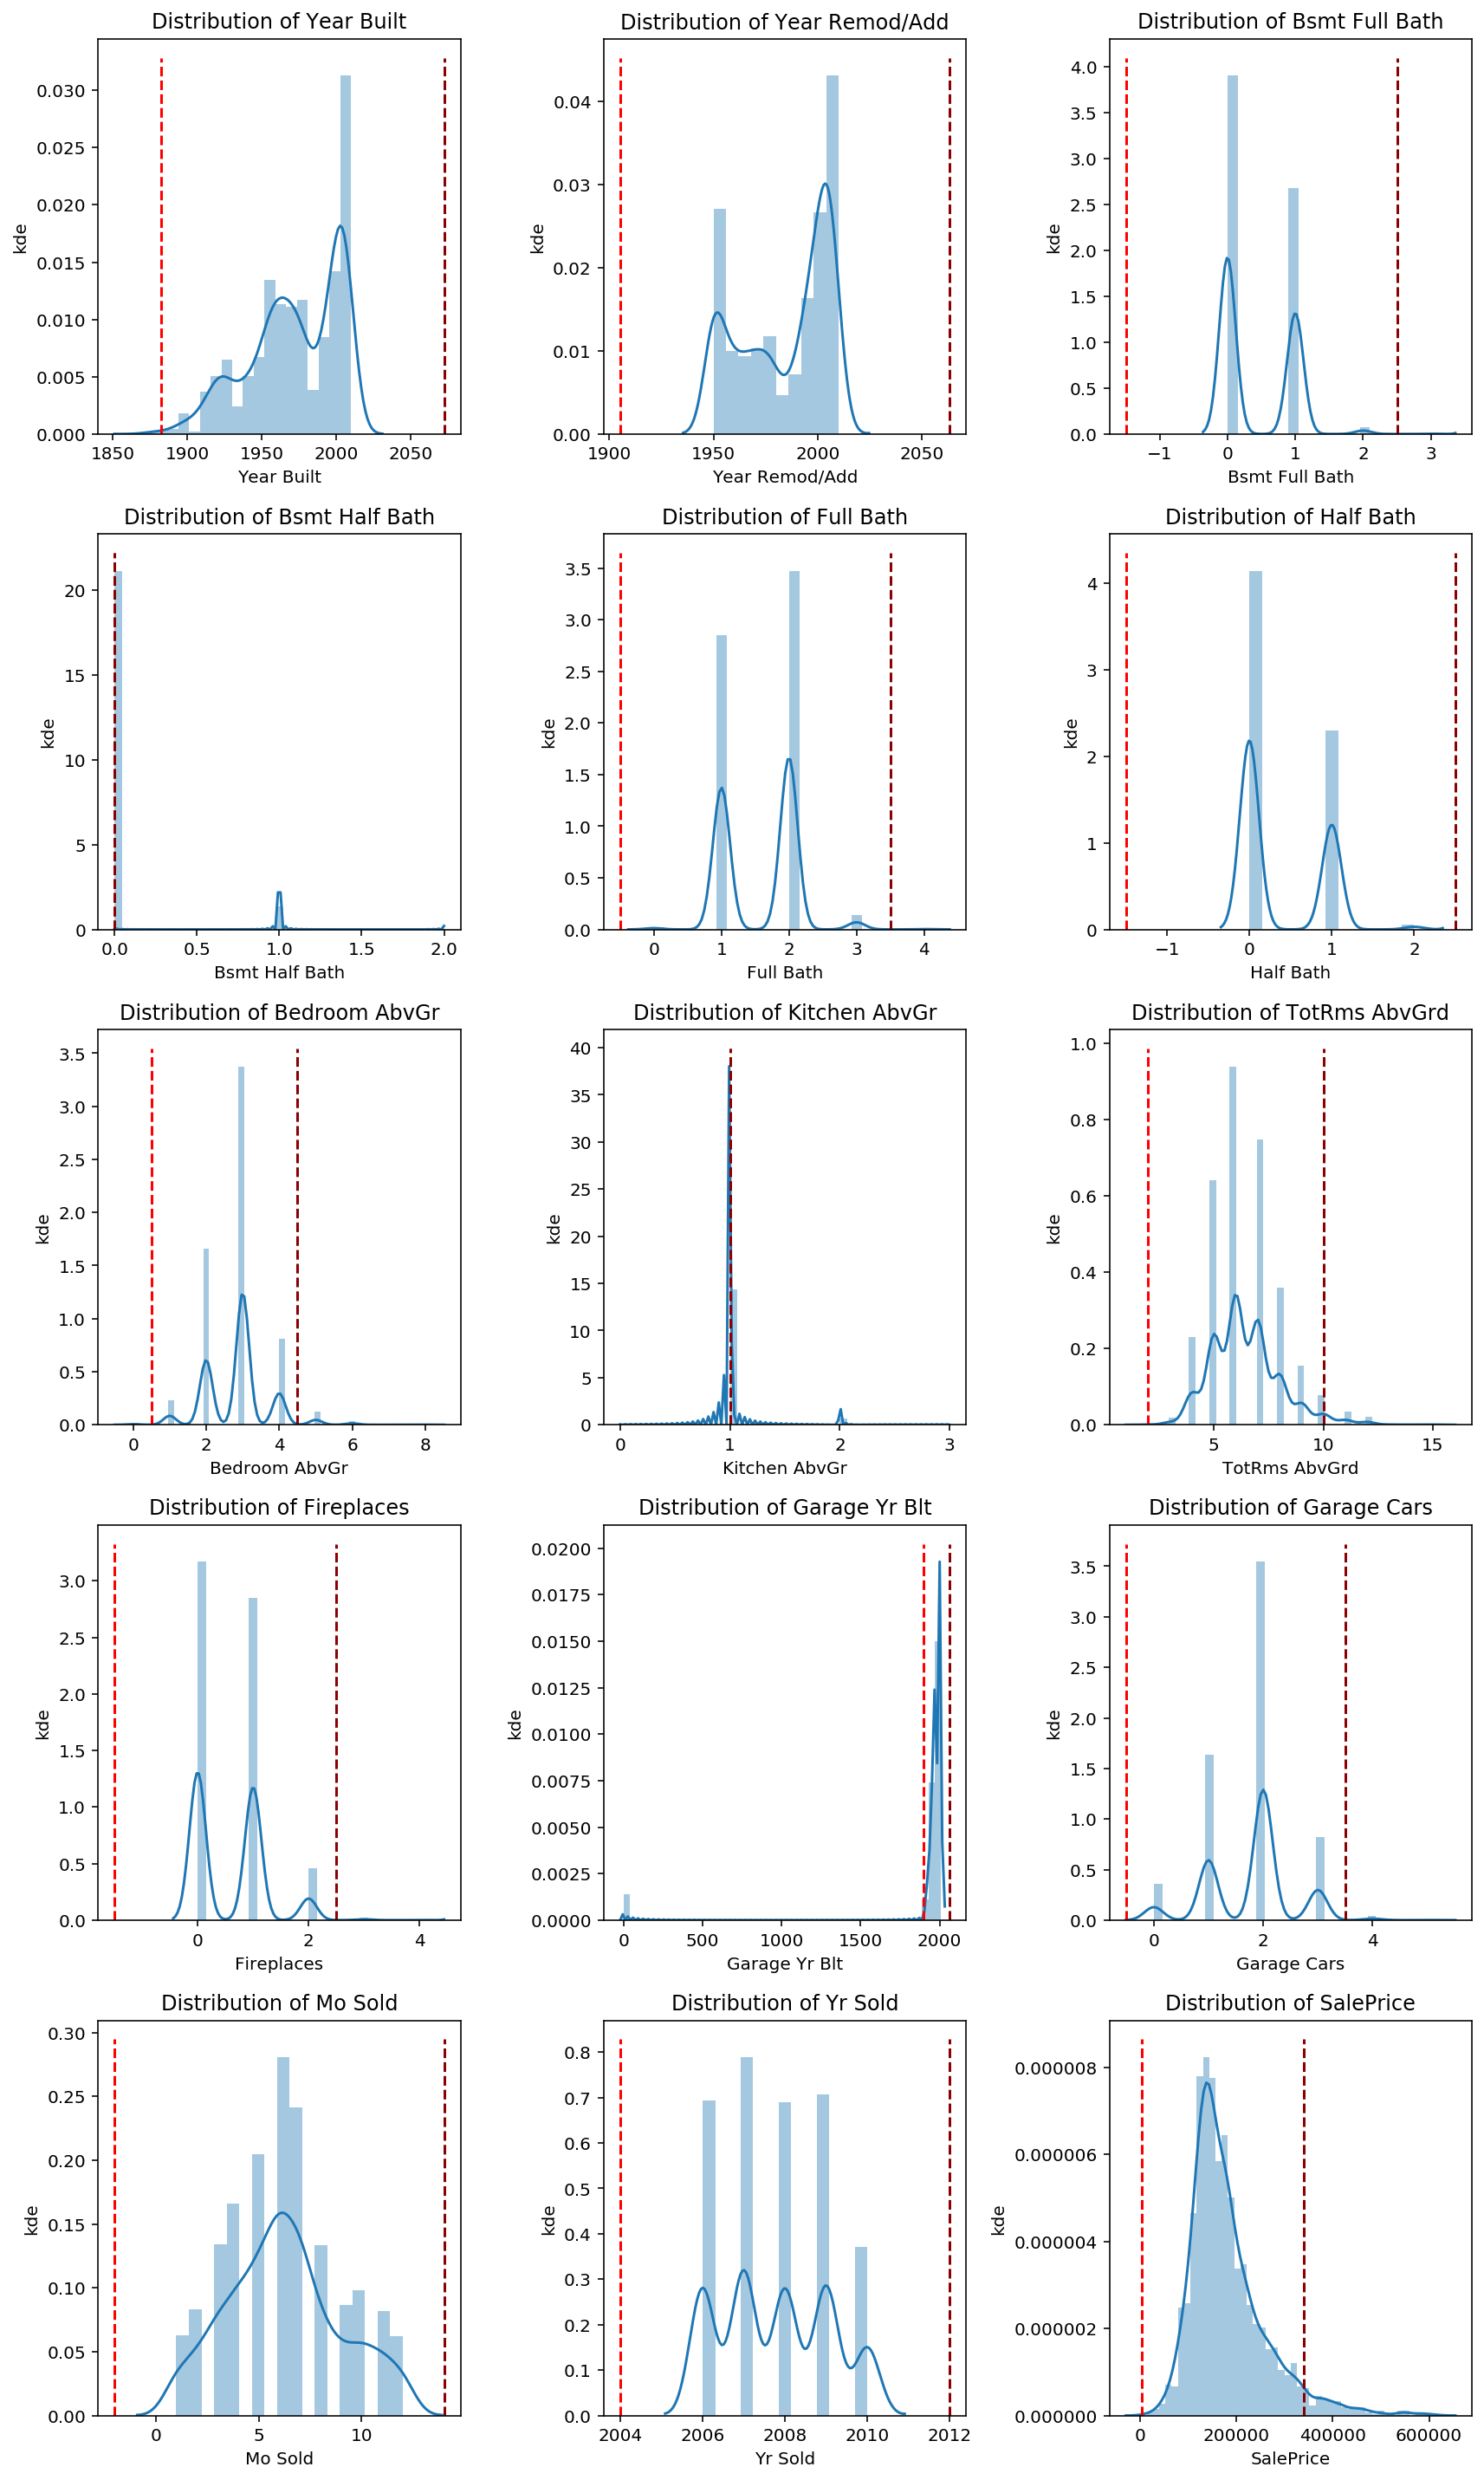

In [35]:
subplot_distplot(df,discrete_df.columns) #plot histograms of discrete variables

In [ ]:
### some of the KDEs presented here are horribly estimated. 
### you might want to fiddle with the kernel bandwidth so it comes out a bit more nicely, or choose not to plot the
### KDE in the first place. 

#### Scatter Plots  of Discrete Variables

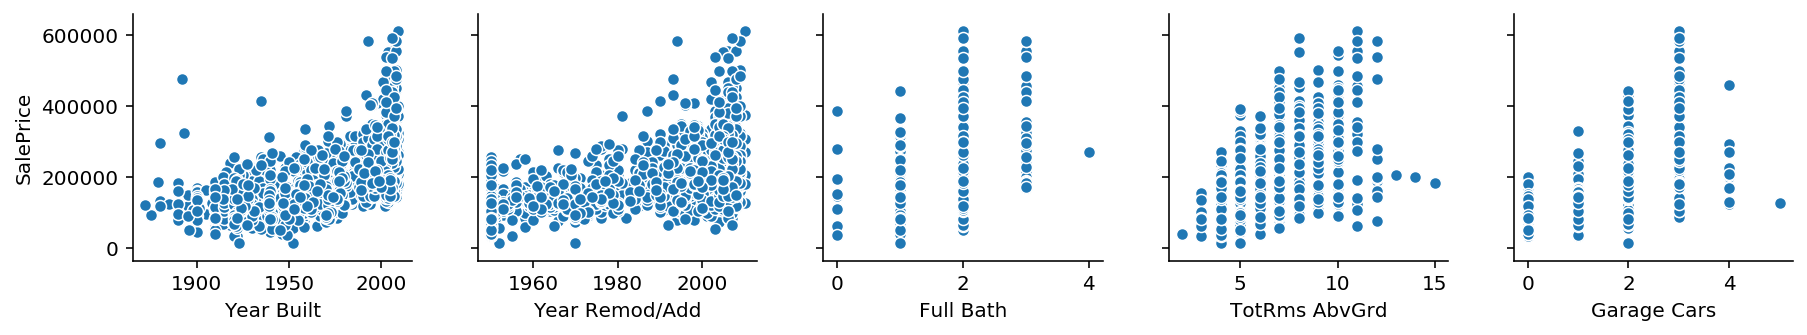

In [36]:
xvars_dis = get_high_corr(discrete_df,'SalePrice',0.5)#plot scatter plots of discrete variables correlated to price 
sns.pairplot(data=discrete_df, x_vars = xvars_dis,y_vars='SalePrice'); 

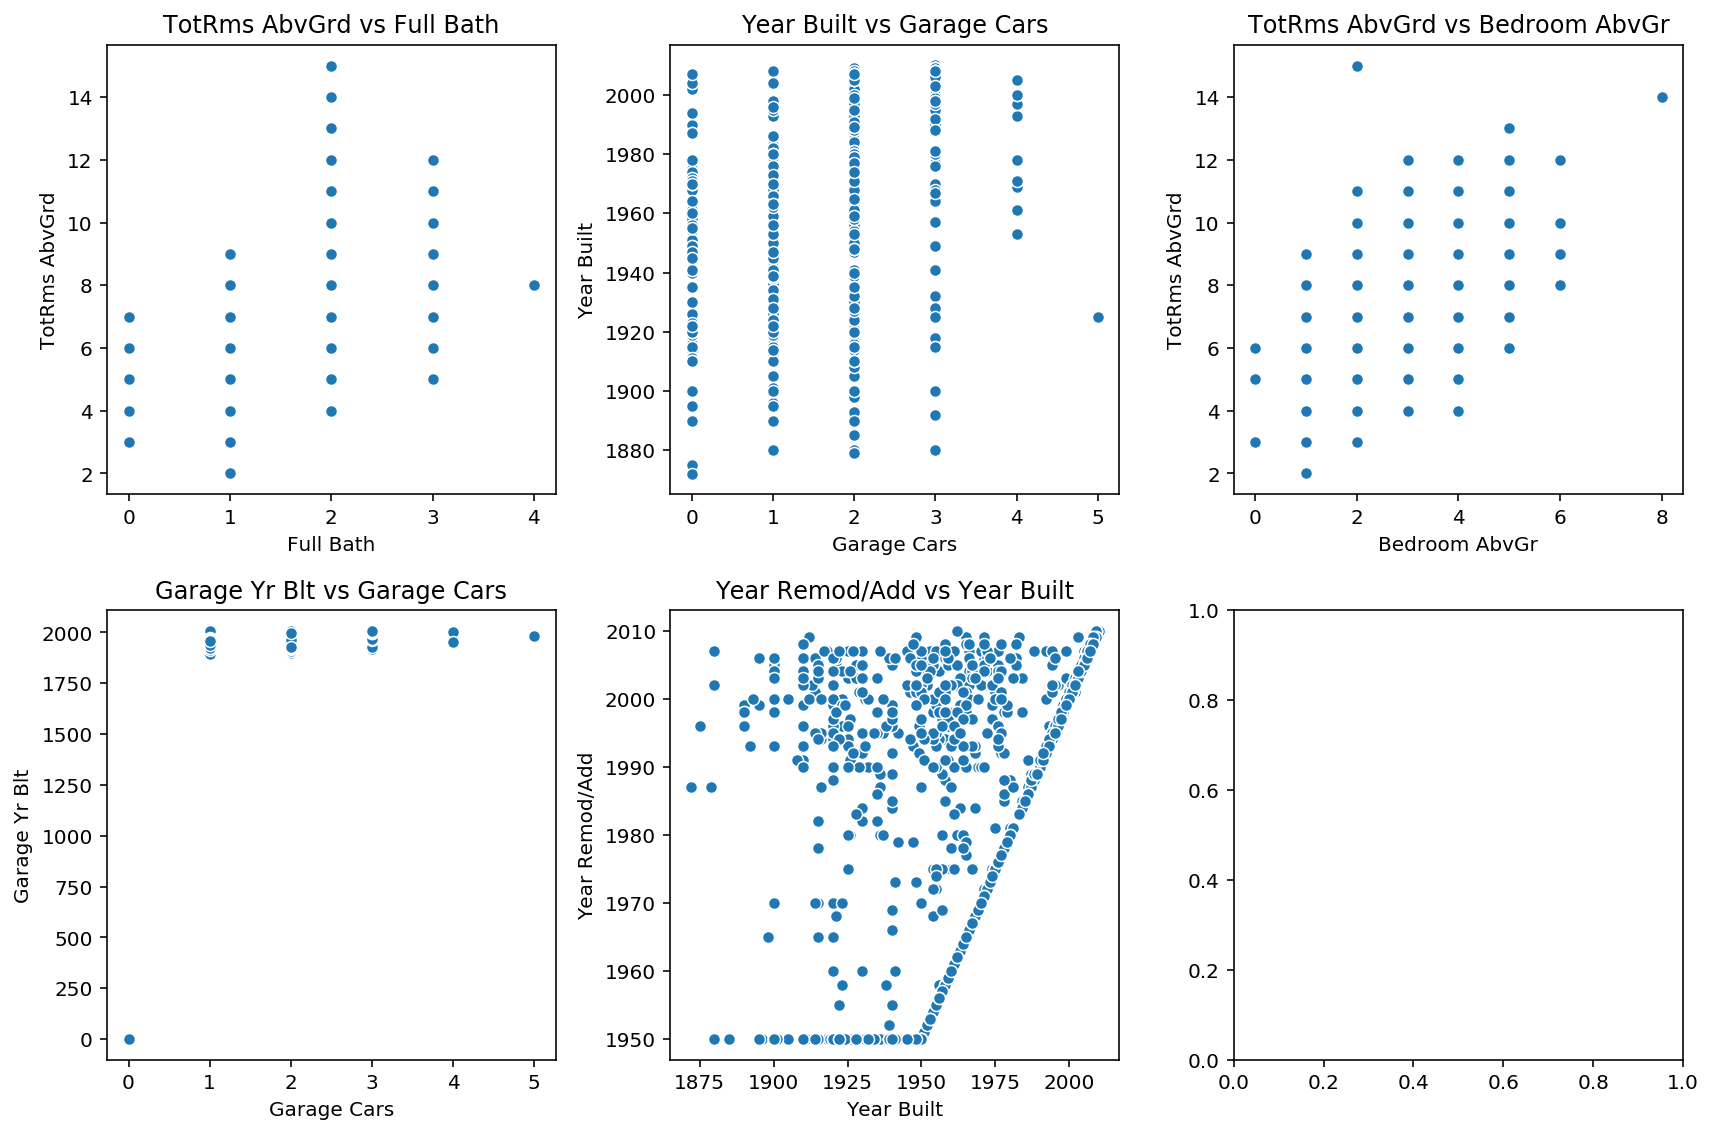

In [37]:
x_var,y_var = get_collinearity(discrete_df,'SalePrice',0.5) #discrete variables with possible collinearity
subplot_scatter(discrete_df,x_var,y_var)

### Ordinal Variabes

This section explores the correlations of ordinal variables with SalePrice.

#### Correlation Heatmap of Ordinal Variables

 As the ordinal variables are descriptive, the progression of values may not be linear. The Spearman's test for correlation is more appropriate when the variables are ordinal.

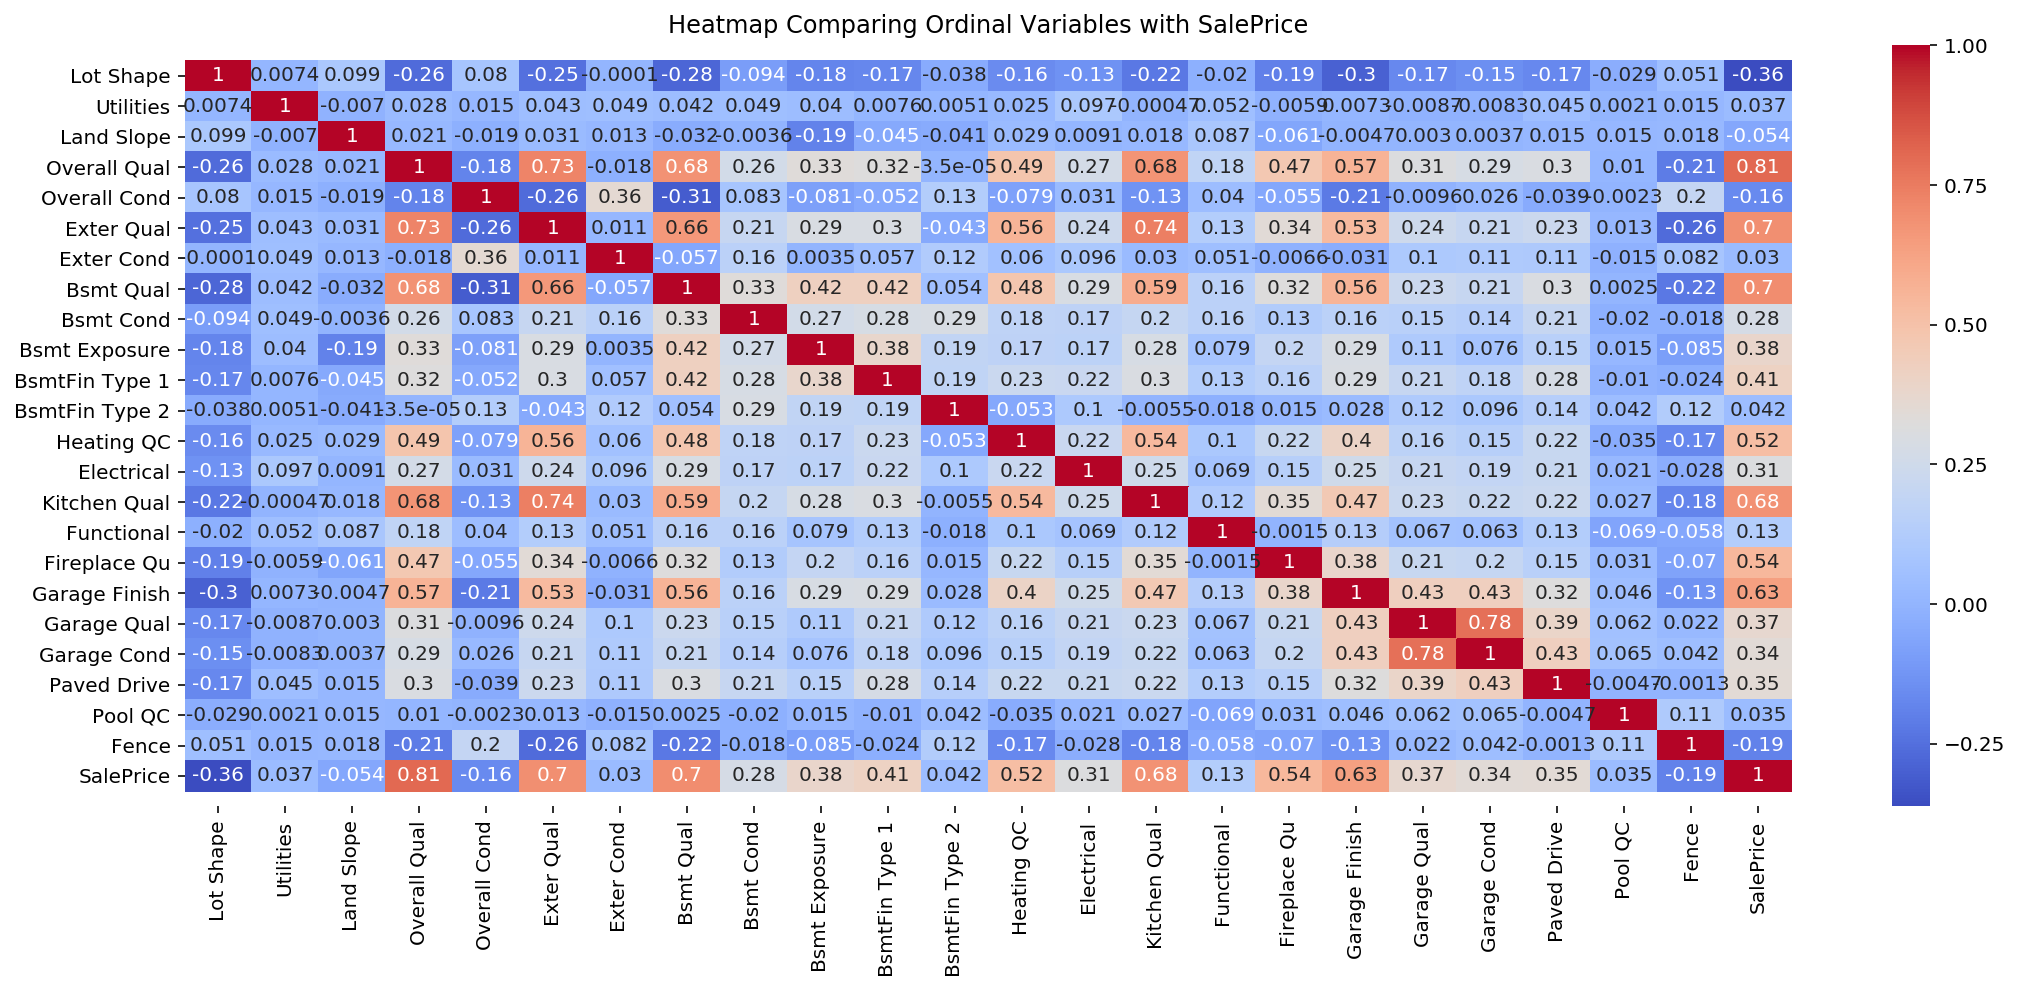

In [38]:
ord_df = pd.concat([df[ordinal],df.SalePrice],axis=1)
fig, ax = plt.subplots(1,figsize=(18,7));
sns.heatmap(ord_df.corr(method='spearman'),annot =True,cmap='coolwarm'); #plot heatmap
plt.title('Heatmap Comparing Ordinal Variables with SalePrice');
ax.set_ylim(len(ord_df.corr(method='spearman'))+0.5, -0.5);

#### Distributions of Ordinal Variables

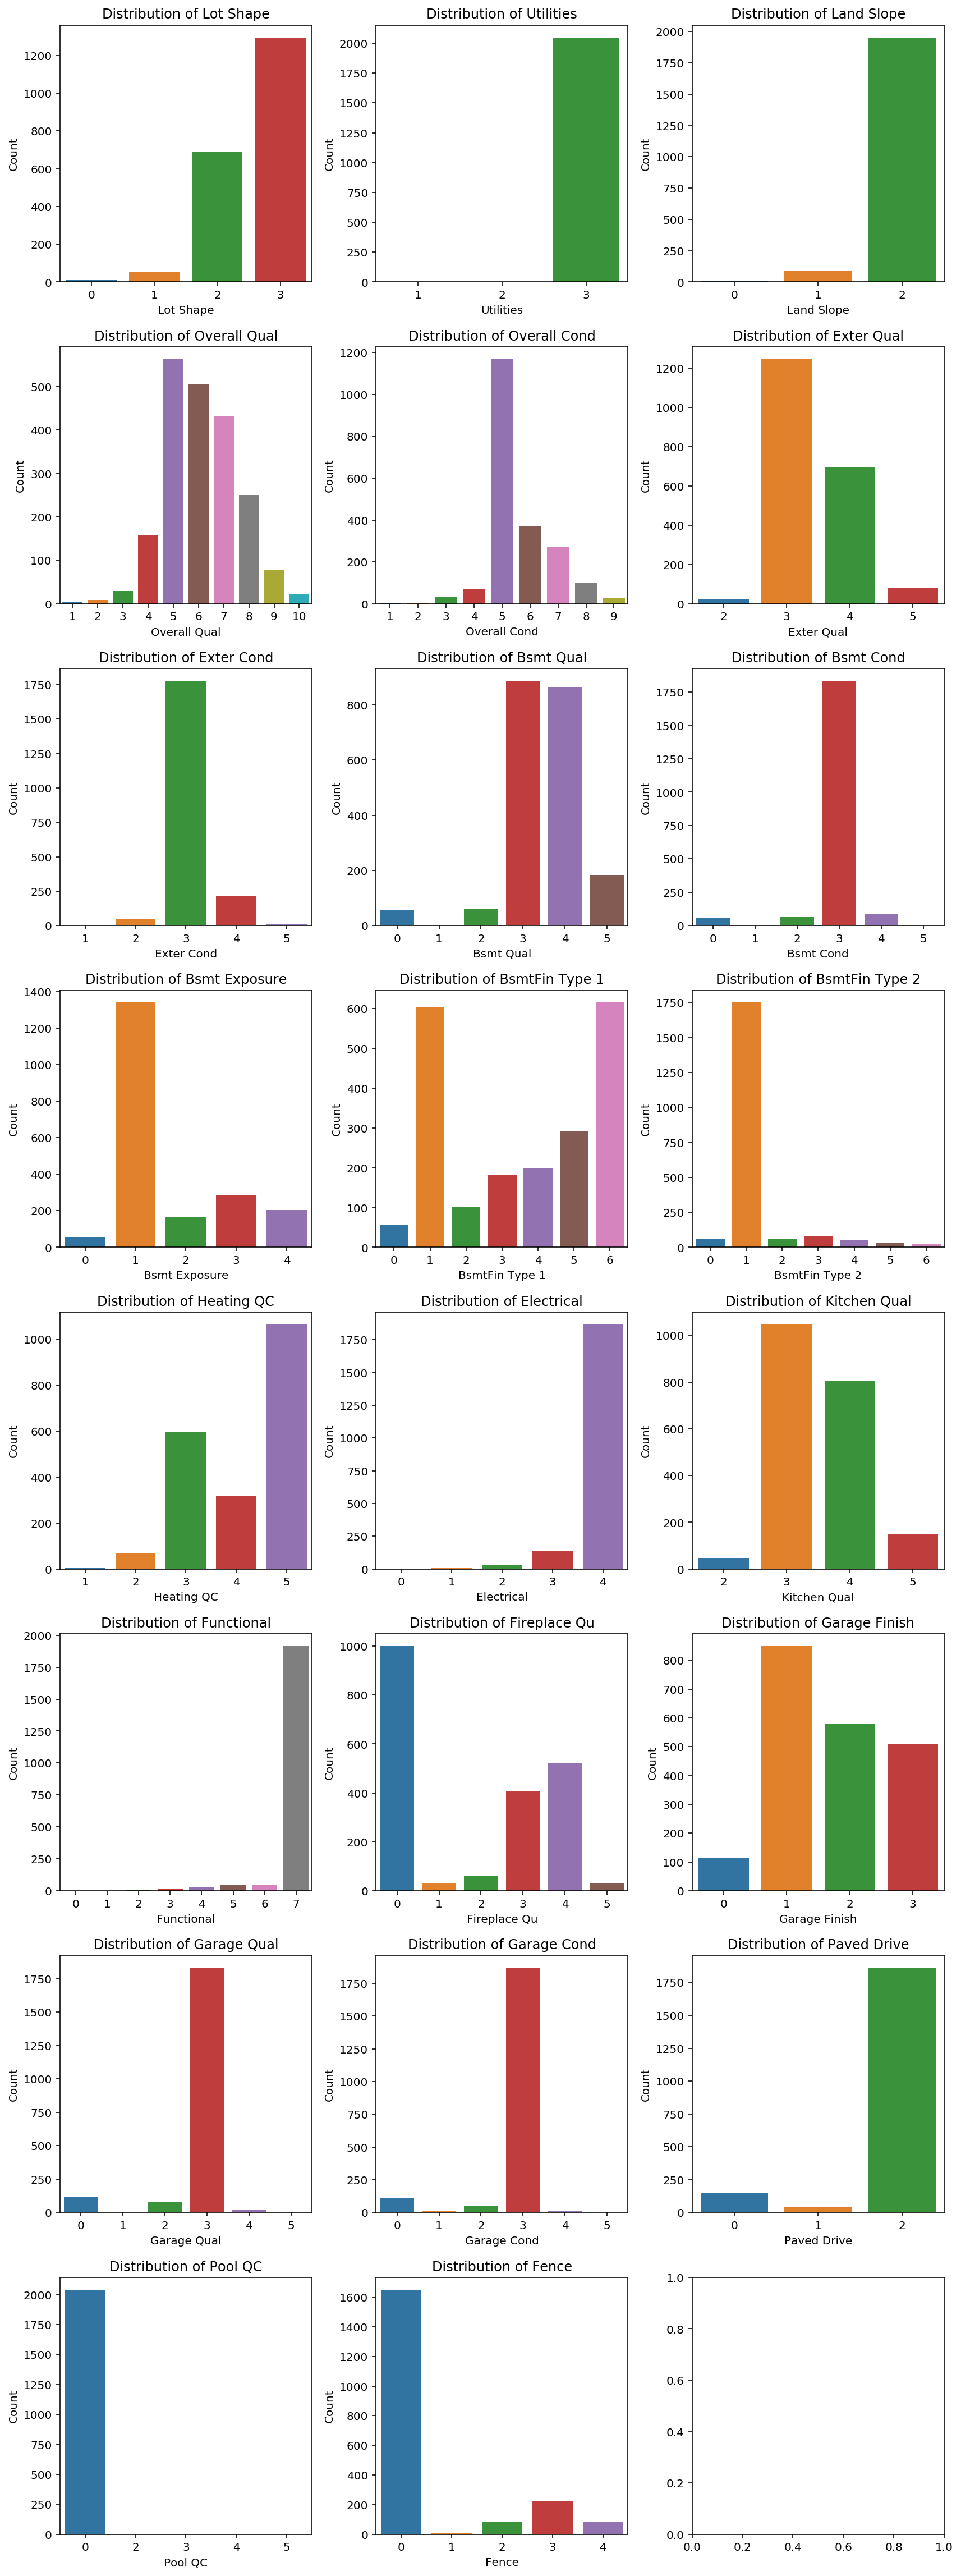

In [39]:
def subplot_countplot(dataframe,columns): #function to plot counts of variables
    nrows = int(np.ceil(len(columns)/3)) 
    fig, ax = plt.subplots(nrows=nrows, ncols=3, figsize=(12,nrows*4))
    ax = ax.ravel()
    for i, column in enumerate(columns):
        sns.countplot(dataframe[column],ax=ax[i])
        ax[i].set_title('Distribution of '+column)
        ax[i].set_ylabel('Count')
    plt.tight_layout()
    
subplot_countplot(df,ordinal) # call function

#### Box Plots of Ordinal Variables by SalePrice

These box plots show the distribution of SalePrice by categories that have a Spearman's correlation of more than 0.5.

In [40]:
def subplot_boxplot(dataframe,columns,target): #function to plot counts of variables
    nrows = int(np.ceil(len(columns)/3)) 
    fig, ax = plt.subplots(nrows=nrows, ncols=3, figsize=(15,nrows*4))
    ax = ax.ravel()
    for i, column in enumerate(columns):
        sns.boxplot(x=column,y=target,data = dataframe,ax=ax[i])
        ax[i].set_title('Boxplot of '+target+' by '+column)
        ax[i].set_ylabel(target)
    plt.tight_layout()

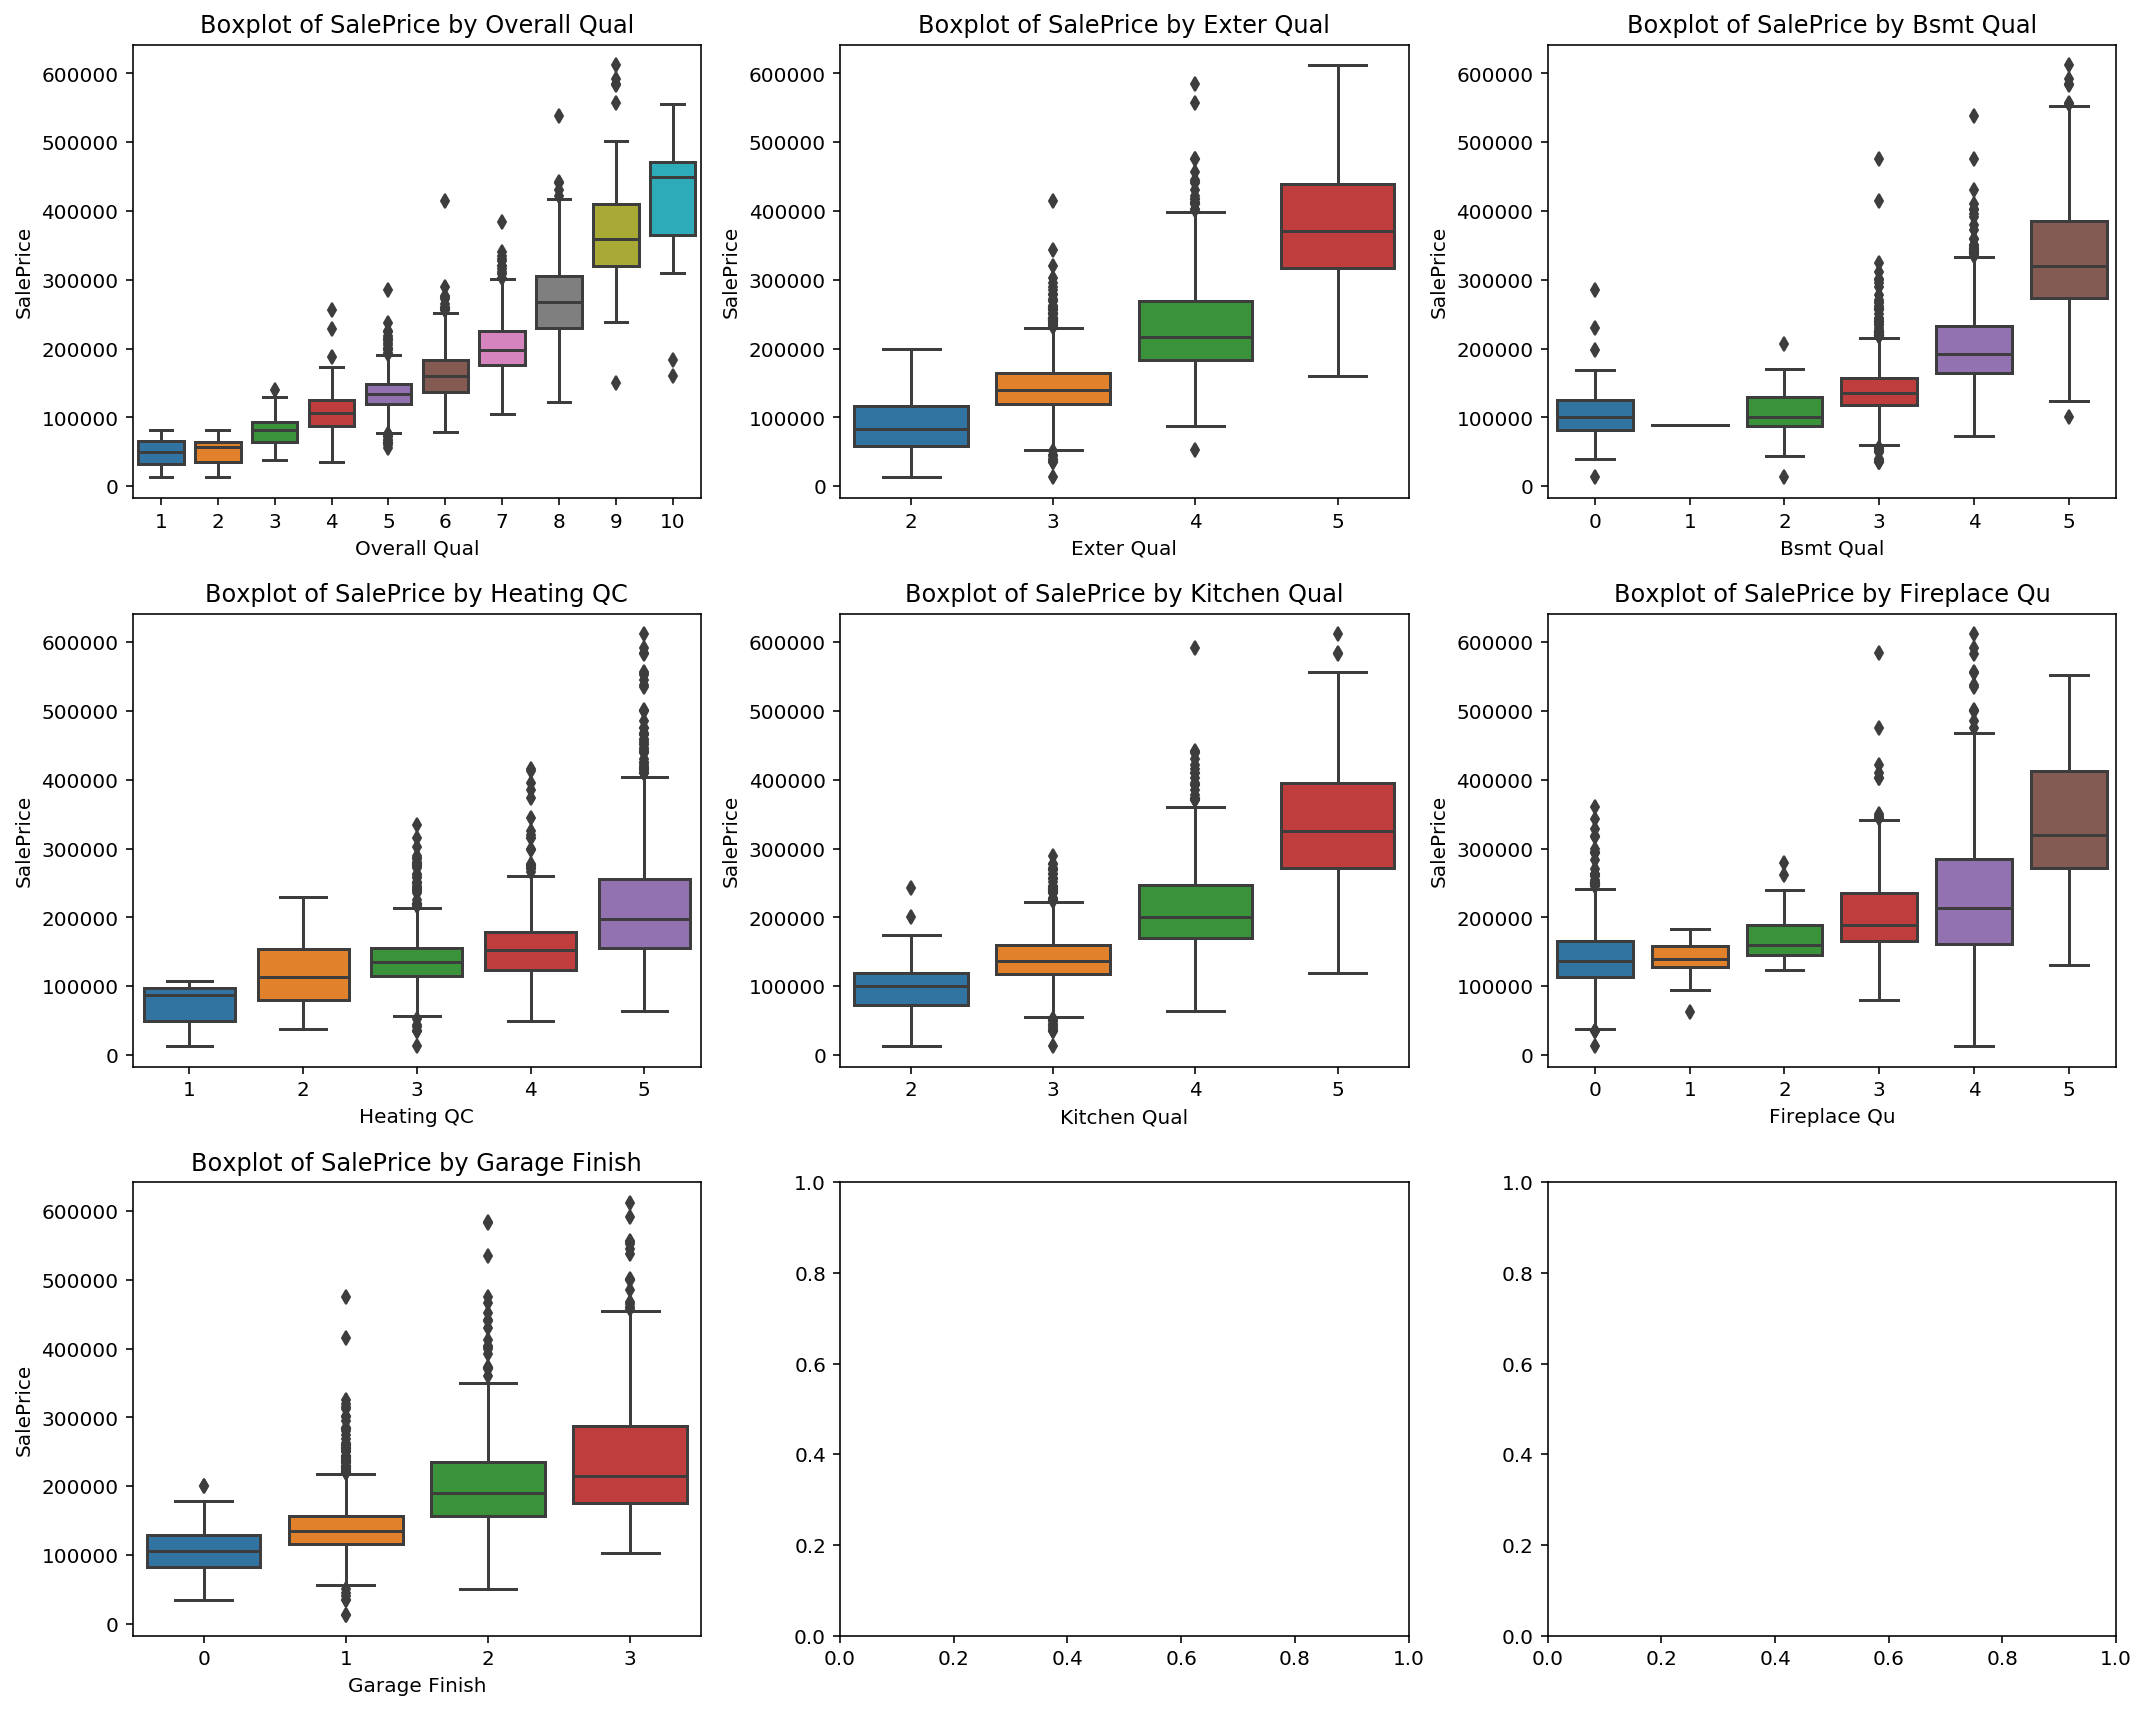

In [41]:
xvars_ord = get_high_corr(ord_df,'SalePrice',0.5,corrmethod='spearman')
subplot_boxplot(df,xvars_ord,'SalePrice')

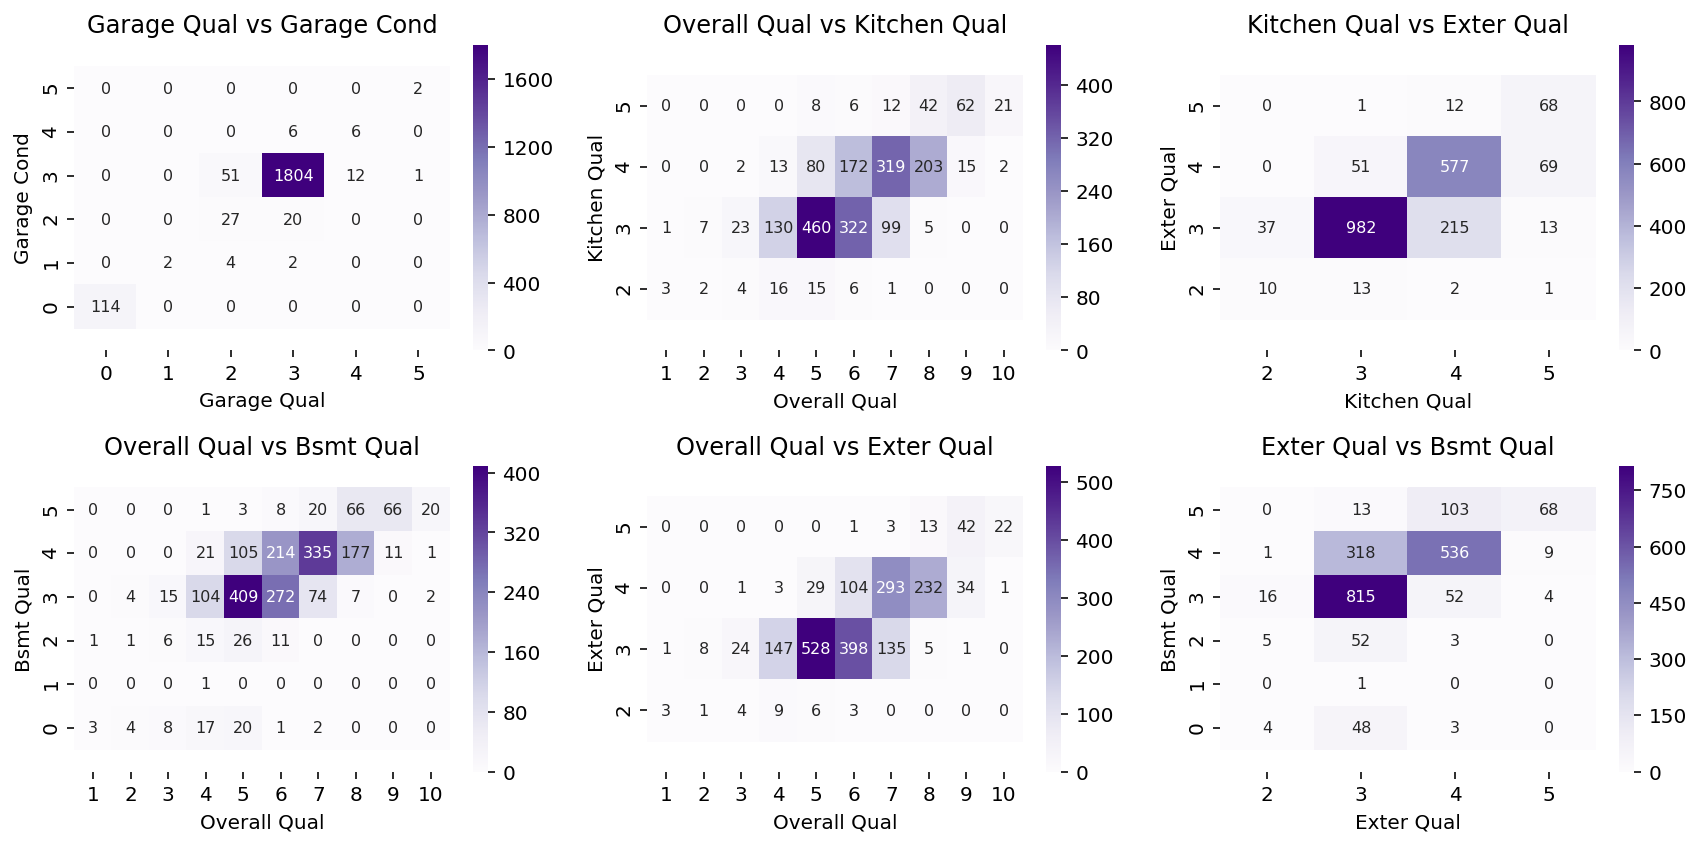

In [42]:
def subplot_heatmap(dataframe,cols_x,cols_y): #plot multiple heatmaps to compare two categorical variables
    nrows = int(np.ceil(len(cols_x)/3)) 
    fig, ax = plt.subplots(nrows=nrows, ncols=3, figsize=(12,nrows*3))
    ax = ax.ravel()
    for i, column in enumerate(cols_x):
        x_tab = pd.crosstab(dataframe[column],dataframe[cols_y[i]], margins = False).sort_index(ascending=False)
        sns.heatmap(x_tab,cmap='Purples',fmt='g', annot=True,ax=ax[i],annot_kws={"fontsize":8})
        ax[i].set_title(cols_y[i]+' vs '+column)
        ax[i].set_ylim(len(x_tab)+0.5, -0.5);
    plt.tight_layout()

x_var,y_var = get_collinearity(ord_df,'SalePrice',0.6,corrmethod='spearman') # variables with possible relationship
subplot_heatmap(ord_df,x_var,y_var)

### Nominal Variables

This section views the distributions of nomimal variables.

#### Distributions of Nominal Variables

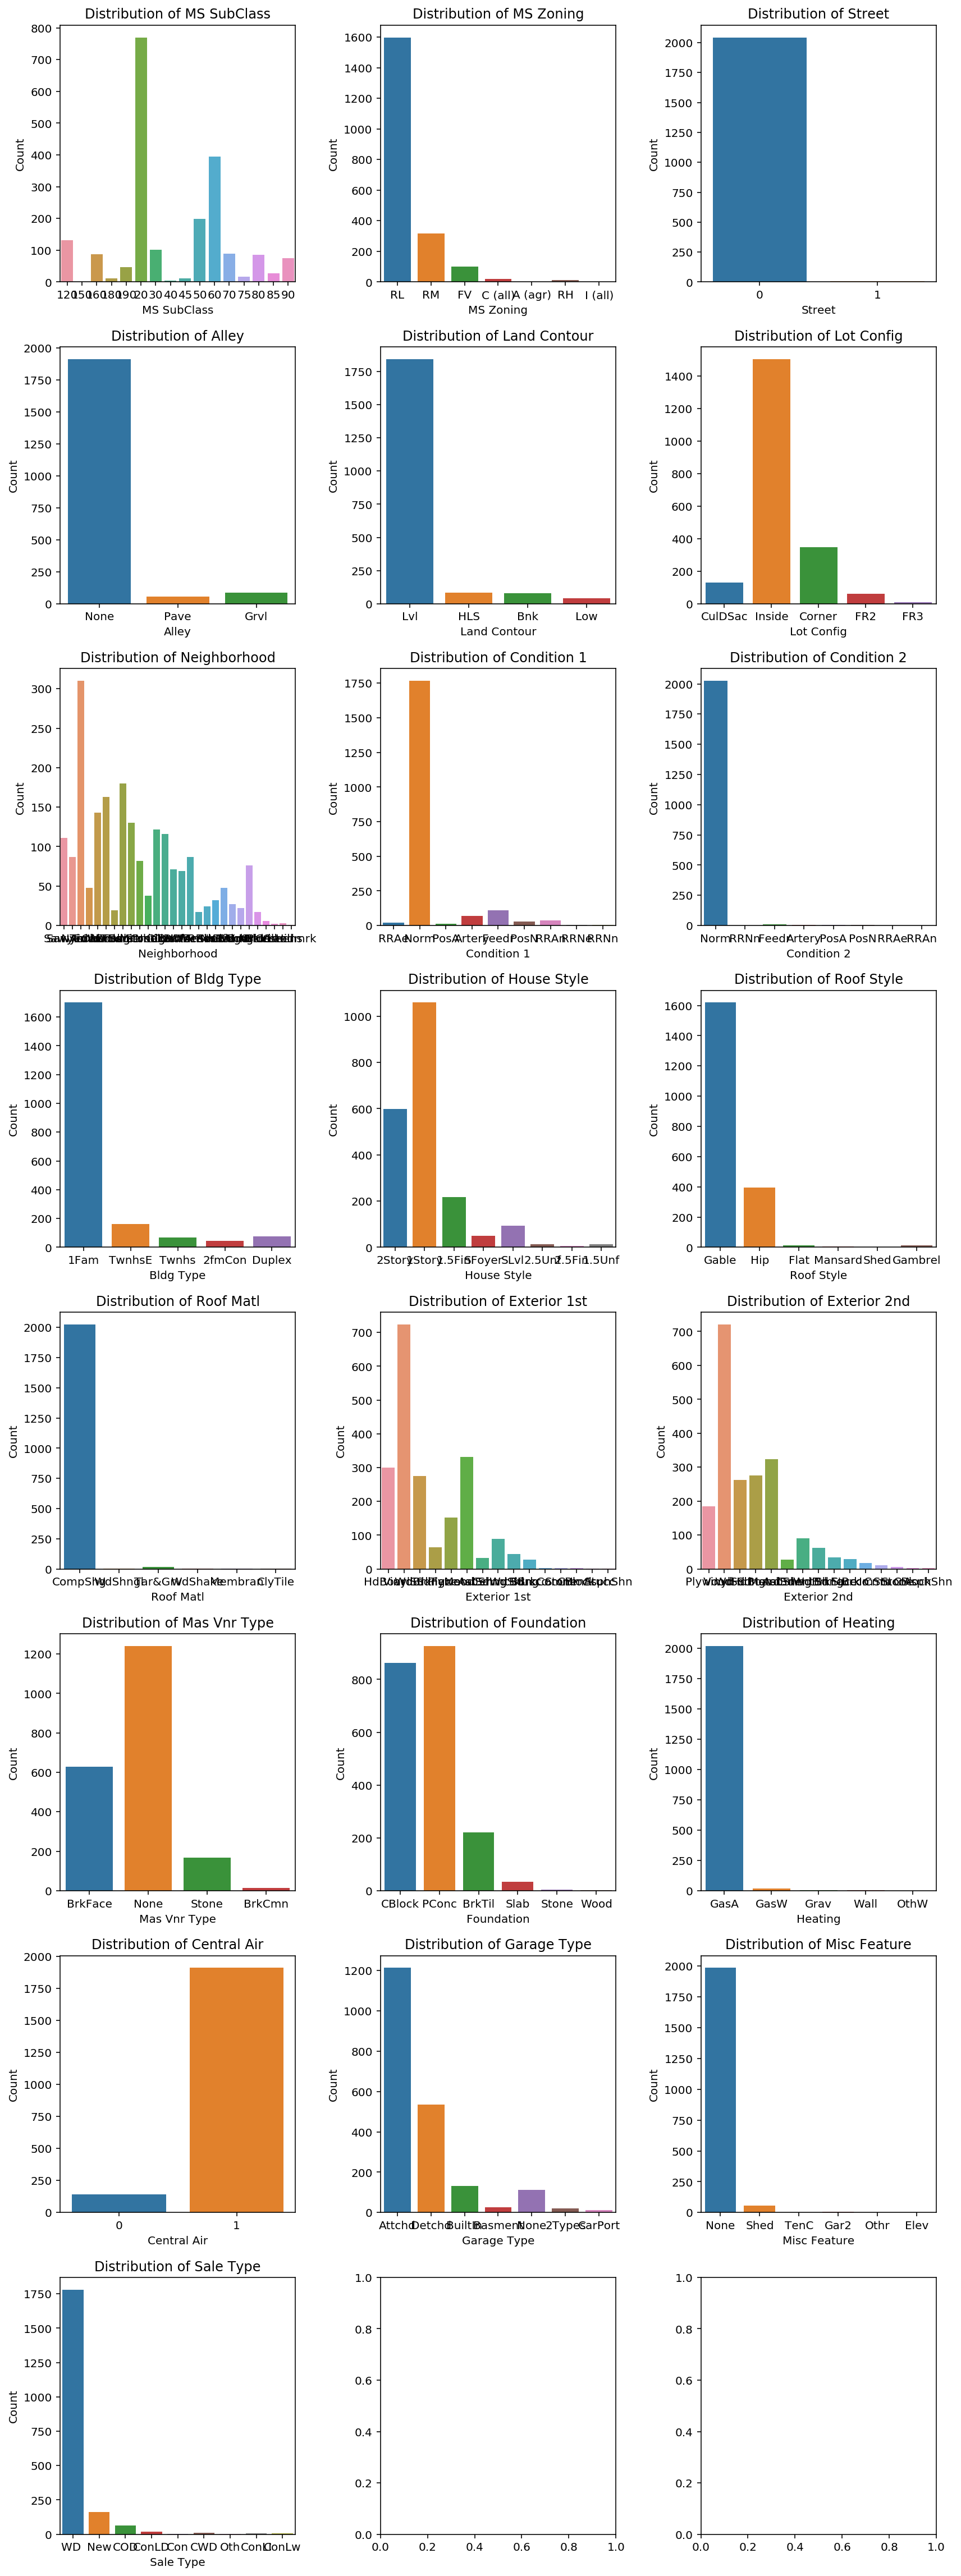

In [43]:
subplot_countplot(df,nominal)

In [ ]:
### Some of the more cluttered barplots don't have their x-axis labels done cleanly.
### Try rotating the x-axis labels if they take up too much (horizontal) space.

#### Distribution of SalePrice by Nominal Variables 

I test for independence between categorical and continuous variables using Student's T Test for 2 categories and Analysis of Variance (ANOVA) for more than two categories on each variable. I also run a multi-factor ANOVA with all nominal variables for comparison. The tests indicate that SalePrice is not independent of all or almost all the variables. They also suggest significant collinearity.

In [44]:
nom_vals = {s:list(df[s].unique()) for s in df[nominal].columns} #get list of unique values for nominal variables
del nom_vals['Street']
del nom_vals['Central Air']

In [45]:
#write to json
with open('../datasets/nominalvals.txt','w') as outfile:
    json.dump(nom_vals,outfile)

#### Individual T Test or One-way ANOVA Tests

In [46]:
def t_anova_test(df,cols, target,alpha=0.05): #def function to test each independent variable against SalePrice
    tmpdct = {}
    for col in cols:
        temp = list(df.groupby(col)[target].apply(list))
        if len(df[col].unique())==2:
            tmpdct[col]=ttest_ind(temp[0], temp[1], equal_var = False)[1]
        else:
            tmpdct[col]=f_oneway(*temp)[1]
    low_p = [key for key, val in tmpdct.items() if val<alpha]
    return low_p, tmpdct

low_p_nominal, p_vals_nominal = t_anova_test(df, nominal,'SalePrice')

#### Boxplots of variables where SalePrice is dependent

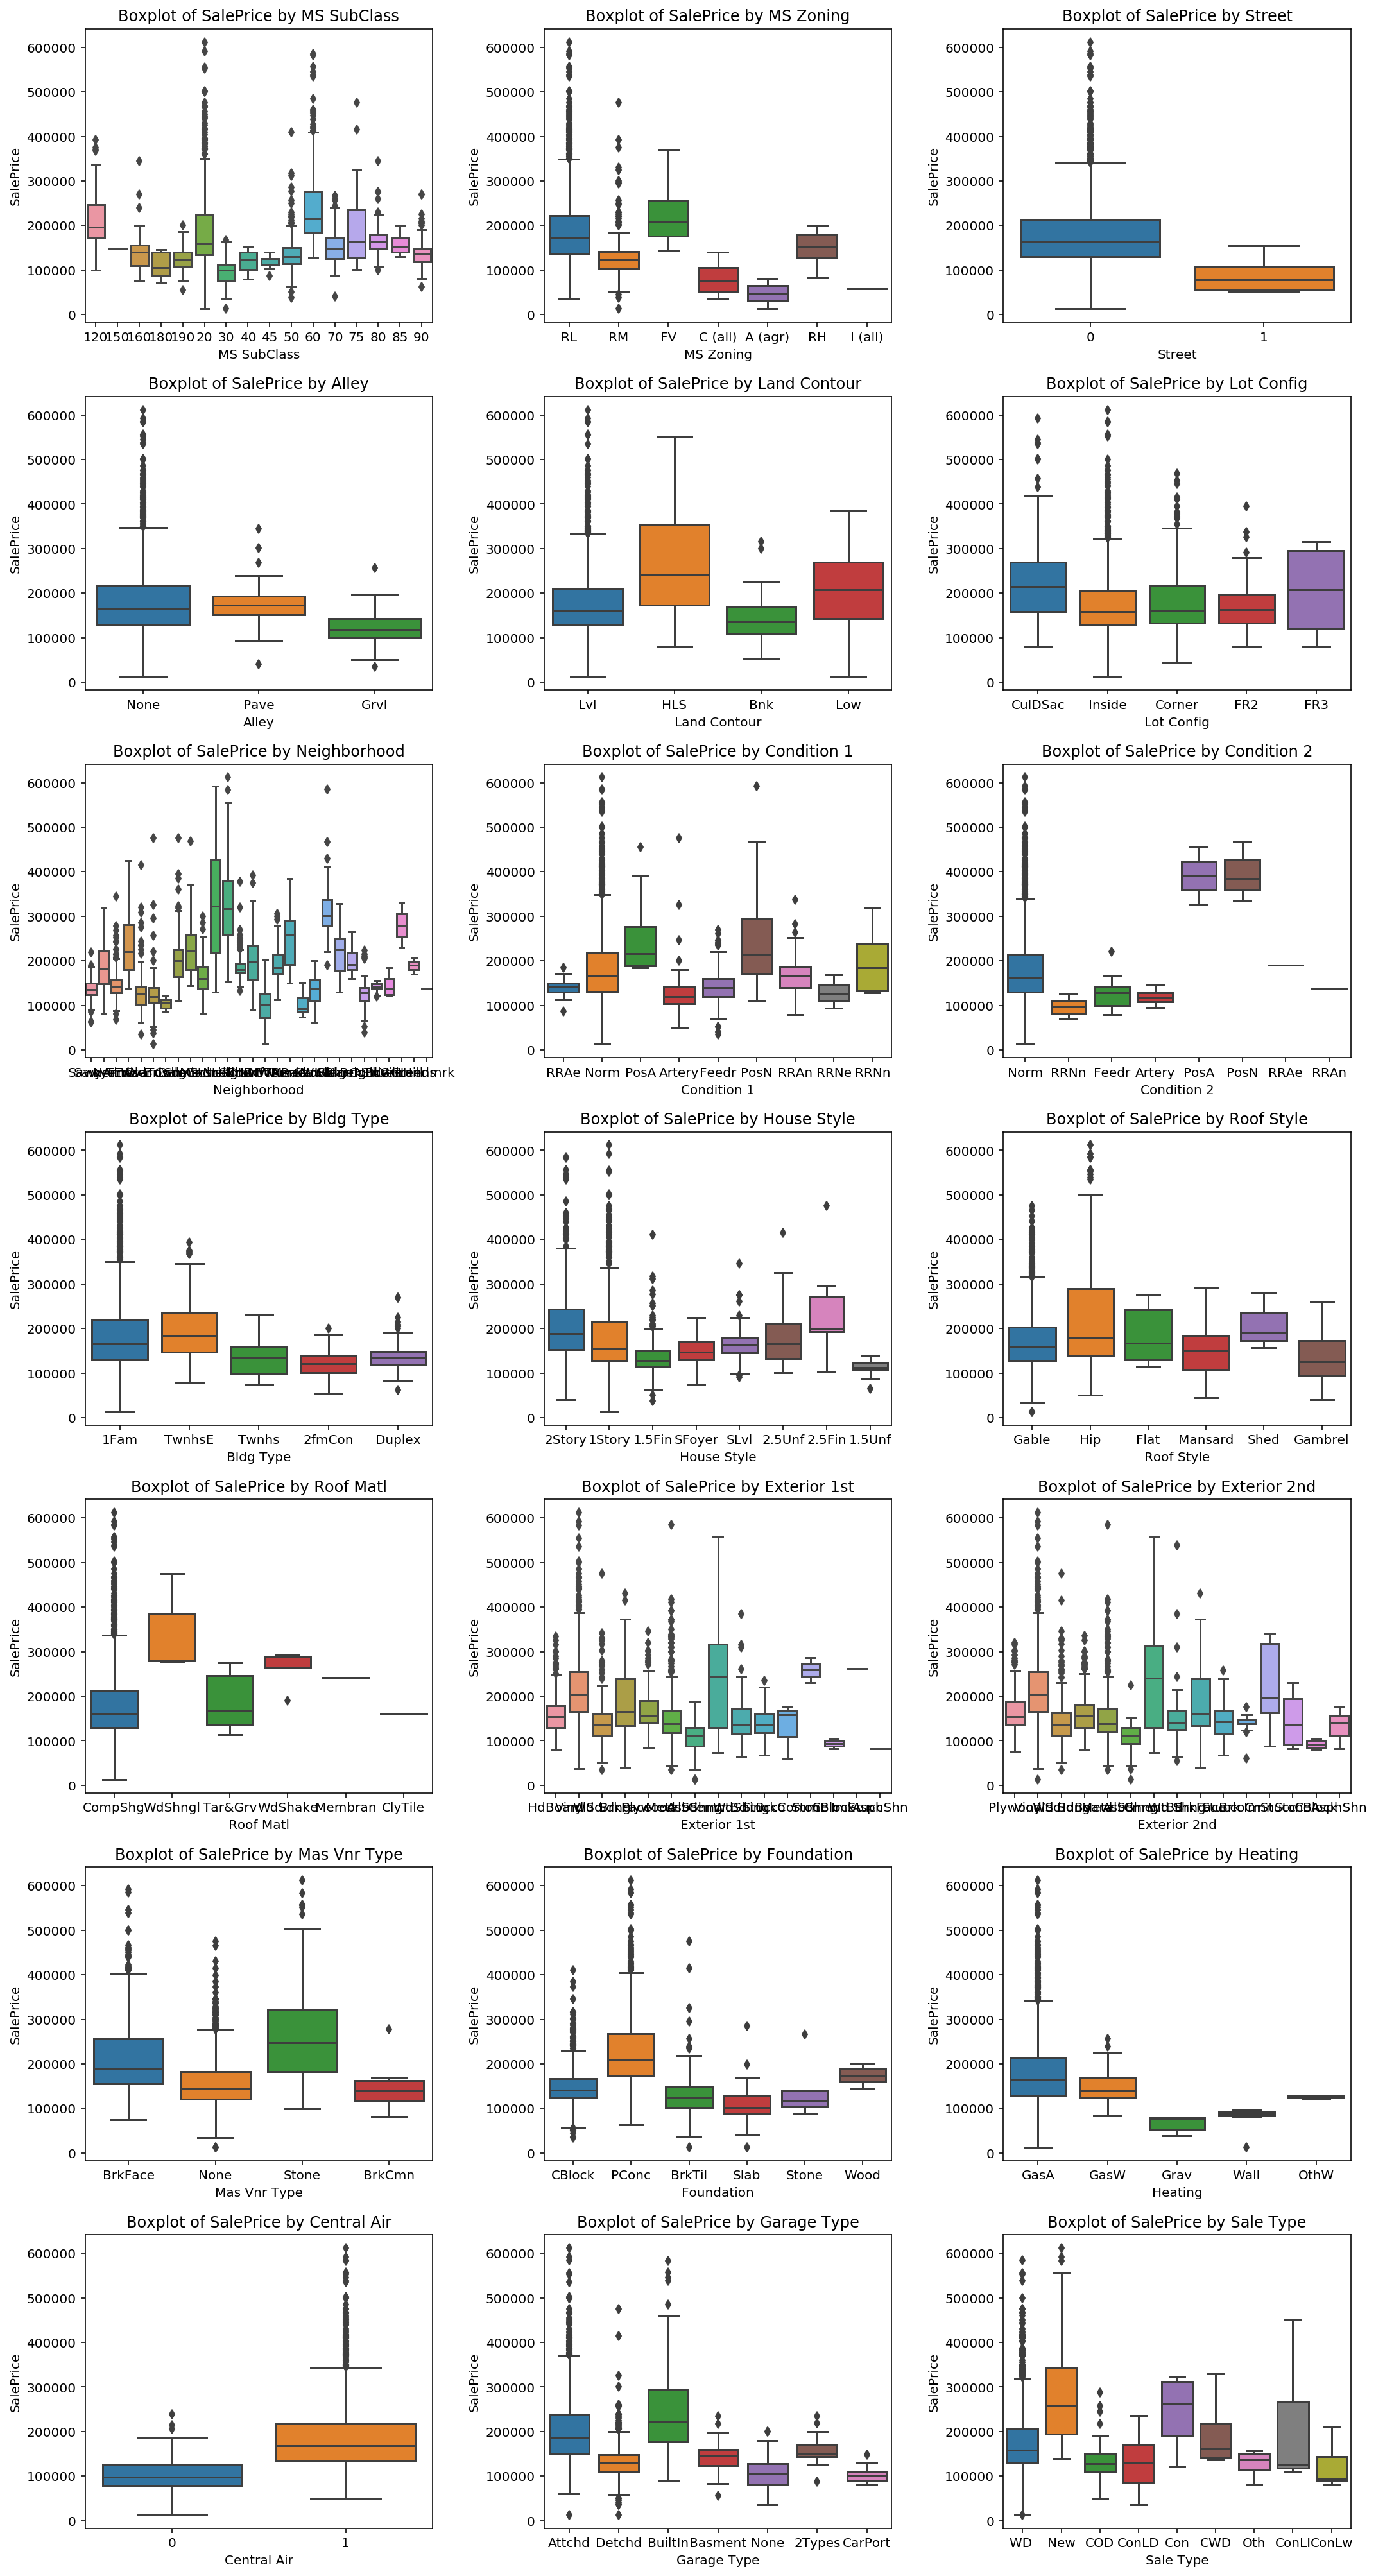

In [47]:
subplot_boxplot(df,low_p_nominal,'SalePrice')

#### N-Factor ANOVA 
The test run does not account for interactions.

In [76]:
formula = 'SalePrice ~ C(Q("'+ '"))+C(Q("'.join(nominal)+'"))'
model = ols(formula, df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     39.83
Date:                Sun, 24 Nov 2019   Prob (F-statistic):               0.00
Time:                        17:50:12   Log-Likelihood:                -24559.
No. Observations:                2049   AIC:                         4.942e+04
Df Residuals:                    1897   BIC:                         5.028e+04
Df Model:                         151                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                       -3.598e+04   6.54e+04     -0.550      0.583   -1.64e+05    9.24e+04
C(Q("MS SubClass"))[T.150]      -9940.0349   4.55e+04     -0.219      0.827   -9.91e+04    7.92e+04
C(Q("MS SubClass"))[T.160]      -8012.3968   1.26e+04     -0.638      0.523   -3.26e+04    1.66e+04
C(Q("MS SubClass"))[T.180]       2.483e+04   1.95e+04      1.277      0.202   -1.33e+04     6.3e+04
C(Q("MS SubClass"))[T.190]       6936.7302   3.71e+04      0.187      0.852   -6.57e+04    7.96e+04
C(Q("MS SubClass"))[T.20]        4.742e+04   2.11e+04      2.247      0.025    6025.931    8.88e+04
C(Q("MS SubClass"))[T.30]        2.467e+04   2.18e+04      1.131      0.258   -1.81e+04    6.75e+04
C(Q("MS SubClass"))[T.40]        4.046e+04      3e+04      1.349      0.178   -1.84e+04    9.93e+04
C(Q("MS SubClass"))[T.45]        6.055e+04   3.56e+04      1.701      0.089   -9268.373     1.3e+05
C(Q("MS SubClass"))[T.50]        4.067e+04   2.45e+04      1.657      0.098   -7469.652    8.88e+04
C(Q("MS SubClass"))[T.60]        5.011e+04   2.33e+04      2.150      0.032    4397.979    9.58e+04
C(Q("MS SubClass"))[T.70]         5.02e+04   2.37e+04      2.122      0.034    3800.493    9.66e+04
C(Q("MS SubClass"))[T.75]        8.941e+04   3.03e+04      2.954      0.003       3e+04    1.49e+05
C(Q("MS SubClass"))[T.80]        6.739e+04   2.77e+04      2.436      0.015    1.31e+04    1.22e+05
C(Q("MS SubClass"))[T.85]        5.431e+04   2.55e+04      2.127      0.034    4240.081    1.04e+05
C(Q("MS SubClass"))[T.90]        2.546e+04   1.11e+04      2.292      0.022    3677.451    4.72e+04
C(Q("MS Zoning"))[T.C (all)]      9.29e+04   4.29e+04      2.167      0.030    8840.319    1.77e+05
C(Q("MS Zoning"))[T.FV]          1.156e+05   4.28e+04      2.703      0.007    3.17e+04    1.99e+05
C(Q("MS Zoning"))[T.I (all)]     1.078e+05   6.15e+04      1.753      0.080   -1.28e+04    2.28e+05
C(Q("MS Zoning"))[T.RH]          1.363e+05   4.39e+04      3.107      0.002    5.02e+04    2.22e+05
C(Q("MS Zoning"))[T.RL]          1.103e+05   4.17e+04      2.643      0.008    2.85e+04    1.92e+05
C(Q("MS Zoning"))[T.RM]          1.088e+05   4.18e+04      2.605      0.009    2.69e+04    1.91e+05
C(Q("Street"))[T.1]             -1.079e+04   1.84e+04     -0.587      0.558   -4.69e+04    2.53e+04
C(Q("Alley"))[T.None]           -1482.4479   5569.460     -0.266      0.790   -1.24e+04    9440.462
C(Q("Alley"))[T.Pave]            2487.4358   8633.144      0.288      0.773   -1.44e+04    1.94e+04
C(Q("Land Contour"))[T.HLS]      2.869e+04   7211.861      3.979      0.000    1.45e+04    4.28e+04
C(Q("Land Contour"))[T.Low]      1.633e+04   8634.059      1.891      0.059    -605.796    3.33e+04
C(Q("Land Contour"))[T.Lvl]      2346.4668   5279.635      0.444      0.657   -8008

In [79]:
res = sm.stats.anova_lm(model, typ= 2)
res

sum_sq      df          F         PR(>F)
C(Q("MS SubClass"))   5.937435e+10    15.0   2.431702   1.625202e-03
C(Q("MS Zoning"))     2.124026e+10     6.0   2.174760   4.275753e-02
C(Q("Street"))        5.599352e+08     1.0   0.343986   5.576073e-01
C(Q("Alley"))         5.985559e+08     2.0   0.183856   8.320706e-01
C(Q("Land Contour"))  4.622936e+10     3.0   9.466717   3.302024e-06
C(Q("Lot Config"))    4.828295e+10     4.0   7.415434   6.339696e-06
C(Q("Neighborhood"))  1.569723e+12    27.0  35.715931  6.569442e-148
C(Q("Condition 1"))   3.276424e+10     8.0   2.516013   1.013482e-02
C(Q("Condition 2"))   2.254230e+10     7.0   1.978349   5.454664e-02
C(Q("Bldg Type"))     7.824186e+10     4.0  12.016608   1.204029e-09
C(Q("House Style"))   1.659738e+10     7.0   1.456613   1.784717e-01
C(Q("Roof Style"))    1.223924e+11     5.0  15.037903   1.659036e-14
C(Q("Roof Matl"))     6.230608e+10     4.0   9.569146   1.166460e-07
C(Q("Exterior 1st"))  1.134097e+11    14.0   4.976508   3.402674e-09
C(Q("Exterior 2nd"))  5.287047e+10    14.0   2.320000   3.622607e-03
C(Q("Mas Vnr Type"))  1.552984e+11     3.0  31.801558   4.709503e-20
C(Q("Foundation"))    9.083140e+10     5.0  11.160117   1.281463e-10
C(Q("Heating"))       1.161209e+10     4.0   1.783419   1.294764e-01
C(Q("Central Air"))   3.189161e+10     1.0  19.592016   1.013183e-05
C(Q("Garage Type"))   9.744091e+10     6.0   9.976836   7.190760e-11
C(Q("Misc Feature"))  7.377968e+09     4.0   1.133129   3.390642e-01
C(Q("Sale Type"))     5.726345e+10     8.0   4.397342   2.774883e-05
Residual              3.087910e+12  1897.0        NaN            NaN

In [92]:
res_lst = [i for i in res.index if res.loc[i,'PR(>F)']<0.05]
res_lst = [i.strip('C').strip('(').strip('Q').strip(')').strip('(').strip('"') for i in res_lst]
res_lst

['MS SubClass',
 'MS Zoning',
 'Land Contour',
 'Lot Config',
 'Neighborhood',
 'Condition 1',
 'Bldg Type',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Mas Vnr Type',
 'Foundation',
 'Central Air',
 'Garage Type',
 'Sale Type']

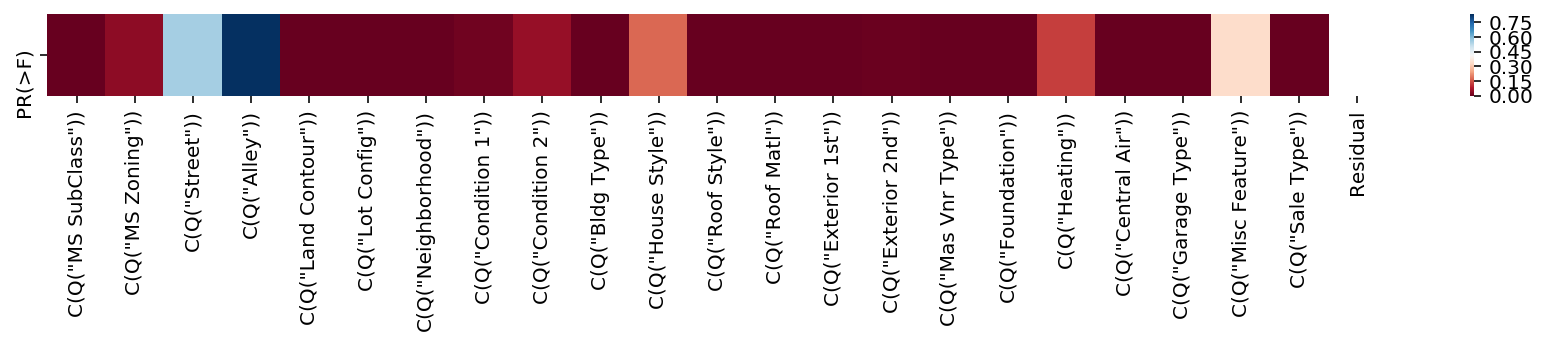

In [96]:
plt.subplots(1,figsize=(15,0.75))
sns.heatmap(res[['PR(>F)']].transpose(),cmap='RdBu');

#### Relationships between Nominal Variables

I run Chi-Square tests of independence between all nominal variables to check for possible dependencies between variables. According to the results, a large number of variables are not independent. However, "the Chi-Square value is extremely sensitive to sample size  ... \[and\] to the distribution within the cells. [(3)](https://www.statisticssolutions.com/using-chi-square-statistic-in-research/) Thus, these relationships may be artificial rather than real.

In [48]:
#write function to build a dataframe with probabilities of chi square test of independence 
def get_chi2_vals(df, alpha=0.05): 
    colbycol = list(combinations(df.columns,2)) #itertools, get combinations of column by column comparison
    tempdf = pd.DataFrame(np.nan, index=df.columns, columns=df.columns) #dataframe of null values
    templst = []
    for i in colbycol:
        xtab = pd.crosstab(df[i[0]],df[i[1]],margins=False) #create chi square contingency table
        chi2_stat, p_val, dof, ex = chi2_contingency(xtab) #call scipy.stats to run chi square test 
        tempdf.loc[i[1],i[0]]= p_val #write the p value to the dataframe
        if p_val<alpha:
            templst.append(i)
    tempdf.drop(df.columns[0],axis=0, inplace=True)
    tempdf.drop(df.columns[-1],axis=1, inplace=True)
    return tempdf,templst 
#returns a dataframe of the probabilities that can be used to plot a heatmap 
#and a list of the columns with probabilities less than alpha

In [49]:
chi2_prob, low_prob_lst = get_chi2_vals(df[nominal], alpha=0.05) #set a low alpha as the sample size is large
print(chi2_prob.shape, "No of associations:",len(low_prob_lst))

(21, 21) No of associations: 176


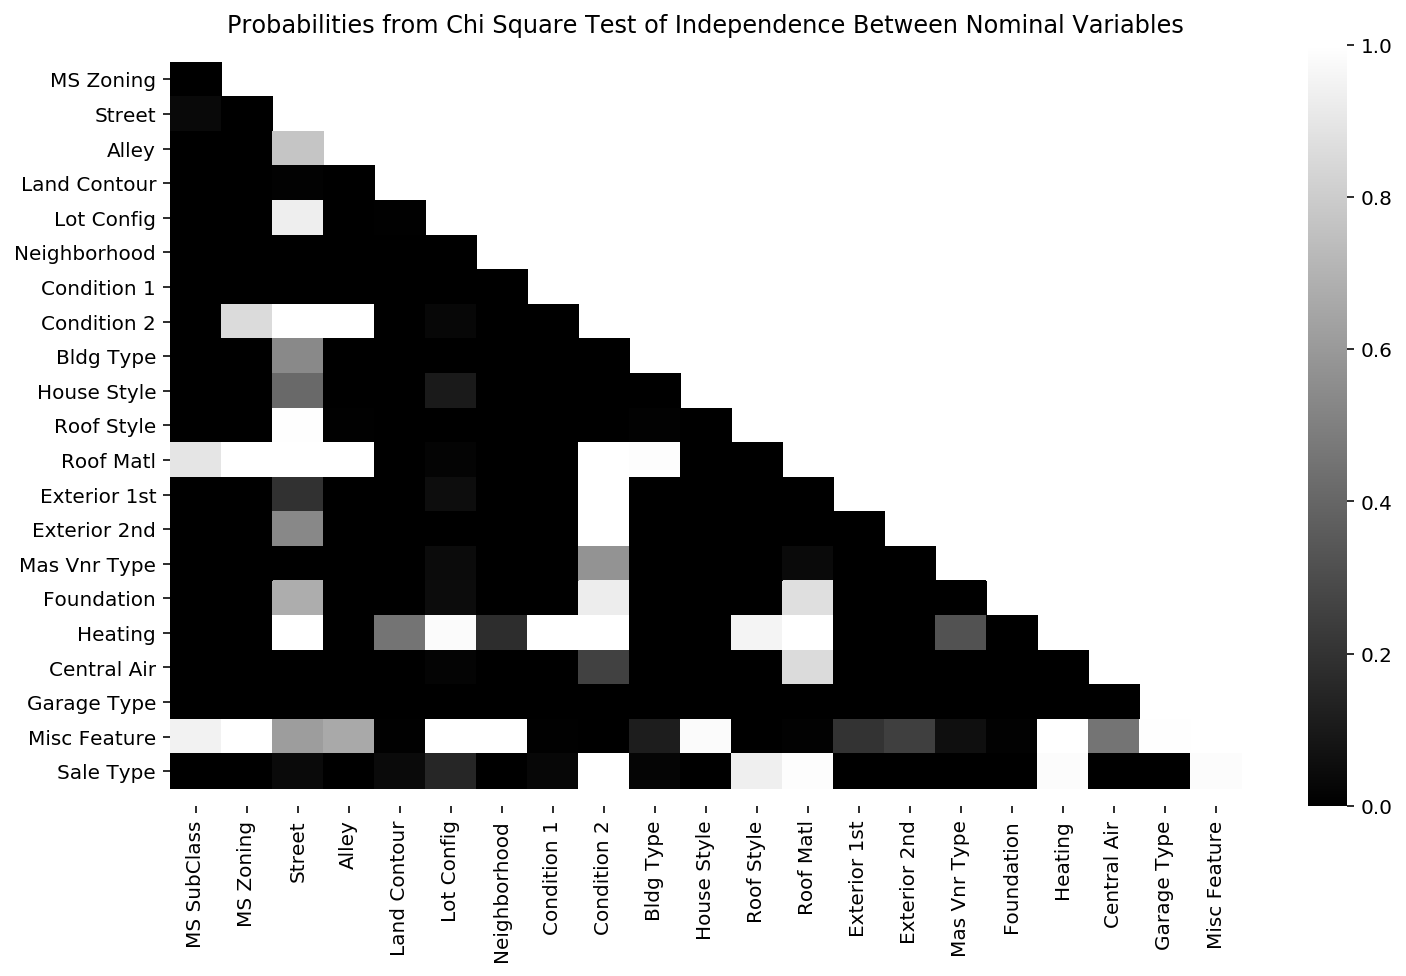

In [50]:
fig, ax = plt.subplots(1,figsize=(12,7));
sns.heatmap(chi2_prob,cmap='gray'); #plot heatmap
plt.title('Probabilities from Chi Square Test of Independence Between Nominal Variables');
ax.set_ylim(len(chi2_prob)+0.5, -0.5);

#### Which Pairs of Nominal Variables Have Possible Effect on SalePrice?

Since Chi-square has many pairs of variables that indicate dependency, I use two-way ANOVA to see how many of these their interactions have a relationship with the SalePrice.

In [51]:
#function to run two-factor ANOVA
def two_anova(df, col_pairs, target,alpha=0.05):
    warnings.filterwarnings("ignore") #a large number of warnings come up, the data may have issues
    dct = {}
    for cols in col_pairs:
        formula = target +' ~ C(Q("'+cols[0]+'"))*C(Q("'+cols[1]+'"))'
        model = ols(formula, df).fit()
        res = sm.stats.anova_lm(model, typ= 2)
        dct[cols]=(res.iloc[2,2],res.iloc[2,3]) #get interaction factor only
    warnings.resetwarnings()
    results = pd.DataFrame(dct).transpose().reset_index()
    results.columns = ['Col1','Col2','F','p']
    results = results[results.p < alpha] 
    return results 
compare = two_anova(df, low_prob_lst, 'SalePrice')
compare.head()

Col1          Col2          F              p
0  MS SubClass     MS Zoning  12.871040   7.925706e-75
2  MS SubClass         Alley  16.736797   1.269429e-65
3  MS SubClass  Land Contour   3.685846   1.622686e-10
4  MS SubClass    Lot Config   1.647795   1.004208e-02
5  MS SubClass  Neighborhood  14.259600  8.187636e-203

In [52]:
cols = set(pd.concat([compare.Col1,compare.Col2],axis=0))
cols = {list(cols)[i]:i+1 for i in range(len(cols))} #dictionary of unique column names 

In [53]:
#convert dataframe to Gephi import (edges) format, export
compare.columns = ['Source','Target','F','p']
compare = compare.replace(cols)
compare['Type']='Undirected'
compare = compare[['Source','Target','Type','F','p']]
compare.to_csv('../datasets/links.csv',index=False)
compare.head()

Source  Target        Type          F              p
0      21       8  Undirected  12.871040   7.925706e-75
2      21      11  Undirected  16.736797   1.269429e-65
3      21      15  Undirected   3.685846   1.622686e-10
4      21      18  Undirected   1.647795   1.004208e-02
5      21      12  Undirected  14.259600  8.187636e-203

In [54]:
#convert list of columns to Gephi import (nodes) format, expor
cols = pd.DataFrame(cols, index=[0]).transpose().reset_index()
cols.columns = ['Label','Id']
cols = cols[['Id',"Label"]]
cols.to_csv('../datasets/id.csv',index=False)
cols.head()

Id         Label
0   1        Street
1   2   Garage Type
2   3  Misc Feature
3   4   Central Air
4   5       Heating

Gephi was used to graph the variables and their pairwise interactions' possible relationships to to SalePrice. An interactive visual exploration of the variables was used to see which variables may require feature engineering. A darker purple line represents a higher F-statistic.

<div>
<img src="../images/graphnominal.png" width="600"/>
</div>


In [ ]:
### Not an incredibly useful visualisation.
### Might be better to just print pairwise correlated. 

### Interdependencies

The steps below analyses the possible correlations using Pearson's correlation coefficient, spearman's rank-order correlation coefficient, and Kruskal_Wallis H Test[(4)](https://statistics.laerd.com/spss-tutorials/kruskal-wallis-h-test-using-spss-statistics.php).

In [55]:
#combinations of the different variable types
print(list(combinations(['low_p_nominal','xvars_con','xvars_dis','xvars_ord'],2)))

[('low_p_nominal', 'xvars_con'), ('low_p_nominal', 'xvars_dis'), ('low_p_nominal', 'xvars_ord'), ('xvars_con', 'xvars_dis'), ('xvars_con', 'xvars_ord'), ('xvars_dis', 'xvars_ord')]


In [56]:
features = low_p_nominal

In [57]:
con_dis = list(product(xvars_con, xvars_dis)) #create list for continuous vs discrete
pair_dict = {pair: pearsonr(df[pair[0]],df[pair[1]]) #run pearson
             for pair in con_dis if pearsonr(df[pair[0]],df[pair[1]])[1]<0.05}

ord_num = list(product(xvars_con, xvars_ord)) #creat list for ordinal vs numeric
ord_num.extend(list(product(xvars_dis, xvars_ord)))
pair_dict.update({pair: spearmanr(df[pair[0]],df[pair[1]]) #run spearman
                  for pair in ord_num if spearmanr(df[pair[0]],df[pair[1]])[1]<0.05})

nom_other = list(product(low_p_nominal, xvars_con)) #create list for nominal vs others
nom_other.extend(list(product(low_p_nominal, xvars_dis)))
nom_other.extend(list(product(low_p_nominal, xvars_ord)))
def kruskal_test(pairs,df, alpha=0.05): #function to run Kruskal H Test on multiple
    tmpdct = {}
    for pair in pairs:
        temp = list(df.groupby(pair[0])[pair[1]].apply(list)) #group target
        tmpdct[pair]=tuple(kruskal(*temp)) 
    tmpdct = {key: val for key, val in tmpdct.items() if val[1]<alpha} #keep if p<alpha
    return tmpdct

pair_dict.update(kruskal_test(nom_other,df))

#### Visualizing Result

In [58]:
#export to Gephi import format
dependences = pd.DataFrame(pair_dict).transpose().reset_index()
dependences.columns = ['Source','Target','Stat','p']
dependences['Type']='Undirected'
dependences = dependences[['Source','Target','Type','Stat','p']]
dep_code = pd.DataFrame(set(pd.concat([dependences.Source,dependences.Target],axis=0)))
dep_code['Id'] = [i+1 for i in range(len(dep_code))]
dep_code = dep_code[['Id',0]]
dep_code.columns = ['Id','Label']
dep_code.to_csv('../datasets/id_inter.csv',index=False)
dep_code = {dep_code.iloc[i,1]:dep_code.iloc[i,0] for i in range(len(dep_code))} #dictionary of unique column names #))
dependences = dependences.replace(dep_code)
dependences.to_csv('../datasets/links_inter.csv',index=False)

## Final Preparation for Modelling

#### Remove True Outliers

Based on the EDA and information in the documentation, I remove houses with Gr Liv Area above 4000.

In [59]:
df[df['Gr Liv Area']>4000]

MS SubClass MS Zoning  Lot Frontage  Lot Area  Street Alley  Lot Shape  \
960           60        RL           313     63887       0  None          0   
1885          20        RL           128     39290       0  None          2   

     Land Contour  Utilities Lot Config  ...  Screen Porch Pool Area Pool QC  \
960           Bnk          3     Corner  ...             0       480       4   
1885          Bnk          3     Inside  ...             0         0       0   

     Fence Misc Feature Misc Val  Mo Sold  Yr Sold  Sale Type  SalePrice  
960      0         None        0        1     2008        New     160000  
1885     0         Elev    17000       10     2007        New     183850  

[2 rows x 79 columns]

In [60]:
df.drop([960,1885],axis=0, inplace=True)

In [61]:
df.shape

(2049, 79)

#### Edit Data Dictionary

In [62]:
#edit data dictionary
data_dict.DataType = data_dict.DataType.str.replace('float','int')
data_dict.loc['MS SubClass','DataType']='object'
data_dict.loc[ordinal,'DataType'] = 'int'
data_dict.loc[['Central Air','Street'],'DataType'] = 'int'
data_dict.head()

DataType TypeDescription Dataset  \
Feature                                         
MS SubClass    object         Nominal    Ames   
MS Zoning      object         Nominal    Ames   
Lot Frontage      int      Continuous    Ames   
Lot Area          int      Continuous    Ames   
Street            int         Nominal    Ames   

                                                    Description  
Feature                                                          
MS SubClass   Identifies the type of dwelling involved in th...  
MS Zoning     Identifies the general zoning classification o...  
Lot Frontage        Linear feet of street connected to property  
Lot Area                                Lot size in square feet  
Street                          Type of road access to property

In [63]:
#export text file with data dictionary after sorting
with open('../datasets/datadict.txt','w+') as f:
    f.write(tabulate(data_dict, tablefmt="pipe", headers="keys")) #to retrieve for markdown

#### Write Training Data to CSV

In [64]:
data_dict.to_csv('../datasets/datadict.csv') #data dictionary 
df.to_csv('../datasets/final.csv',index=False) #data

In [65]:
features = [low_p_nominal+xvars_con+xvars_dis+xvars_ord] #features with impact on price
with open('../datasets/features1.csv','w+') as f:
    wr = csv.writer(f, dialect='excel')
    wr.writerows(features)

In [93]:
features = [res_lst+xvars_con+xvars_dis+xvars_ord] #features with impact on price
with open('../datasets/features2.csv','w+') as f:
    wr = csv.writer(f, dialect='excel')
    wr.writerows(features)

#### Data Cleaning for Unknown Test Data

Data cleaning is performed to ensure that the test data is similar in structure to the training data. 

In [66]:
new_df = pd.read_csv('../datasets/test.csv').drop(['Id','PID'],axis=1)
new_df['MS SubClass'] = new_df['MS SubClass'].astype(str)
new_df.head()

MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley Lot Shape  \
0         190        RM          69.0      9142   Pave  Grvl       Reg   
1          90        RL           NaN      9662   Pave   NaN       IR1   
2          60        RL          58.0     17104   Pave   NaN       IR1   
3          30        RM          60.0      8520   Pave   NaN       Reg   
4          20        RL           NaN      9500   Pave   NaN       IR1   

  Land Contour Utilities Lot Config  ... 3Ssn Porch Screen Porch Pool Area  \
0          Lvl    AllPub     Inside  ...          0            0         0   
1          Lvl    AllPub     Inside  ...          0            0         0   
2          Lvl    AllPub     Inside  ...          0            0         0   
3          Lvl    AllPub     Inside  ...          0            0         0   
4          Lvl    AllPub     Inside  ...          0          185         0   

  Pool QC Fence Misc Feature  Misc Val  Mo Sold  Yr Sold  Sale Type  
0     NaN   NaN          NaN         0        4     2006        WD   
1     NaN   NaN          NaN         0        8     2006        WD   
2     NaN   NaN          NaN         0        9     2006        New  
3     NaN   NaN          NaN         0        7     2007        WD   
4     NaN   NaN          NaN         0        7     2009        WD   

[5 rows x 78 columns]

In [67]:
nums_list = list(nums.index) #get the list of numeric variables
nums_list.remove('SalePrice')
new_df = impute_zero(new_df,nums_list) #run function

In [68]:
new_df['Electrical'] = new_df['Electrical'].fillna(value='-1') #Electrical has a null value
#map ordinal variables to numbers
new_df[qualities] = new_df[qualities].replace(ord_val_map['qualities']).astype('int') #replace
new_df[bsmt] = new_df[bsmt].replace(ord_val_map['bsmtfintype']).astype('int') #replace
new_df[ord_map_list] = new_df[ord_map_list].apply(lambda x: replace_ords(x,ord_val_map))
#after mapping, replace the neg value with median to ensure the variable is still an integer
new_df.Electrical = new_df.Electrical.replace({-1:int(np.median(new_df.Electrical))}) 

In [69]:
new_df.Street = new_df.Street.replace({'Pave':0,'Grvl':1}).astype('int') #replace binary categorical variables
new_df['Central Air'] = new_df['Central Air'].replace({'N':0,'Y':1}).astype('int')
new_df = new_df.fillna(value='None',axis=1)#fill the rest of the NaN values

In [70]:
new_df.head()

MS SubClass MS Zoning  Lot Frontage  Lot Area  Street Alley  Lot Shape  \
0          190        RM            69      9142       0  Grvl          3   
1           90        RL             0      9662       0  None          2   
2           60        RL            58     17104       0  None          2   
3           30        RM            60      8520       0  None          3   
4           20        RL             0      9500       0  None          2   

  Land Contour  Utilities Lot Config  ...  3Ssn Porch Screen Porch Pool Area  \
0          Lvl          3     Inside  ...           0            0         0   
1          Lvl          3     Inside  ...           0            0         0   
2          Lvl          3     Inside  ...           0            0         0   
3          Lvl          3     Inside  ...           0            0         0   
4          Lvl          3     Inside  ...           0          185         0   

  Pool QC Fence Misc Feature  Misc Val  Mo Sold  Yr Sold  Sale Type  
0       0     0         None         0        4     2006        WD   
1       0     0         None         0        8     2006        WD   
2       0     0         None         0        9     2006        New  
3       0     0         None         0        7     2007        WD   
4       0     0         None         0        7     2009        WD   

[5 rows x 78 columns]

In [71]:
new_df.isnull().sum().sort_values(ascending=False) #final check for null values

Sale Type        0
Foundation       0
Roof Matl        0
Exterior 1st     0
Exterior 2nd     0
                ..
Kitchen Qual     0
TotRms AbvGrd    0
Functional       0
Fireplaces       0
MS SubClass      0
Length: 78, dtype: int64

#### Write to CSV

In [72]:
new_df.to_csv('../datasets/test_final.csv',index=False) #write data

# Project 2 - Ames Housing Data and Kaggle Challenge

## Problem Statement

I work for a company specializing in technology for the real estate industry. Our goal is to connect home buyers, sellers and property agents with each other, while making the property selection and transaction proces seamless for all involved. Our company is looking into expanding our business into the city of Ames, and as such has collected data on previous property transactions from the city administration. One of the pain points of home buyers and sellers is not knowing how much a property is worth, which can cause extended negotiations and extra costs of hiring surveyors. Our company wants to build a model to estimate prices that our customers can use as a baseline for their negotiations.  

# Feature Selection and Modelling

This notebook details the steps used in feature selection, feature engineering and modelling.

### Contents:
1. [Libraries Used](#Libraries)
2. [Data Pre-processing](#Data-Pre-processing)
3. [Modelling](#Modelling-Process)
    - [All Features](#Regression-Model:-All-Features)
    - [Features Correlated with Sale Price](#Regression-Model:-All-Features-Correlated-with-SalePrice)
    - [Polynomial Features Correlated with Sale Price](#Regression-Model:-Polynomial-Features-from-Correlated-Features)
    - [Grouped Features](#Regression-Model:-Grouped-Features)
4. [Predict New Data](#Run-Model-on-Prediction-Data)
5. [Conclusion and Recommendation](#Conclusion-and-Recommendation)
6. [Appendix](#Appendix)

## Libraries

In [1]:
#imports
import csv, json
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_selection import RFE,RFECV
from sklearn.linear_model import Ridge, Lasso, LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

### Import Data

In [2]:
df = pd.read_csv('../datasets/final.csv')
df['MS SubClass'] = df['MS SubClass'].astype('str')
print(df.shape)
df.head()

(2049, 79)


MS SubClass MS Zoning  Lot Frontage  Lot Area  Street Alley  Lot Shape  \
0          60        RL             0     13517       0  None          2   
1          60        RL            43     11492       0  None          2   
2          20        RL            68      7922       0  None          3   
3          60        RL            73      9802       0  None          3   
4          50        RL            82     14235       0  None          2   

  Land Contour  Utilities Lot Config  ...  Screen Porch Pool Area Pool QC  \
0          Lvl          3    CulDSac  ...             0         0       0   
1          Lvl          3    CulDSac  ...             0         0       0   
2          Lvl          3     Inside  ...             0         0       0   
3          Lvl          3     Inside  ...             0         0       0   
4          Lvl          3     Inside  ...             0         0       0   

  Fence Misc Feature Misc Val  Mo Sold  Yr Sold  Sale Type  SalePrice  
0     0         None        0        3     2010        WD      130500  
1     0         None        0        4     2009        WD      220000  
2     0         None        0        1     2010        WD      109000  
3     0         None        0        4     2010        WD      174000  
4     0         None        0        3     2010        WD      138500  

[5 rows x 79 columns]

#### Data Dictionary

Next, read in the data dictionary.

In [3]:
datadict = pd.read_csv('../datasets/datadict.csv')
datadict.head()

Feature DataType TypeDescription Dataset  \
0   MS SubClass   object         Nominal    Ames   
1     MS Zoning   object         Nominal    Ames   
2  Lot Frontage      int      Continuous    Ames   
3      Lot Area      int      Continuous    Ames   
4        Street      int         Nominal    Ames   

                                         Description  
0  Identifies the type of dwelling involved in th...  
1  Identifies the general zoning classification o...  
2        Linear feet of street connected to property  
3                            Lot size in square feet  
4                    Type of road access to property

## Data Pre-processing

Having performed exploratory data analysis on the dataset. We now turn to processing the data for model building. This section records the steps taken that is common across all models tested.

### Training Data

#### One Hot Encoding Categorical Variables

The categorical variables will need to be changed to numerical values for linear models to be run, by creating dummy values.

In [4]:
dummies = df[datadict[datadict.DataType=='object']['Feature']] #create data frame for columns to be dummied
dummied_df = pd.get_dummies(dummies) #dummy the values
dummied_df.rename(columns={"Exterior 2nd_Brk Cmn": "Exterior 2nd_BrkComm"},inplace=True) #make consistent
#when using dummy variables, to drop one category for each variable (based on documentation)
dummy_drops = ['MS SubClass_190','MS Zoning_A (agr)','Alley_None','Land Contour_Lvl','Lot Config_Inside',
               'Neighborhood_StoneBr','Condition 1_Norm','Condition 2_Norm','House Style_SLvl','Roof Style_Shed',
              'Roof Matl_WdShngl','Exterior 1st_WdShing','Exterior 2nd_Wd Shng','Mas Vnr Type_None','Foundation_Wood',
              'Heating_Wall','Garage Type_None','Misc Feature_None','Sale Type_Oth']
dummied_df.head()

MS SubClass_120  MS SubClass_150  MS SubClass_160  MS SubClass_180  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   MS SubClass_190  MS SubClass_20  MS SubClass_30  MS SubClass_40  \
0                0               0               0               0   
1                0               0               0               0   
2                0               1               0               0   
3                0               0               0               0   
4                0               0               0               0   

   MS SubClass_45  MS SubClass_50  ...  Misc Feature_TenC  Sale Type_COD  \
0               0               0  ...                  0              0   
1               0               0  ...                  0              0   
2               0               0  ...                  0              0   
3               0               0  ...                  0              0   
4               0               1  ...                  0              0   

   Sale Type_CWD  Sale Type_Con  Sale Type_ConLD  Sale Type_ConLI  \
0              0              0                0                0   
1              0              0                0                0   
2              0              0                0                0   
3              0              0                0                0   
4              0              0                0                0   

   Sale Type_ConLw  Sale Type_New  Sale Type_Oth  Sale Type_WD   
0                0              0              0              1  
1                0              0              0              1  
2                0              0              0              1  
3                0              0              0              1  
4                0              0              0              1  

[5 rows x 170 columns]

In [5]:
#concatenate with the main dataframe and remove the columns which have been dummied
df = pd.concat([df.drop(dummies.columns,axis=1),dummied_df.drop(dummy_drops,axis=1)],axis=1)
df = df.astype('int')
df.head()

Lot Frontage  Lot Area  Street  Lot Shape  Utilities  Land Slope  \
0             0     13517       0          2          3           2   
1            43     11492       0          2          3           2   
2            68      7922       0          3          3           2   
3            73      9802       0          3          3           2   
4            82     14235       0          2          3           2   

   Overall Qual  Overall Cond  Year Built  Year Remod/Add  ...  \
0             6             8        1976            2005  ...   
1             7             5        1996            1997  ...   
2             5             7        1953            2007  ...   
3             5             5        2006            2007  ...   
4             6             8        1900            1993  ...   

   Misc Feature_Shed  Misc Feature_TenC  Sale Type_COD  Sale Type_CWD  \
0                  0                  0              0              0   
1                  0                  0              0              0   
2                  0                  0              0              0   
3                  0                  0              0              0   
4                  0                  0              0              0   

   Sale Type_Con  Sale Type_ConLD  Sale Type_ConLI  Sale Type_ConLw  \
0              0                0                0                0   
1              0                0                0                0   
2              0                0                0                0   
3              0                0                0                0   
4              0                0                0                0   

   Sale Type_New  Sale Type_WD   
0              0              1  
1              0              1  
2              0              1  
3              0              1  
4              0              1  

[5 rows x 210 columns]

#### Year Variables

Years are discrete variables that don't scale well in  linear models. We create an 'Age' feature for the building based on the available: 'Year Built', 'Year Remod/Add', 'Garage Yr Blt', by subtracting from the 'Yr Sold'.

In [6]:
df['house_age']=df['Yr Sold']-df['Year Built']
df['yrs_since_remod']=df['Yr Sold']-df['Year Remod/Add']
df['was_remod']=[1 if df.loc[x,'Yr Sold']!=df.loc[x,'Year Remod/Add'] else 0 for x in df.index]
df['garage_age']=[df.loc[x,'Yr Sold'] - df.loc[x,'Garage Yr Blt'] if df.loc[x,'Garage Yr Blt']!=0 else 0 for x in df.index]
df[['garage_age','Garage Yr Blt']].head() #check values

### I'm not sure if this will help significantly, since it's just a linear rescaling. You'll do this anyway 
### later via StandardScalar.

garage_age  Garage Yr Blt
0          34           1976
1          12           1997
2          57           1953
3           3           2007
4          53           1957

In [7]:
df.drop(['Yr Sold','Year Built','Year Remod/Add','Garage Yr Blt'],axis=1,inplace=True) #don't need these any more

### Import Prediction Data
We import the new data and use the same data cleaning methods.

In [8]:
unk_df = pd.read_csv('../datasets/test_final.csv') # read in data
unk_df['MS SubClass'] = unk_df['MS SubClass'].astype('str')
print(unk_df.shape)
unk_df.head()

(879, 78)


MS SubClass MS Zoning  Lot Frontage  Lot Area  Street Alley  Lot Shape  \
0         190        RM            69      9142       0  Grvl          3   
1          90        RL             0      9662       0  None          2   
2          60        RL            58     17104       0  None          2   
3          30        RM            60      8520       0  None          3   
4          20        RL             0      9500       0  None          2   

  Land Contour  Utilities Lot Config  ...  3Ssn Porch Screen Porch Pool Area  \
0          Lvl          3     Inside  ...           0            0         0   
1          Lvl          3     Inside  ...           0            0         0   
2          Lvl          3     Inside  ...           0            0         0   
3          Lvl          3     Inside  ...           0            0         0   
4          Lvl          3     Inside  ...           0          185         0   

  Pool QC Fence Misc Feature  Misc Val  Mo Sold  Yr Sold  Sale Type  
0       0     0         None         0        4     2006        WD   
1       0     0         None         0        8     2006        WD   
2       0     0         None         0        9     2006        New  
3       0     0         None         0        7     2007        WD   
4       0     0         None         0        7     2009        WD   

[5 rows x 78 columns]

#### Dummy Variables

In [9]:
unk_dummies = unk_df[datadict[datadict.DataType=='object']['Feature']] #create data frame for columns to be dummied
dummied_unk = pd.get_dummies(unk_dummies) #dummy the values
dummied_unk.rename(columns={"Exterior 2nd_Brk Cmn": "Exterior 2nd_BrkComm"},inplace=True) #make consistent
dummied_unk.head()

MS SubClass_120  MS SubClass_160  MS SubClass_180  MS SubClass_190  \
0                0                0                0                1   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   MS SubClass_20  MS SubClass_30  MS SubClass_40  MS SubClass_45  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               1               0               0   
4               1               0               0               0   

   MS SubClass_50  MS SubClass_60  ...  Sale Type_COD  Sale Type_CWD  \
0               0               0  ...              0              0   
1               0               0  ...              0              0   
2               0               1  ...              0              0   
3               0               0  ...              0              0   
4               0               0  ...              0              0   

   Sale Type_Con  Sale Type_ConLD  Sale Type_ConLI  Sale Type_ConLw  \
0              0                0                0                0   
1              0                0                0                0   
2              0                0                0                0   
3              0                0                0                0   
4              0                0                0                0   

   Sale Type_New  Sale Type_Oth  Sale Type_VWD  Sale Type_WD   
0              0              0              0              1  
1              0              0              0              1  
2              1              0              0              0  
3              0              0              0              1  
4              0              0              0              1  

[5 rows x 162 columns]

In [10]:
unk_dummy_drops = dummy_drops.copy()

In [11]:
unk_dummy_drops.remove('MS Zoning_A (agr)') #these values were not present
unk_dummy_drops.remove('Heating_Wall')

In [12]:
#concatenate with the main dataframe and remove the columns which have been dummied
unk_df = pd.concat([unk_df.drop(unk_dummies.columns,axis=1),dummied_unk.drop(unk_dummy_drops,axis=1)],axis=1)
unk_df = unk_df.astype('int')
unk_df.head()

Lot Frontage  Lot Area  Street  Lot Shape  Utilities  Land Slope  \
0            69      9142       0          3          3           2   
1             0      9662       0          2          3           2   
2            58     17104       0          2          3           2   
3            60      8520       0          3          3           2   
4             0      9500       0          2          3           2   

   Overall Qual  Overall Cond  Year Built  Year Remod/Add  ...  \
0             6             8        1910            1950  ...   
1             5             4        1977            1977  ...   
2             7             5        2006            2006  ...   
3             5             6        1923            2006  ...   
4             6             5        1963            1963  ...   

   Misc Feature_Shed  Sale Type_COD  Sale Type_CWD  Sale Type_Con  \
0                  0              0              0              0   
1                  0              0              0              0   
2                  0              0              0              0   
3                  0              0              0              0   
4                  0              0              0              0   

   Sale Type_ConLD  Sale Type_ConLI  Sale Type_ConLw  Sale Type_New  \
0                0                0                0              0   
1                0                0                0              0   
2                0                0                0              1   
3                0                0                0              0   
4                0                0                0              0   

   Sale Type_VWD  Sale Type_WD   
0              0              1  
1              0              1  
2              0              0  
3              0              1  
4              0              1  

[5 rows x 203 columns]

#### Year Variables

In [13]:
unk_df['house_age']=unk_df['Yr Sold']-unk_df['Year Built']
unk_df['yrs_since_remod']=unk_df['Yr Sold']-unk_df['Year Remod/Add']
unk_df['was_remod']=[1 if unk_df.loc[x,'Yr Sold']!=unk_df.loc[x,'Year Remod/Add'] else 0 for x in unk_df.index]
unk_df['garage_age']=[unk_df.loc[x,'Yr Sold'] - unk_df.loc[x,'Garage Yr Blt'] if unk_df.loc[x,'Garage Yr Blt']!=0 else 0 for x in unk_df.index]

In [14]:
unk_df.drop(['Yr Sold','Year Built','Year Remod/Add','Garage Yr Blt'],axis=1,inplace=True)

In [15]:
print("No. of variables in model training:",len(df.columns)-1,'\nNo. of variables for prediction:',len(unk_df.columns))

No. of variables in model training: 209 
No. of variables for prediction: 203


#### Ensure same variables for both

In [16]:
#if columns in training data not in prediction data, add to list
cols_not_in_test = [i for i in df.columns if i not in unk_df.columns]  
cols_not_in_test.remove('SalePrice')
print(cols_not_in_test)

['MS SubClass_150', 'Neighborhood_GrnHill', 'Neighborhood_Landmrk', 'Condition 2_Artery', 'Condition 2_RRAe', 'Condition 2_RRAn', 'Condition 2_RRNn', 'Roof Matl_Membran', 'Exterior 1st_CBlock', 'Exterior 1st_ImStucc', 'Exterior 1st_Stone', 'Exterior 2nd_Stone', 'Heating_OthW', 'Misc Feature_TenC']


In [17]:
#if columns in prediction data not in training data, add to list
cols_not_in_train = [i for i in unk_df.columns if i not in df.columns]
print(cols_not_in_train)

['Roof Matl_Metal', 'Roof Matl_Roll', 'Exterior 1st_PreCast', 'Exterior 2nd_Other', 'Exterior 2nd_PreCast', 'Mas Vnr Type_CBlock', 'Heating_Floor', 'Sale Type_VWD']


In [ ]:
### You could have just concaternated the two datasets to each other, performed the 
### pd.get_dummies operation then split them up once you're done.
### since you're forcing drop_first, this is doubly important.
###
### (all categories)  init_col  |                         is_b  | is_c |
###                      a      |                          0    |  0   |
###                      b      |     -- get_dummies-->    1    |  0   |
###                      c      |                          0    |  1   |
###                      a      |                          0    |  0   |    {a} enconde by 0,0
###
### (missing one)     init_col  |                         is_c  |                           is_b  | is_c |
###                      b      |                          0    |                            0    |  0   |
###                      b      |     -- get_dummies-->    0    |    ---adding missing -->   0    |  0   |  which is wrong.
###                      c      |                          1    |                            0    |  1   |  {a,b} encoded
###                      c      |                          1    |                            0    |  1   |  by 0,0
###
### eg if your columns are (a, b ,c) for categories in train, you'd get is_b and is_c for columns in the get_dummies
### if you force drop_fist. But if you only have (b ,c) for categories in test, you'd get is_c for the column in the 
### dummied set, then adding back is_b would be wrong as it would suggest that there are no bs.

In [18]:
for col in cols_not_in_train: #add empty columns to training data
    df[col] = 0
len(df.columns)

218

In [19]:
for col in cols_not_in_test: #add empty columns to prediction data
    unk_df[col]=0
len(unk_df.columns)

217

## Modelling Process 

The steps taken for each model tested were:
- Feature engineering or creating new features based on existing variables; different for each model tested.
- Scaling to reduce the effect of any variables being significantly larger in absolute terms.
- Split into training and testing sets run cross validation.
- Run a Ridge (and/or Lasso) regularization model.

### Regression Model: All Features

The first set of features used for model building is with every feature available.

In [20]:
X=df.drop('SalePrice',axis=1) # get X
scaler_allfeat = StandardScaler() #instantiate scaler PCA requires scaling
X_sc_all = scaler_allfeat.fit_transform(X) #scale
y = df.SalePrice#prep target variable
X_train ,X_test, y_train, y_test = train_test_split(X_sc_all, y , test_size=0.30,random_state=2019) # split into train test set

#### Principal Component Analysis

PCA is used for reducing dimensionality in data and ensuring independence of variables. However it makes the independent varaibles less interpretable.[(5)](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c)

111


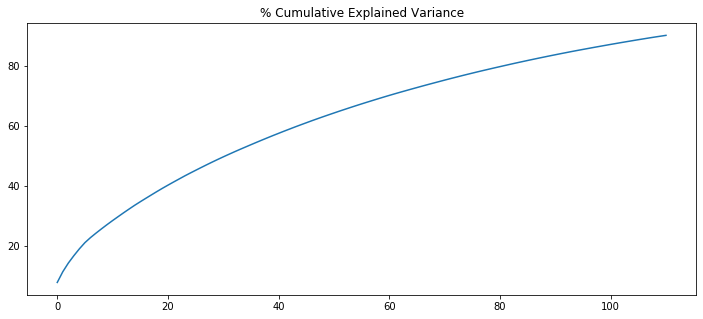

In [21]:
pca = PCA(.90) #instantiate PCA, keep 90% of variance                  ### Very good.
X_train_pca = pca.fit_transform(X_train) # fit the model
print(pca.n_components_) #check number of components
var = pca.explained_variance_ratio_#The amount of variance that each PC explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100) #Cumulative Variance explained by PC
plt.subplots(1,figsize=(12,5));
plt.plot(var1);
plt.title('% Cumulative Explained Variance');

#### Linear Regression Model based on Features Extracted by PCA

The model below has fairly wide range of R2 scores when cross validated. However, the overall scores are good.

In [22]:
X_test_pca = pca.transform(X_test)
lm_pca = LinearRegression() #instantiate
lm_pca.fit(X_train_pca,y_train)
preds = lm_pca.predict(X_test_pca) #predict SalePrice
cv = cross_val_score(lm_pca,X_train_pca,y_train,cv=5)
print(cv, '\nMean:',np.mean(cv))

[0.82031482 0.87078062 0.82826725 0.79670186 0.91431678] 
Mean: 0.8460762648362931


In [23]:
print('R2 Score for train set:',lm_pca.score(X_train_pca, y_train))
print('R2 Score for test set:',lm_pca.score(X_test_pca, y_test))
print('MAE for test predictions:',mean_absolute_error(y_test,preds))
print('MSE for test predictions:',mean_squared_error(y_test,preds))
print('RMSE for test predictions:',mean_squared_error(y_test,preds)**0.5)

R2 Score for train set: 0.9070646462498531
R2 Score for test set: 0.892420687847446
MAE for test predictions: 17948.78558855483
MSE for test predictions: 616265017.2710259
RMSE for test predictions: 24824.685642944725


#### Ridge Regularization on all Features

Test the result of ridge regularized regression on all features. The results are somewhat better than PCA. The R2 scores are consistent and the MAE, MSE, RMSE are smaller than the linear regression using PCA.

In [24]:
# instantiate cross validated ridge regression model 
ridge_all = RidgeCV(alphas=np.logspace(0, 5, 200), store_cv_values=True)
ridge_all = ridge_all.fit(X_train, y_train) #fit model
ridge_optimal_alpha = ridge_all.alpha_ #get optimal alpha
ridge_optimal_alpha

162.5755666443795

In [25]:
ridge_all = Ridge(alpha=ridge_optimal_alpha)# instatntiate ridge model with alpha as optimal
ridge_cv_r2 = cross_val_score(ridge_all, X_train, y_train, cv=5, scoring='r2') #run cross validation
print(ridge_cv_r2, '\nMean:',ridge_cv_r2.mean()) #get cross validated R2 scores for ridge regression of optimal alpha

[0.8767887  0.88845995 0.88932306 0.90820708 0.92600079] 
Mean: 0.8977559146535864


In [26]:
ridge_all = ridge_all.fit(X_train, y_train)
preds = ridge_all.predict(X_test) #predict SalePrice
print('R2 Score for train set:',ridge_all.score(X_train, y_train))
print('R2 Score for test set:',ridge_all.score(X_test, y_test))
print('MAE for test predictions:',mean_absolute_error(y_test,preds))
print('MSE for test predictions:',mean_squared_error(y_test,preds))
print('RMSE for test predictions:',mean_squared_error(y_test,preds)**0.5)

R2 Score for train set: 0.9271246419273489
R2 Score for test set: 0.9100489332301301
MAE for test predictions: 16412.95527467315
MSE for test predictions: 515282117.0474917
RMSE for test predictions: 22699.82636602077


#### Lasso Regularization on all Features

Build a Lasso regularized regressio model using all features. Results are not significantly better than ridge regression. Since this is the case, future runs will use ridge regression as Lasso can be computationally more expensive. 

In [27]:
# A:
lasso_all = LassoCV(n_alphas = 200, cv=5) #instantiate cross validated lasso model with n_alphas 200 
lasso_all = lasso_all.fit(X_train, y_train) #fit model
lasso_optimal_alpha = lasso_all.alpha_ #get optimal alpha
lasso_optimal_alpha

645.7879413463897

In [28]:
lasso_all = Lasso(alpha=lasso_optimal_alpha) #instantiate lasso model with optimal alpha 
lasso_cv_r2= cross_val_score(lasso_all, X_train, y_train, cv=5, scoring='r2') #run cross validation
print(lasso_cv_r2,'\nMean:',lasso_cv_r2.mean()) #get R2 scores

[0.87323548 0.89530996 0.8893447  0.90996888 0.92860044] 
Mean: 0.8992918923676385


In [29]:
lasso_all.fit(X_train, y_train) #fit the model
preds = lasso_all.predict(X_test) #predict SalePrice
print('R2 Score for train set:',lasso_all.score(X_train, y_train))
print('R2 Score for test set:',lasso_all.score(X_test, y_test))
print('MAE for test predictions:',mean_absolute_error(y_test,preds))
print('MSE for test predictions:',mean_squared_error(y_test,preds))
print('RMSE for test predictions:',mean_squared_error(y_test,preds)**0.5)

R2 Score for train set: 0.9203095448076579
R2 Score for test set: 0.9158814883515528
MAE for test predictions: 16198.671564799084
MSE for test predictions: 481870491.60838634
RMSE for test predictions: 21951.548729153175


#### Recursive Feature Elimination on all Features

Recursive Feature Elimination on all features does not seem to do as well as regularized regression. 

In [30]:
lm_rfe = LinearRegression() #instantiate model
# using recursive feature elimination with built in cross validation RFECV package, look for the set of best features
rfecv = RFECV(lm_rfe, step=1, cv=5, n_jobs=-1)
rfecv = rfecv.fit(X_train, y_train) #fit the model
preds = rfecv.predict(X_test)
# print summaries for the selection of attributes
print("Features selected:", ", ".join(X.iloc[:, rfecv.support_].columns))

Features selected: Overall Qual, Exter Qual, BsmtFin SF 1, 1st Flr SF, 2nd Flr SF


In [31]:
print('R2 Score for train set:',rfecv.score(X_train, y_train))
print('R2 Score for test set:',rfecv.score(X_test, y_test))
print('MAE for test predictions:',mean_absolute_error(y_test,preds))
print('MSE for test predictions:',mean_squared_error(y_test,preds))
print('RMSE for test predictions:',mean_squared_error(y_test,preds)**0.5)

R2 Score for train set: 0.8422542822788472
R2 Score for test set: 0.8522425319087957
MAE for test predictions: 22131.319456488374
MSE for test predictions: 846424436.1036955
RMSE for test predictions: 29093.37443652241


### Regression Model: All Features Correlated with SalePrice

#### Feature Selection from Variables with Correlation

Based on EDA, the features with correlation/dependency with the target variable was used. 

In [32]:
with open('../datasets/features2.csv','r') as f: #test on both features1.csv and features2.csv
    reader = csv.reader(f) #difference is in the nominal variables used based on type of hypothesis testing
    features = list(reader)[0]
print("No of features:",len(features),"\n",features)

No of features: 33 
 ['MS SubClass', 'MS Zoning', 'Land Contour', 'Lot Config', 'Neighborhood', 'Condition 1', 'Bldg Type', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Central Air', 'Garage Type', 'Sale Type', 'Mas Vnr Area', 'Total Bsmt SF', '1st Flr SF', 'Gr Liv Area', 'Garage Area', 'Year Built', 'Year Remod/Add', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars', 'Overall Qual', 'Exter Qual', 'Bsmt Qual', 'Heating QC', 'Kitchen Qual', 'Fireplace Qu', 'Garage Finish']


In [33]:
#since we use age instead of years
features.remove('Year Remod/Add')
features.remove('Year Built')
features = features + ['house_age','yrs_since_remod','was_remod']
print("No of features:",len(features),"\n",features)

No of features: 34 
 ['MS SubClass', 'MS Zoning', 'Land Contour', 'Lot Config', 'Neighborhood', 'Condition 1', 'Bldg Type', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Central Air', 'Garage Type', 'Sale Type', 'Mas Vnr Area', 'Total Bsmt SF', '1st Flr SF', 'Gr Liv Area', 'Garage Area', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars', 'Overall Qual', 'Exter Qual', 'Bsmt Qual', 'Heating QC', 'Kitchen Qual', 'Fireplace Qu', 'Garage Finish', 'house_age', 'yrs_since_remod', 'was_remod']


In [34]:
#keep features that are not nominal, and features that have been dummied
features = [i for i in features if i not in dummies.columns] + [i for i in dummied_df.drop(dummy_drops,axis=1).columns for j in features if j in i]
len(features)

146

#### Get X and y for this set of features

In [35]:
#scale
X=df[features]
scaler_corr = StandardScaler() #instantiate scaler 
X_sc = scaler_corr.fit_transform(X) #scale
y = df.SalePrice #prep target variable
X_train ,X_test, y_train, y_test = train_test_split(X_sc, y , test_size=0.30,random_state=2019) # split into train test set

#### Linear Regression Model based on Features Extracted

Using a model without any regularization causes a very wide range of R2 scores.

In [36]:
lm_corr = LinearRegression()
lm_corr.fit(X_train,y_train)
preds = lm_corr.predict(X_test) #predict SalePrice
cv = cross_val_score(lm_corr,X_train,y_train,cv=5)
print(cv, '\nMean:',np.mean(cv))

[-3.91778417e+19 -4.27575932e+19 -2.58792620e+23 -9.21145979e+20
  8.81598512e-01] 
Mean: -5.1959140289139555e+22


In [37]:
print('R2 Score for train set:',lm_corr.score(X_train, y_train))
print('R2 Score for test set:',lm_corr.score(X_test, y_test))
print('MAE for test predictions:',mean_absolute_error(y_test,preds))
print('MSE for test predictions:',mean_squared_error(y_test,preds))
print('RMSE for test predictions:',mean_squared_error(y_test,preds)**0.5)

R2 Score for train set: 0.904800269747573
R2 Score for test set: -9.079076004089034e+21
MAE for test predictions: 558524181975508.94
MSE for test predictions: 5.200922759694413e+31
RMSE for test predictions: 7211742341275382.0


#### Ridge Regularization on Features Correlated with SalePrice

Ridge Regression performs significantly better, but still not quite as well as using all features.

In [38]:
# instantiate cross validated ridge regression model 
ridge_corr = RidgeCV(alphas=np.logspace(0, 5, 200), store_cv_values=True)
ridge_corr = ridge_corr.fit(X_train, y_train) #fit model
ridge_optimal_alpha = ridge_corr.alpha_ #get optimal alpha
ridge_optimal_alpha

114.89510001873097

In [39]:
ridge_corr = Ridge(alpha=ridge_optimal_alpha)# instatntiate ridge model with alpha as optimal
ridge_cv_r2 = cross_val_score(ridge_corr, X_train, y_train, cv=5, scoring='r2') #run cross validation
print(ridge_cv_r2, '\nMean:',ridge_cv_r2.mean()) #get cross validated R2 scores for ridge regression of optimal alpha

[0.85015748 0.8540535  0.88308045 0.86876594 0.89602119] 
Mean: 0.8704157109865678


In [40]:
ridge_corr = ridge_corr.fit(X_train, y_train)
preds = ridge_corr.predict(X_test) #predict SalePrice
print('R2 Score for train set:',ridge_corr.score(X_train, y_train))
print('R2 Score for test set:',ridge_corr.score(X_test, y_test))
print('MAE for test predictions:',mean_absolute_error(y_test,preds))
print('MSE for test predictions:',mean_squared_error(y_test,preds))
print('RMSE for test predictions:',mean_squared_error(y_test,preds)**0.5)

R2 Score for train set: 0.8985853552007359
R2 Score for test set: 0.8929360559073721
MAE for test predictions: 18250.92942792121
MSE for test predictions: 613312746.0583134
RMSE for test predictions: 24765.151848077036


### Regression Model: Polynomial Features from Correlated Features

#### Add Interaction Terms

In [41]:
X=df[features] #create X
poly = PolynomialFeatures(2,interaction_only=True,include_bias=False) # Instantiate PolynomialFeatures
X_poly = poly.fit_transform(X) # Create X_poly
print(X_poly.shape)                                    ### 2049 rows and 10731 columns would definitely require some feature
# View X_poly in a DataFrame                           ### selection or regularisation. Expect a very large alpha.
X_poly = pd.DataFrame(X_poly, columns = poly.get_feature_names(X.columns))
X_poly.head()

(2049, 10731)


Central Air  Mas Vnr Area  Total Bsmt SF  1st Flr SF  Gr Liv Area  \
0          1.0         289.0          725.0       725.0       1479.0   
1          1.0         132.0          913.0       913.0       2122.0   
2          1.0           0.0         1057.0      1057.0       1057.0   
3          1.0           0.0          384.0       744.0       1444.0   
4          1.0           0.0          676.0       831.0       1445.0   

   Garage Area  Full Bath  TotRms AbvGrd  Garage Cars  Overall Qual  ...  \
0        475.0        2.0            6.0          2.0           6.0  ...   
1        559.0        2.0            8.0          2.0           7.0  ...   
2        246.0        1.0            5.0          1.0           5.0  ...   
3        400.0        2.0            7.0          2.0           5.0  ...   
4        484.0        2.0            6.0          2.0           6.0  ...   

   Sale Type_ConLD Sale Type_ConLI  Sale Type_ConLD Sale Type_ConLw  \
0                              0.0                              0.0   
1                              0.0                              0.0   
2                              0.0                              0.0   
3                              0.0                              0.0   
4                              0.0                              0.0   

   Sale Type_ConLD Sale Type_New  Sale Type_ConLD Sale Type_WD   \
0                            0.0                            0.0   
1                            0.0                            0.0   
2                            0.0                            0.0   
3                            0.0                            0.0   
4                            0.0                            0.0   

   Sale Type_ConLI Sale Type_ConLw  Sale Type_ConLI Sale Type_New  \
0                              0.0                            0.0   
1                              0.0                            0.0   
2                              0.0                            0.0   
3                              0.0                            0.0   
4                              0.0                            0.0   

   Sale Type_ConLI Sale Type_WD   Sale Type_ConLw Sale Type_New  \
0                            0.0                            0.0   
1                            0.0                            0.0   
2                            0.0                            0.0   
3                            0.0                            0.0   
4                            0.0                            0.0   

   Sale Type_ConLw Sale Type_WD   Sale Type_New Sale Type_WD   
0                            0.0                          0.0  
1                            0.0                          0.0  
2                            0.0                          0.0  
3                            0.0                          0.0  
4                            0.0                          0.0  

[5 rows x 10731 columns]

In [42]:
scaler_poly = StandardScaler() #instantiate scaler
X_sc = scaler_poly.fit_transform(X_poly) #scale
y = df.SalePrice #prep target variable
X_train ,X_test, y_train, y_test = train_test_split(X_sc, y , test_size=0.30,random_state=2019) # split into train test set

#### Linear Regression Model based on Polynomial Features

Again, this model has a very wide range of R2 scores when cross validated.

In [43]:
lm_poly = LinearRegression()
lm_poly.fit(X_train,y_train)
preds = lm_poly.predict(X_test) #predict SalePrice
cv = cross_val_score(lm_poly,X_train,y_train,cv=5)
print(cv, '\nMean:',np.mean(cv))                           ### It's terrible because you have too many columns.

[-1.05328951e-01 -1.75547620e+00 -8.69025691e+10 -8.87369075e+11
 -1.05291116e+09] 
Mean: -195064911020.77335


In [44]:
print('R2 Score for train set:',lm_poly.score(X_train, y_train))
print('R2 Score for test set:',lm_poly.score(X_test, y_test))
print('MAE for test predictions:',mean_absolute_error(y_test,preds))
print('MSE for test predictions:',mean_squared_error(y_test,preds))
print('RMSE for test predictions:',mean_squared_error(y_test,preds)**0.5)

R2 Score for train set: 0.9999999465091889
R2 Score for test set: -177239799950.84137
MAE for test predictions: 13405374743.45505
MSE for test predictions: 1.0153131321712159e+21
RMSE for test predictions: 31863978599.214756


#### Ridge Regularization on Polynomial Features

Regularization does well when used with this set of features including interactions. However, the difference between the R2 scores for the training and testing data is larger than the other models.

In [45]:
# instantiate cross validated ridge regression model 
ridge_poly = RidgeCV(alphas=np.logspace(0, 5, 200), store_cv_values=True)
ridge_poly = ridge_poly.fit(X_train, y_train) #fit model
ridge_optimal_alpha = ridge_poly.alpha_ #get optimal alpha
ridge_optimal_alpha                                         ### Here's my really large alpha.

1552.225357427048

In [46]:
ridge_poly = Ridge(alpha=ridge_optimal_alpha)# instatntiate ridge model with alpha as optimal
ridge_cv_r2 = cross_val_score(ridge_poly, X_train, y_train, cv=5, scoring='r2') #run cross validation
print(ridge_cv_r2, '\nMean:',ridge_cv_r2.mean()) #get cross validated R2 scores for ridge regression of optimal alpha

[0.8909059  0.87902837 0.90017318 0.90583286 0.92987964] 
Mean: 0.9011639894307262


In [47]:
ridge_poly = ridge_poly.fit(X_train, y_train)
preds = ridge_poly.predict(X_test) #predict SalePrice
print('R2 Score for train set:',ridge_poly.score(X_train, y_train))
print('R2 Score for test set:',ridge_poly.score(X_test, y_test))
print('MAE for test predictions:',mean_absolute_error(y_test,preds))
print('MSE for test predictions:',mean_squared_error(y_test,preds))
print('RMSE for test predictions:',mean_squared_error(y_test,preds)**0.5)

R2 Score for train set: 0.9654258638899831
R2 Score for test set: 0.8961234233314963
MAE for test predictions: 16874.00396749348
MSE for test predictions: 595054002.7983488
RMSE for test predictions: 24393.728759628953


### Regression Model: Grouped Features

A number of features describing the same property are very similar. It may be more useful to create new features based on these, including
- Misc Features are largely absent
- Alley type also largely none
- Land Contours are largely Lvl
- Condition 1 and 2 can be grouped by positive feature, normal (dropped), near major road, near railroad
- House Style can be grouped by 1-1.5 level, 2-2.5 level, split leve
- Both sets of Condition and Exterior can be grouped together

In [48]:
group_catby = ['Misc Feat','Alley_','Contour','Condition 1_RR','Condition 2_RR','Condition 1_Pos','Condition 2_Pos',
               'House Style_1','House Style_2']

In [49]:
def group_cats(df, list_strs): #function for grouping
    for x in list_strs: #for each element in list of strings
        temp = [i for i in df.columns if x in i] #if the element is in the list of columns
        df[x] = df[temp].sum(axis=1) #sum the columns
        df= df.drop(temp,axis=1) #then drop those column
    return df
df2 = group_cats(df[features].copy(), group_catby)

In [50]:
cond1road = ['Condition 1_Artery', 'Condition 1_Feedr']
df2['Condition 1_rd'] = df2[cond1road].sum(axis=1)
df2.drop(cond1road,axis=1,inplace=True)
cond2road = ['Condition 2_Artery', 'Condition 2_Feedr']
df2['Condition 2_rd'] = df2[cond2road].sum(axis=1)          ### error here. 
df2.drop(cond2road,axis=1,inplace=True)
np.sum(df2['Condition 2_rd'])
#drop split level for house style
df2.drop('House Style_SFoyer',axis=1,inplace=True)

KeyError: "None of [Index(['Condition 2_Artery', 'Condition 2_Feedr'], dtype='object')] are in the [columns]"

In [ ]:
cond_names = [i for i in df2.columns if 'Condition' in i] #condition 1 and 2 can be further grouped
condtype = list(set([i.split('_')[1] for i in cond_names]))
cond = group_cats(df2[cond_names].copy(),condtype)
cond = cond.replace({2:1})
cond.add_prefix('condition_')
cond.head()
df2.drop(cond_names,axis=1,inplace=True)
df2 = pd.concat([df2,cond],axis=1)

In [ ]:
ext_names = [i for i in df2.columns if 'Exterior' in i] # exterior can be grouped
exttype = list(set([i.split('_')[1] for i in ext_names]))
ext = group_cats(df2[ext_names].copy(),exttype)
ext = ext.replace({2:1})
ext = ext.add_prefix('exterior_')
ext.head()
df2.drop(ext_names,axis=1,inplace=True)
df2 = pd.concat([df2,ext],axis=1)

In [ ]:
df2.head()

#### Linear Regression Model based on Features Extracted

Again, this model has a very wide range of R2 scores when cross validated.

In [ ]:
X = df2.values
scaler_group = StandardScaler() #instantiate scaler
X_sc = scaler_group.fit_transform(X) #scale
y = df.SalePrice.values #prep target variable
X_train ,X_test, y_train, y_test = train_test_split(X_sc, y , test_size=0.30,random_state=2019) # split into train test set

In [ ]:
lm_corr = LinearRegression()
lm_corr.fit(X_train,y_train)
preds = lm_corr.predict(X_test) #predict SalePrice
cv = cross_val_score(lm_corr,X_train,y_train,cv=5)
print(cv, '\nMean:',np.mean(cv))

In [ ]:
print('R2 Score for train set:',lm_corr.score(X_train, y_train))
print('R2 Score for test set:',lm_corr.score(X_test, y_test))
print('MAE for test predictions:',mean_absolute_error(y_test,preds))
print('MSE for test predictions:',mean_squared_error(y_test,preds))
print('RMSE for test predictions:',mean_squared_error(y_test,preds)**0.5)

#### Ridge Regularization on Grouped Features

Regularization, as usual performs well on grouping the features, but not any better than not grouping them. Thus, given the amount of effort it would take to convert features into groups, a model using this these features does not provide any benefit.

In [ ]:
# instantiate cross validated ridge regression model 
ridge_group = RidgeCV(alphas=np.logspace(0, 5, 200), store_cv_values=True)
ridge_group = ridge_group.fit(X_train, y_train) #fit model
ridge_optimal_alpha = ridge_group.alpha_ #get optimal alpha
ridge_optimal_alpha

In [ ]:
ridge_group = Ridge(alpha=ridge_optimal_alpha)# instatntiate ridge model with alpha as optimal
ridge_cv_r2 = cross_val_score(ridge_group, X_train, y_train, cv=5, scoring='r2') #run cross validation
print(ridge_cv_r2, '\nMean:',ridge_cv_r2.mean()) #get cross validated R2 scores for ridge regression of optimal alpha

In [ ]:
ridge_group = ridge_group.fit(X_train, y_train)
preds = ridge_group.predict(X_test) #predict SalePrice
print('R2 Score for train set:',ridge_group.score(X_train, y_train))
print('R2 Score for test set:',ridge_group.score(X_test, y_test))
print('MAE for test predictions:',mean_absolute_error(y_test,preds))
print('MSE for test predictions:',mean_squared_error(y_test,preds))
print('RMSE for test predictions:',mean_squared_error(y_test,preds)**0.5)

## Run Model on Prediction Data

Since our aim is to test the model on entirely unknown data. For each model, we run the prediction and write to csv to upload to Kaggle.

In [ ]:
X_unk=unk_df[features] #create X
X_unk_poly = poly.transform(X_unk) # Create X_poly
X_unk = scaler_poly.transform(X_unk_poly) #scale

In [ ]:
ids = pd.read_csv('../datasets/test.csv')['Id']

In [ ]:
unknown_preds = ridge_poly.predict(X_unk)
unknown_preds[:5]

In [ ]:
submission_df = pd.DataFrame(list(zip(ids, unknown_preds)),columns=['Id','SalePrice'])
submission_df.to_csv('../datasets/submission.csv',index=False)
submission_df.head()

## Conclusion and Recommendation

We made a number of submissions to Kaggle to test the model on the test data with unknown Sale Prices. The following predictions were uploaded and scored (RMSE):

|Model Type|Private Score|Public Score|
|:--|:--|:--|
|Regression with Features from Principal Component Analysis|898872.33413|757174.22040|
|Ridge Regularized Regression with All Features|1420076.72922|1350833.81896|
|Lasso Regularized Regression with All Features|1043070.54246|982289.61564|
|Recursive Feature Elimination|1043070.54246|982289.61564|
|Ridge Regularized Regression with Correlated Features|34232.17720|33672.56820|
|Ridge Regularized Regression with Polynomial Features from Correlated Features|35369.82752|29624.99647|
|Ridge Regularized Regression with Grouped Features|32884.16859|32287.95089|

The scores show that the model that performed the best was the model using polynomial features as input, with the grouped features and correlated features close behind. In general all the models using all features as initial input performed poorly, with the features selected using PCA doing the best, followed by Lasso and RFE. Interestingly, since the score from Lasso and RFE are the same, using them for feature selection on this data set likely returns very similar feature selections. 

Another point to note is that although the cross validation and scores during modelling showed similar scores for Lasso and Ridge regression, with the unknown data, predictions from Lasso regularized regression with all features was somewhat better than the results from the Ridge regularized regression. A Lasso regularized regression model and a model with RFE using the polynomial features as input were attempted, but the time required for these were significantly longer. 

Since we are building a model for home buyers and sellers estimations on appropriate prices, these models are too computationally expensive given that our model will need to be retrained regularly to ensure that the model remains relevant when other changes happen in indicators out of our control such as government policies, stamp duties or economic performance.

## Appendix

#### Prediction with Category Grouping

This was run to test the grouped data, but as mentioned earlier, the effort needed to transform this is not worth the results.

In [ ]:
unk_df2 = group_cats(unk_df[features].copy(), group_catby)

In [ ]:
unk_df2['Condition 1_rd'] = unk_df2[cond1road].sum(axis=1)
unk_df2.drop(cond1road,axis=1,inplace=True)
unk_df2['Condition 2_rd'] = unk_df2[cond2road].sum(axis=1)
unk_df2.drop(cond2road,axis=1,inplace=True)
np.sum(unk_df2['Condition 2_rd'])
#drop split level for house style
unk_df2.drop('House Style_SFoyer',axis=1,inplace=True)

In [ ]:
cond_names = [i for i in unk_df2.columns if 'Condition' in i] #condition 1 and 2 can be further grouped
condtype = list(set([i.split('_')[1] for i in cond_names]))
cond = group_cats(unk_df2[cond_names].copy(),condtype)
cond = cond.replace({2:1})
cond.add_prefix('condition_')
cond.head()
unk_df2.drop(cond_names,axis=1,inplace=True)
unk_df2 = pd.concat([unk_df2,cond],axis=1)

In [ ]:
ext_names = [i for i in unk_df2.columns if 'Exterior' in i] # exterior can be grouped
exttype = list(set([i.split('_')[1] for i in ext_names]))
ext = group_cats(unk_df2[ext_names].copy(),exttype)
ext = ext.replace({2:1})
ext = ext.add_prefix('exterior_')
ext.head()
unk_df2.drop(ext_names,axis=1,inplace=True)
unk_df2 = pd.concat([unk_df2,ext],axis=1)

In [ ]:
X_unk = scaler_group.transform(unk_df2) #scale

In [ ]:
submission_df.to_csv('../datasets/submission2.csv',index=False)

In [ ]:
unknown_preds = ridge_group.predict(X_unk)
submission_df = pd.DataFrame(list(zip(ids, unknown_preds)),columns=['Id','SalePrice'])
submission_df.head()